In [1]:
import sys
import numpy as np
from scipy.stats import gaussian_kde
import theano.tensor as T
import theano
import os
import re
import glob
import h5py
from scipy.stats import norm
from keras import *
from sklearn.metrics import roc_curve, roc_auc_score, auc
from keras.models import Sequential,Model
from keras.layers import Dense, Activation,Input, Dense, Dropout, merge
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.optimizers import *
from keras.models import model_from_json
from keras.layers import *
import matplotlib.pyplot as pt
%matplotlib inline

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
/tmp/try_flags_tXmGQK.c:4:19: fatal error: cudnn.h: No such file or directory
compilation terminated.

Mapped name None to device cuda0: GeForce GTX 860M (0000:01:00.0)
Using Theano backend.


In [2]:
def loadmodel(name, weights = False):
    json_file = open('/home/kaustuv1993/Desktop/H2bb/Models_and_Weights/%s_m.json'%name, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    #load weights into new model
    if weights==True:
        model.load_weights('/home/kaustuv1993/Desktop/H2bb/Models_and_Weights/%s_w.h5'%name)
    print (model.summary())
    print("Loaded model %s from disk"%name)
    return model

def savemodel(model,name="neural network"):
    #print "Saving model:"
    model_name = name
    #model.summary()
    model.save_weights('/home/kaustuv1993/Desktop/H2bb/Models_and_Weights/%s_w.h5'%model_name, overwrite=True)
    model_json = model.to_json()
    with open("/home/kaustuv1993/Desktop/H2bb/Models_and_Weights/%s_m.json"%model_name, "w") as json_file:
        json_file.write(model_json)
        
def savelosses(hist, name="neural network"):  
    print "Saving losses:"
    loss = np.array(hist.history['loss'])
    valoss = np.array(hist.history['val_loss'])
    f = h5py.File("/home/kaustuv1993/Desktop/H2bb/Models_and_Weights/%s_h.h5"%name,"w")
    f.create_dataset('loss',data=loss)
    f.create_dataset('val_loss',data=valoss)
    f.close()

In [3]:
#import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors

def get_cmap(N):
    
    '''Returns a function that maps each index in 0, 1, ... N-1 to a distinct 
    RGB color.'''
    color_norm  = colors.Normalize(vmin=0, vmax=N-1)
    scalar_map = cmx.ScalarMappable(norm=color_norm, cmap='hsv') 
    def map_index_to_rgb_color(index):
        return scalar_map.to_rgba(index)
    return map_index_to_rgb_color

In [4]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers.advanced_activations import PReLU, LeakyReLU

In [5]:
def hist(y, n=25):
    plt.figure(figsize=(8,8))
    l = y.min()
    r = y.max()
    w = ((r-l)/float(y.shape[0]*1.))
    plt.hist(y, histtype='step', bins=n)
    plt.show()

#generates a Gaussian 
def gaussian(batch_size, mu=0.,sigma=0.5):
    sample = np.random.normal(mu, sigma, batch_size)
    sample.sort()
    return np.reshape(sample,(len(sample),1))

def noise(batch_size, m=-2.5, M=2.5):
    a = np.linspace(m, M, batch_size) + np.random.random(batch_size) * 0.01
    return np.reshape(a,(len(a),1))

def noise_g(batch_size, mu=0.,sigma=0.6):
    sample = np.random.normal(mu, sigma, batch_size)+np.random.random(batch_size) * 0.01
    sample.sort()
    return np.reshape(sample,(len(sample),1))

#y=gaussian(batch_size=10000, mu=5, sigma=5)
#print y.shape
#hist(y)

1.92077051173 -2.03136451647


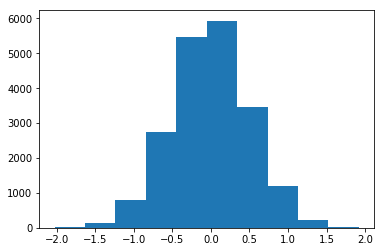

0.499810585221 -0.0045415794725 -3 3


(array([ 1991.,  2006.,  2002.,  2003.,  2001.,  1995.,  2008.,  2000.,
         2002.,  1992.]),
 array([-2.99735502, -2.39677641, -1.79619781, -1.19561921, -0.5950406 ,
         0.005538  ,  0.6061166 ,  1.20669521,  1.80727381,  2.40785241,
         3.00843102]),
 <a list of 10 Patch objects>)

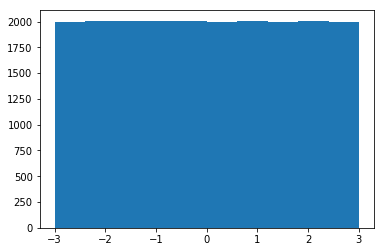

In [6]:
batch_size=20000
mu, sigma = 0, 0.5
gaus = np.random.normal(mu, sigma, batch_size)
plt.hist(gaus)
print gaus.max(), gaus.min()
plt.show()

true_disc_x = gaussian(batch_size,mu=0.,sigma=0.5)
sd = np.std(true_disc_x)
mean = np.mean(true_disc_x)
l = -3
r = 3
print sd, mean, l ,r
latent = noise(batch_size, m=l, M=r)
latent.sort()
plt.hist(latent)

In [7]:
def plot_loss(losses,modelname="GAN"):
    #display.clear_output(wait=True)
    #display.display(plt.gcf())
    plt.figure(figsize=(16,9))
    plt.plot(losses["d_f"], label='discriminative loss on fake', alpha=0.8)
    plt.plot(losses["d_t"], label='discriminative loss on true', alpha=0.8)
    plt.plot(losses["d"], label = 'discriminative loss', alpha=0.8)
    plt.plot(losses["g"], label='generative loss', alpha=0.8)
    #plt.yscale('log')
    plt.xlabel('Epochs', fontsize=22)
    plt.ylabel('Loss', fontsize=22)
    plt.legend(fontsize=22, loc='best', fancybox=True, framealpha=0.)
    plt.savefig("%s_loss.png"%modelname)
    plt.show()


In [8]:
opt = Adam(lr=1e-4)#, decay = 0.009)
dopt = Adam(lr=1e-3)#, decay = 0.0009)
from keras.models import Sequential,Model

def gen_f():
    
    g_input= Input(shape=[1])
    g = Dense(200)(g_input)
    g = Activation('relu')(g)
    #g = BatchNormalization()(g)
    #g = GaussianNoise(stddev = 0.5)(g)
    #g = Dropout(0.2)(g)
    #g = Dense(1000)(g)
    #g = BatchNormalization()(g)
    #g = Activation('linear')(g)
    #g = GaussianNoise(stddev = 0.6)(g)
    #g = LeakyReLU()(g)
    #g = BatchNormalization()(g)
    #g = Dropout(0.2)(g)
    #g = Dense(1000)(g)
    #g = PReLU()(g)
    #g = BatchNormalization(momentum=0.9, weights=None)(g)
    #g = Dropout(0.2)(g)
    #g = Dense(1000)(g)
    #g = PReLU()(g)
    #g = BatchNormalization(momentum=0.9, weights=None)(g)
    #g = Dropout(0.2)(g)
    #g = Dense(100)(g)
    #g = PReLU()(g)
    #g = BatchNormalization(momentum=0.9, weights=None)(g)
    #g = Dropout(0.2)(g)
    #g = Dense(10)(g)
    #g = PReLU()(g)
    #g = BatchNormalization(momentum=0.9, weights=None)(g)
    #g = Dropout(0.1)(g)
    g = Dense(1, activation='linear')(g)
    G = Model(g_input,g)
    G.compile(loss='binary_crossentropy', optimizer=opt)
    return G

def disc_f():

    d_input= Input(shape=[1])
    d = Dense(400)(d_input)
    d = Activation('tanh')(d)
    #d = BatchNormalization()(d)
    #d = GaussianNoise(stddev = 0.33)(d)
    #d = Dropout(0.2)(d)
    d = Dense(400)(d)
    d = Activation('tanh')(d)
    #d = BatchNormalization()(d)
    #d = GaussianNoise(stddev = 0.33)(d)
    #d = Dropout(0.2)(d)
    d = Dense(400)(d)
    d = Activation('tanh')(d)
    #d = BatchNormalization()(d)
    #d = GaussianNoise(stddev = 0.33)(d)
    #d = Dropout(0.2)(d)
    #d = Dense(2000)(d)
    #d = Activation('tanh')(d)
    #d = BatchNormalization()(d)
    #d = Dropout(0.1)(d)
    #d = Dense(20)(d)
    #d = PReLU()(d)
    #d = BatchNormalization(momentum=0.9, weights=None)(d)
    #d = Dropout(0.2)(d)
    d = Dense(1, kernel_initializer='normal', activation='sigmoid')(d)
    D = Model(d_input,d)
    D.compile(loss='binary_crossentropy', optimizer=dopt)
    return D

def GAN_f(generator, discriminator):

    noise=Input(shape=[1])
    g=generator(noise)
    d=discriminator(g)
    discriminator.trainable = False
    GAN = Model(noise, d)
    GAN.compile(loss='binary_crossentropy', optimizer=opt)
    GAN.summary()
    return GAN

In [9]:
from keras.models import Sequential,Model
D = disc_f()
D.summary()
G = gen_f()
G.summary()
Model = GAN_f(G, D)
#D.trainable = True
Model.summary()
#p_g = G.predict(noise(10000))
#plt.hist(p_g)
#plt.show()
#p_d = D.predict(np.ones(5000))
#p_d = np.concatenate((p_d, D.predict(np.zeros(5000))))
#plt.hist(p_d)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               800       
_________________________________________________________________
activation_1 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 400)               160400    
_________________________________________________________________
activation_2 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 400)               160400    
_________________________________________________________________
activation_3 (Activation)    (None, 400)               0         
__________

In [13]:
batch_size = 10000
import random
losses = {"d_f":[], "d_t":[], "d":[], "g":[]}
def train(G, D, M, epoch):
    
    true_disc_x = gaussian(batch_size,mu=0.,sigma=0.5)
    sd = np.std(true_disc_x)
    mean = np.mean(true_disc_x)
    #l = -2.5 #mean-2*sd
    #r = +2.5 #mean+2*sd
    latent = noise_g(batch_size, mu=0., sigma = 0.6) #noise(batch_size, m=l, M=r) # m=true_disc_x.min(), M=true_disc_x.max())
    true_disc_y = np.zeros(batch_size)
    fake_disc_x = G.predict(latent)
    fake_disc_y = np.ones(batch_size)
    
    #label-smoothing
    #true_disc_y[0:] = 0.4*np.random.random_sample(1)[0]+0.8
    #fake_disc_y[0:] = 0.2*np.random.random_sample(1)[0]
    #true_disc_y[0:] = 0.9
    
    
    x_disc = np.concatenate((true_disc_x, fake_disc_x))
    x_disc = x_disc.reshape((x_disc.shape[0], 1))
    #print x_disc.shape
    y_disc = np.concatenate((true_disc_y, fake_disc_y))
    y_disc = y_disc.reshape((y_disc.shape[0], 1))
    #y_disc.flatten()
    #print y_disc.shape
    
    G.trainable = False
    D.trainable = True
    d_loss_true = D.train_on_batch(true_disc_x, true_disc_y)
    #d_loss_true = D.fit(true_disc_x, true_disc_y, batch_size=2000)
    d_loss_fake = D.train_on_batch(fake_disc_x, fake_disc_y)
    #d_loss_fake = D.fit(fake_disc_x, fake_disc_y, batch_size=2000)
    #d_loss = D.train_on_batch(x_disc, y_disc)
    d_loss = (d_loss_true + d_loss_fake) / 2.0
    losses["d_f"].append(d_loss_fake)
    losses["d_t"].append(d_loss_true)
    losses["d"].append(d_loss)
    
    x_gen = latent
    y_gen = np.zeros(batch_size)    
       
    G.trainable = True 
    D.trainable = False    
    
    GAN_loss = M.train_on_batch(x_gen, y_gen)
    losses["g"].append(GAN_loss)
    
    return d_loss, GAN_loss

0.701041698456
Epoch 1, Discriminator loss:0.692932724953, GAN loss:0.712924897671
For true: mean and s.d. =  -0.00537382044277 0.502217219866
For generator: mean and s.d. =  0.000268324 0.0329078


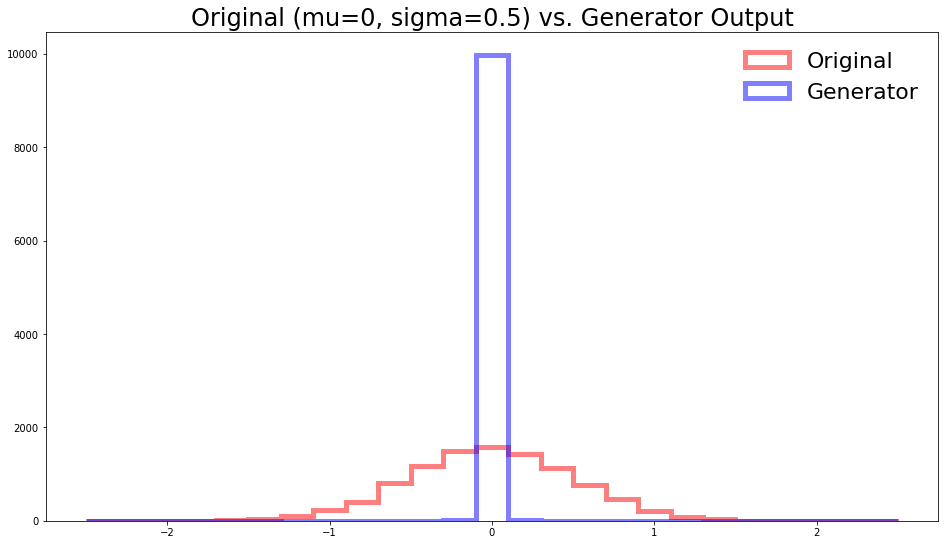

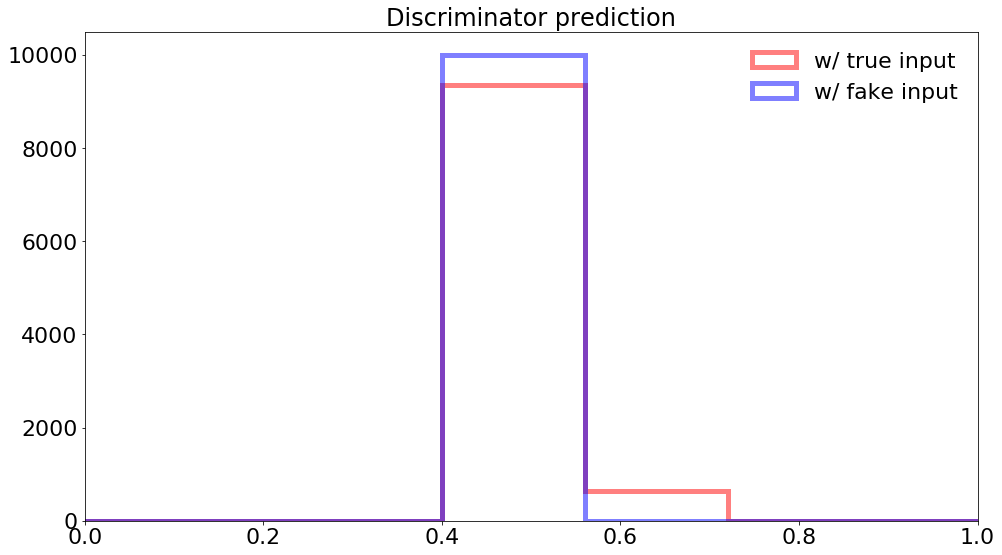

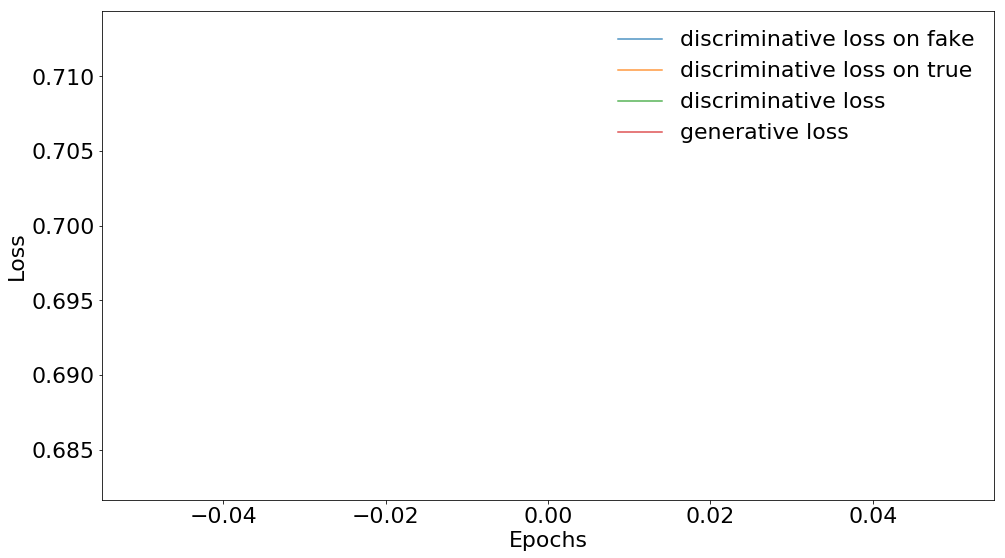

Epoch 101, Discriminator loss:0.693317890167, GAN loss:0.690351247787
For true: mean and s.d. =  0.00244185373207 0.503953776553
For generator: mean and s.d. =  0.00175223 0.0327075


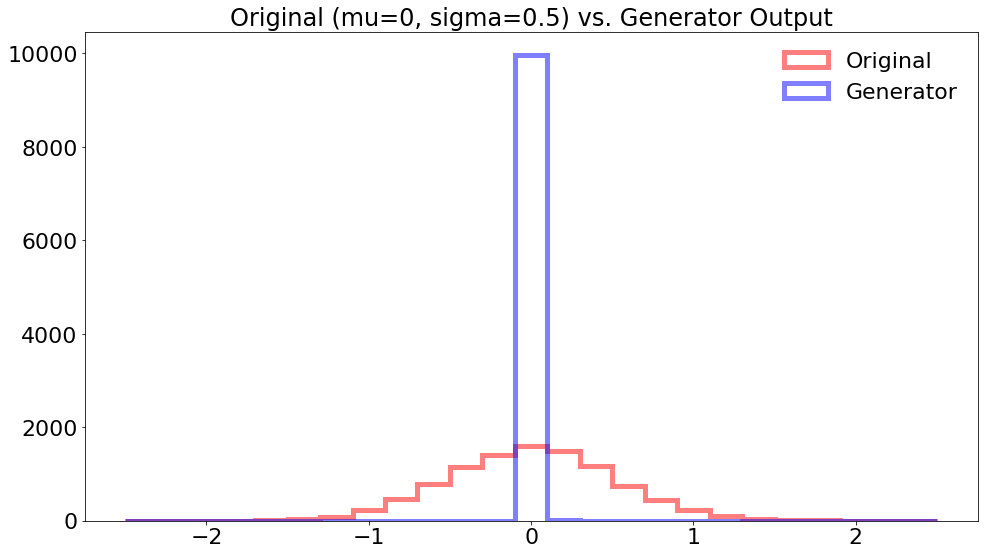

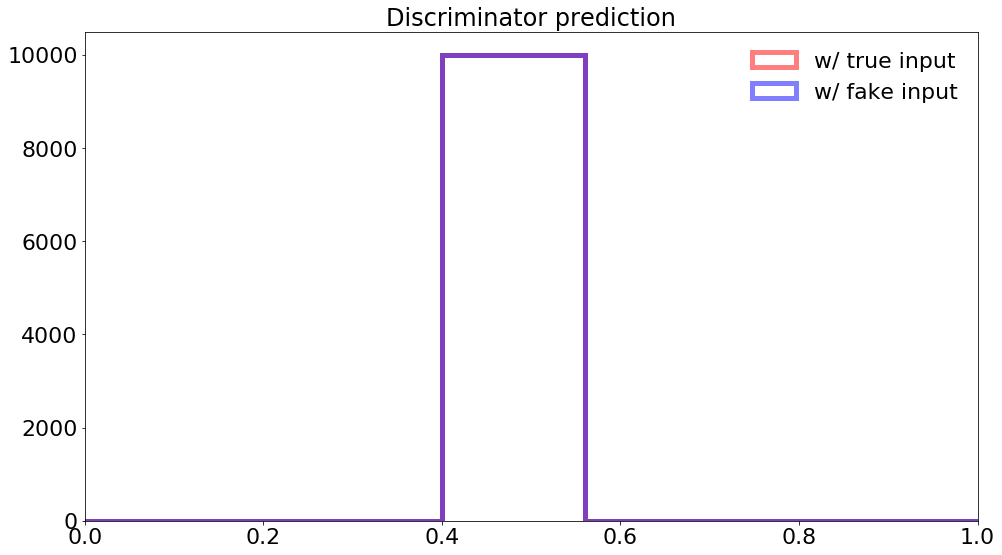

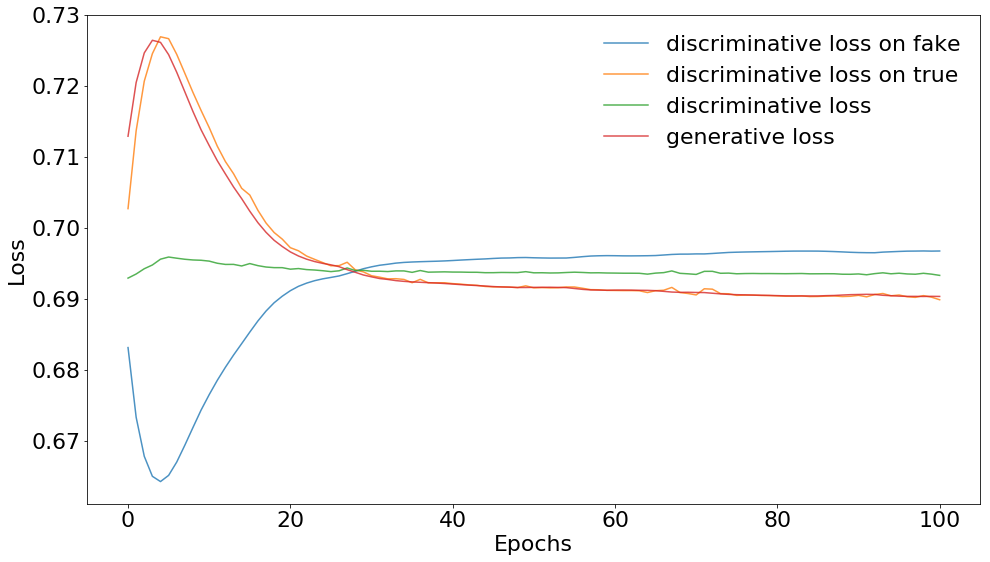

Epoch 201, Discriminator loss:0.582100272179, GAN loss:1.11114156246
For true: mean and s.d. =  -0.0132080858769 0.497097609483
For generator: mean and s.d. =  0.0461251 0.191837


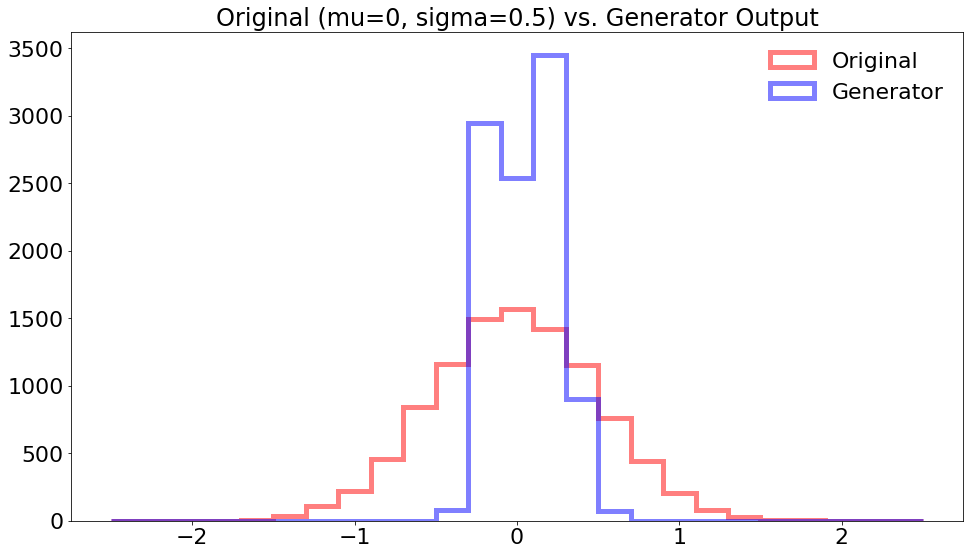

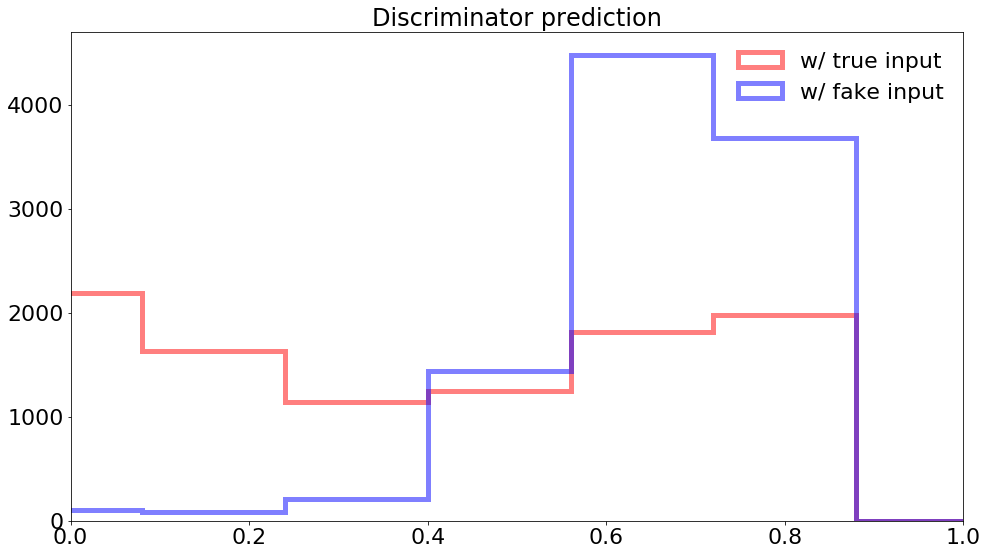

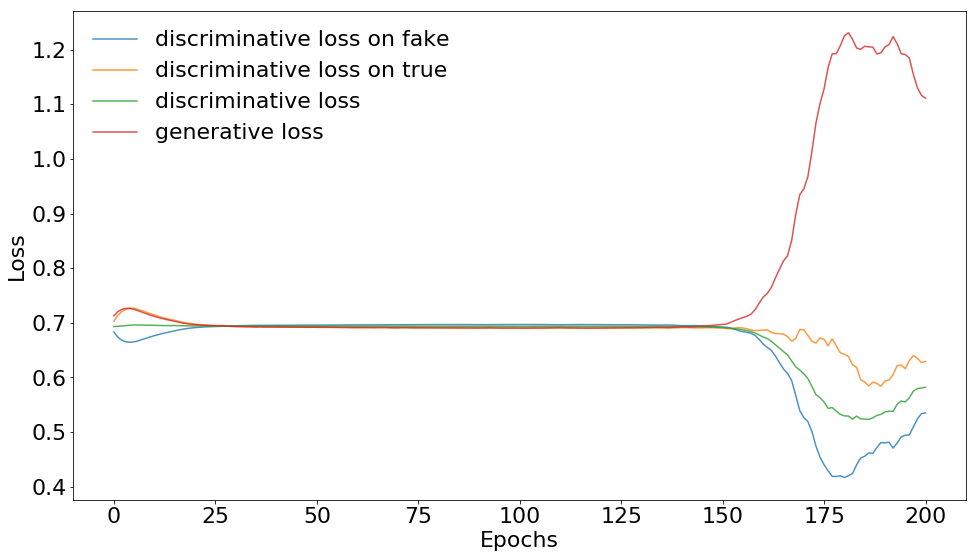

Epoch 301, Discriminator loss:0.690722703934, GAN loss:0.748613715172
For true: mean and s.d. =  0.00183950272856 0.502275353749
For generator: mean and s.d. =  0.0246854 0.400713


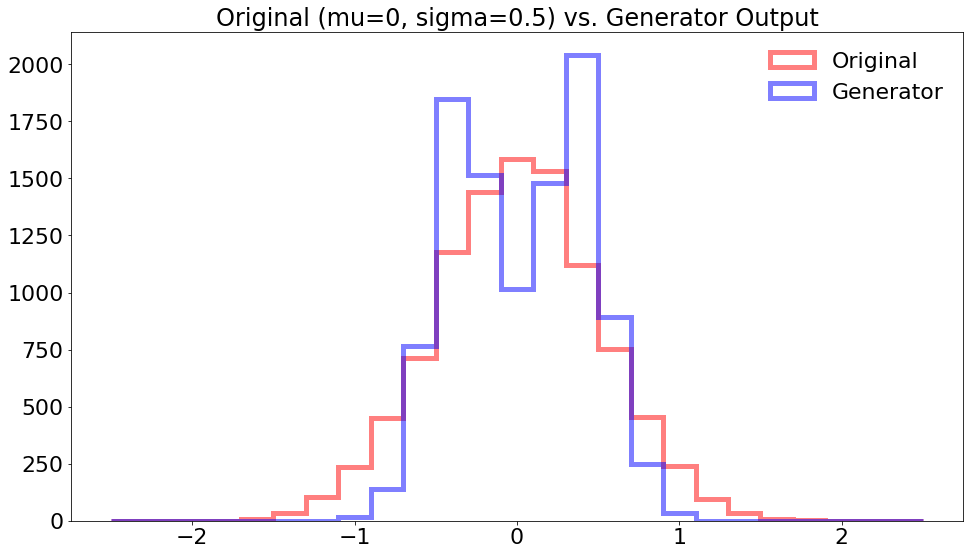

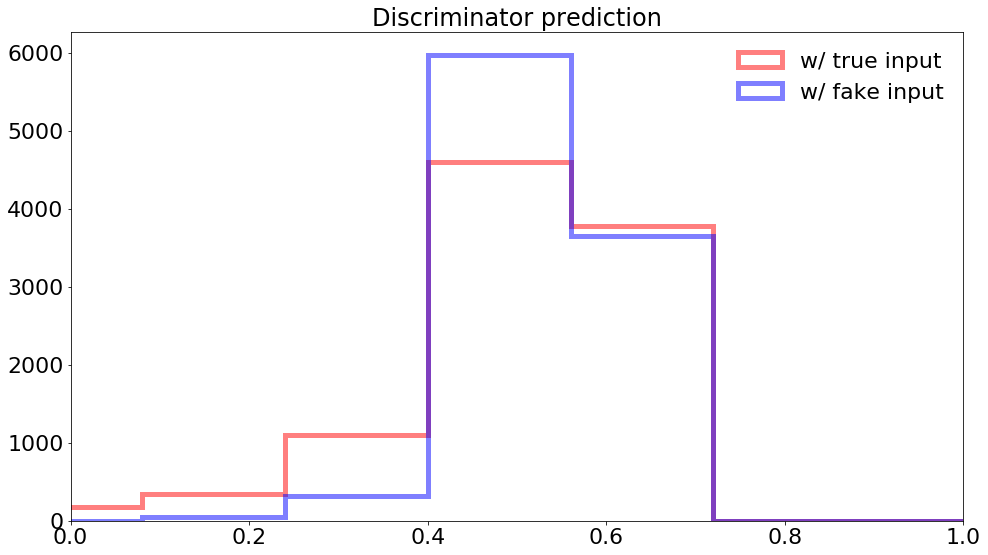

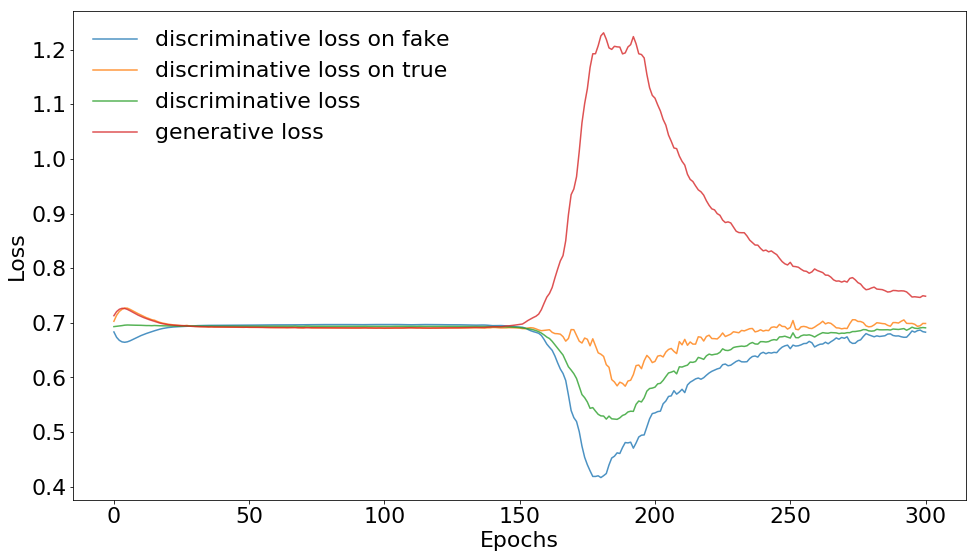

Epoch 401, Discriminator loss:0.694462001324, GAN loss:0.719906568527
For true: mean and s.d. =  -0.00536445521272 0.49827566285
For generator: mean and s.d. =  0.00902178 0.463413


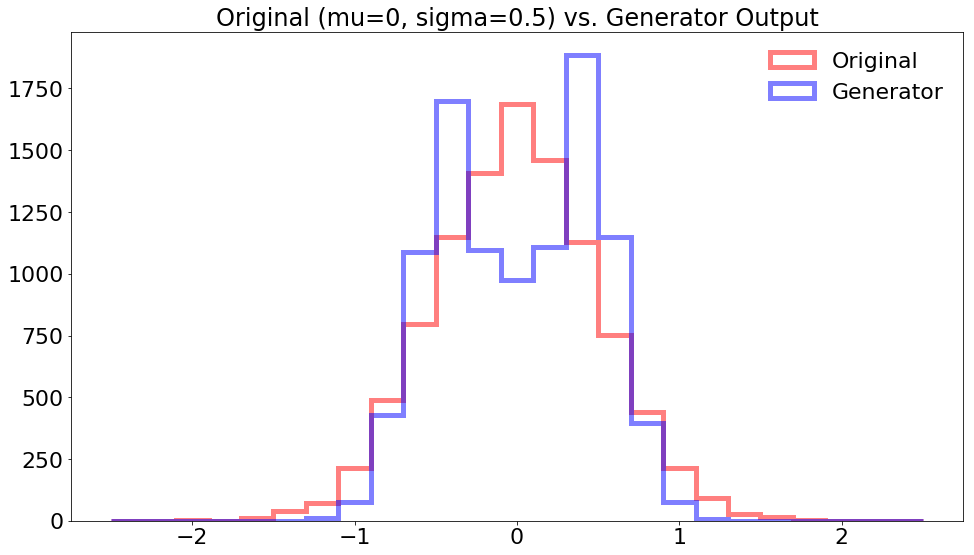

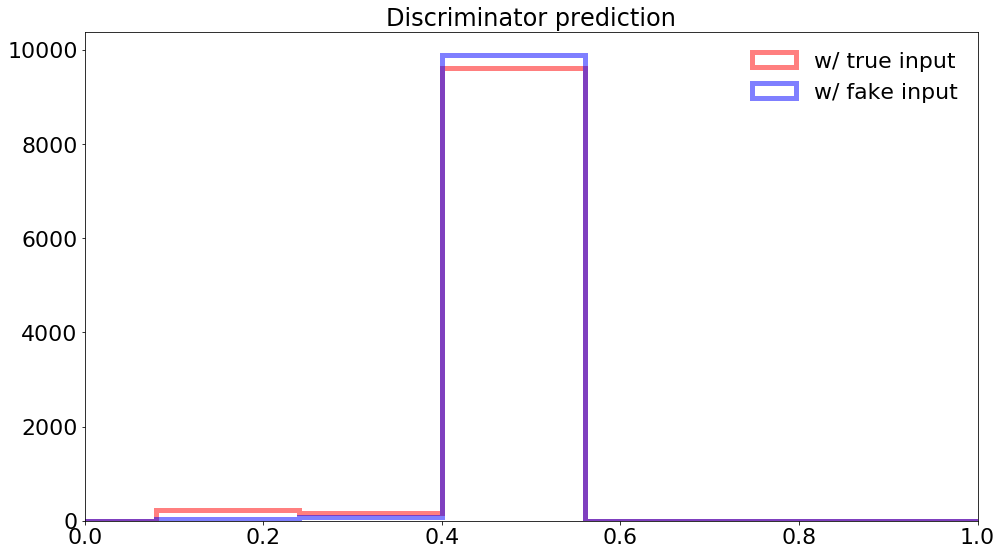

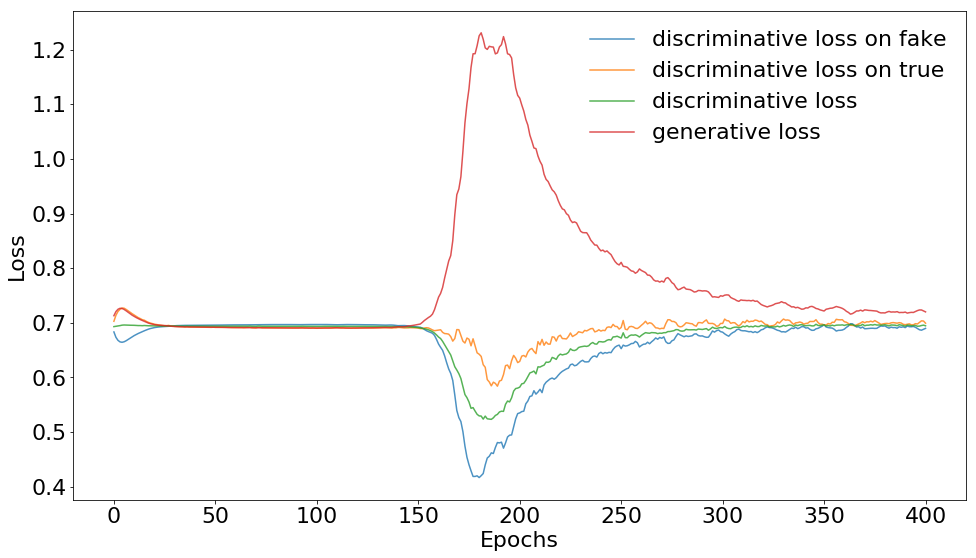

Epoch 501, Discriminator loss:0.679515659809, GAN loss:0.748516798019
For true: mean and s.d. =  0.0140055139401 0.499590670727
For generator: mean and s.d. =  -0.00783789 0.466408


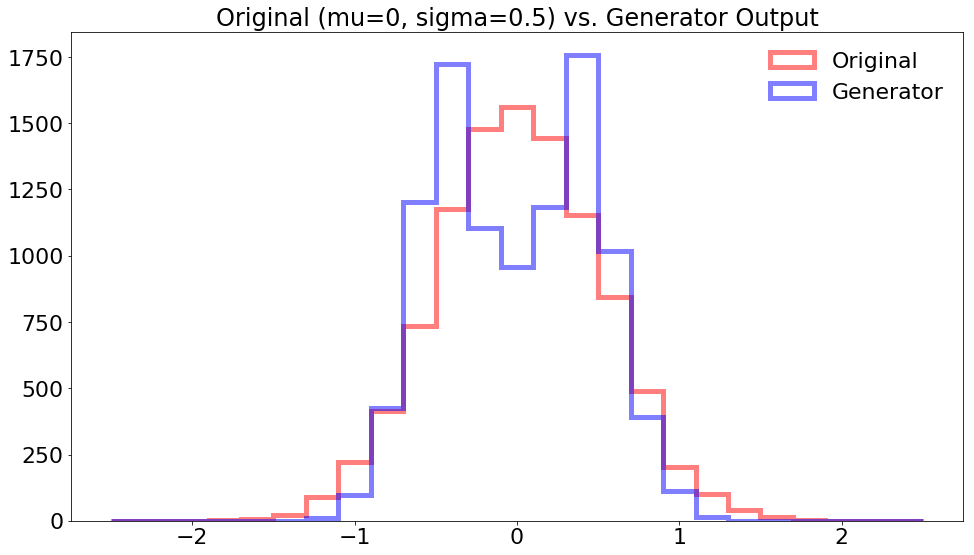

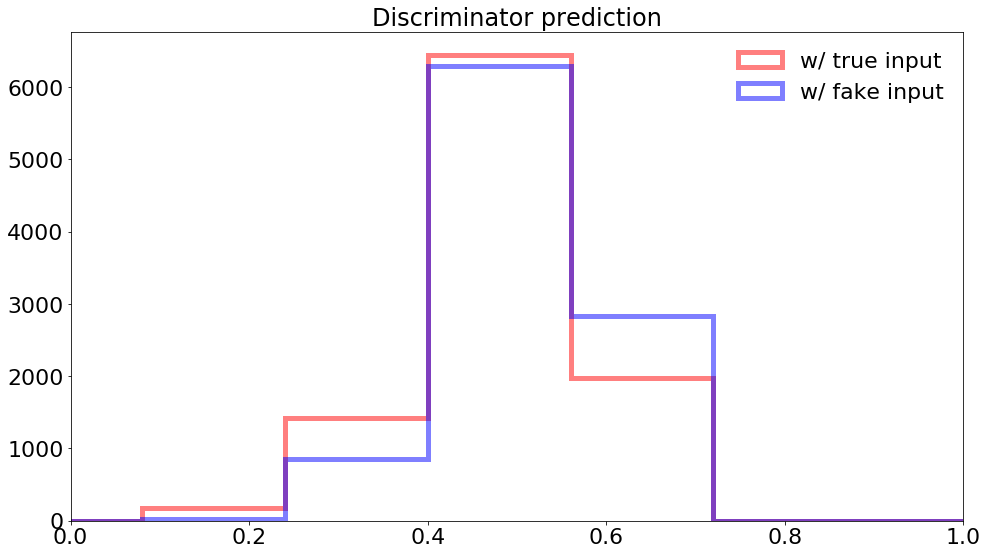

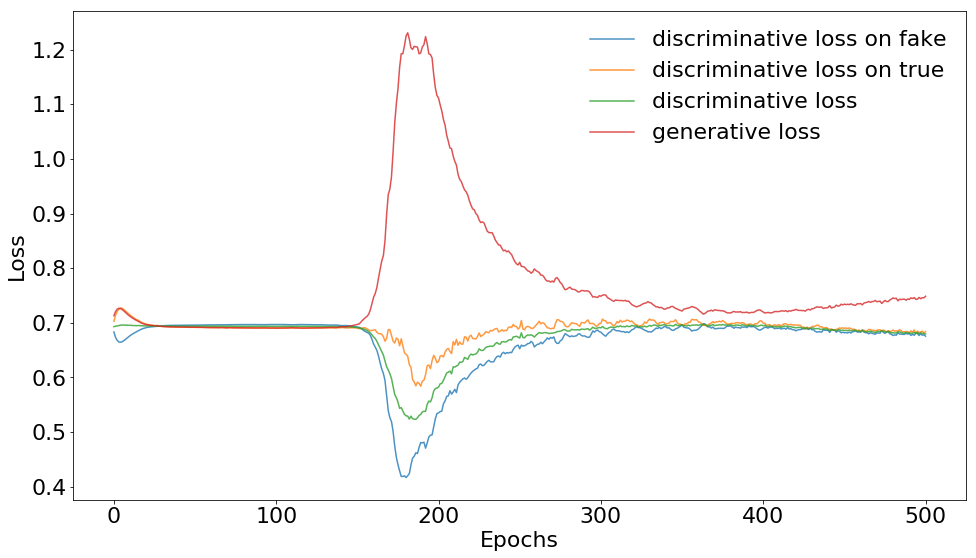

Epoch 601, Discriminator loss:0.681437134743, GAN loss:0.748661875725
For true: mean and s.d. =  0.00773822031891 0.492421725646
For generator: mean and s.d. =  -0.00824885 0.478458


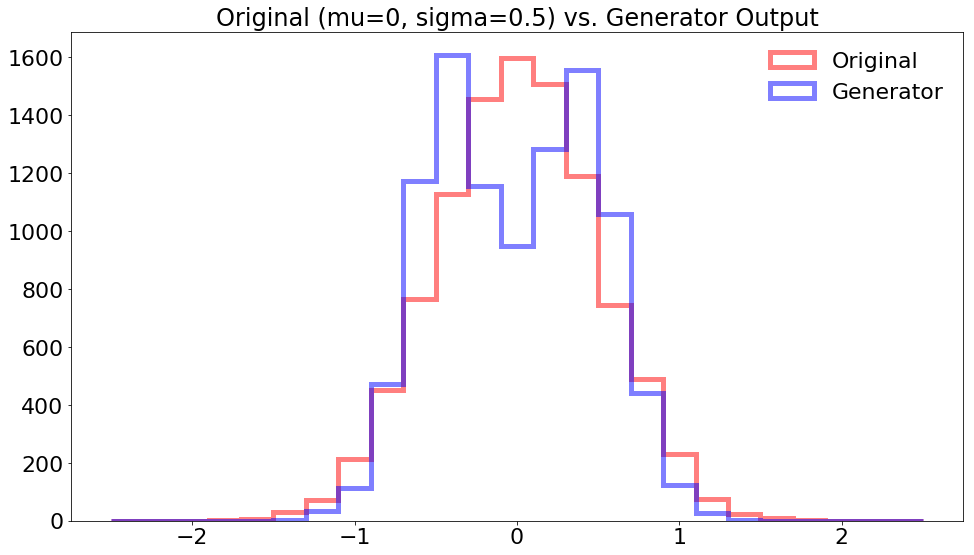

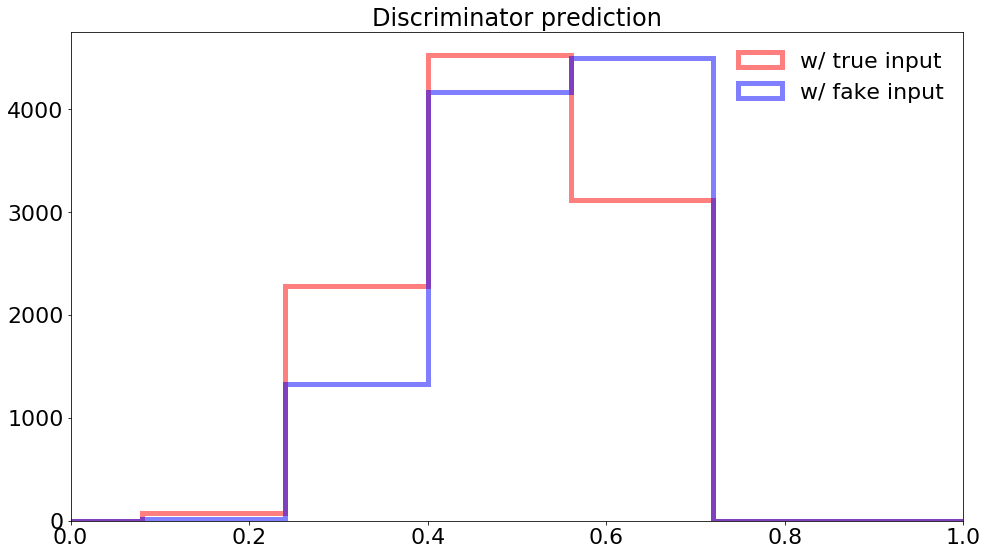

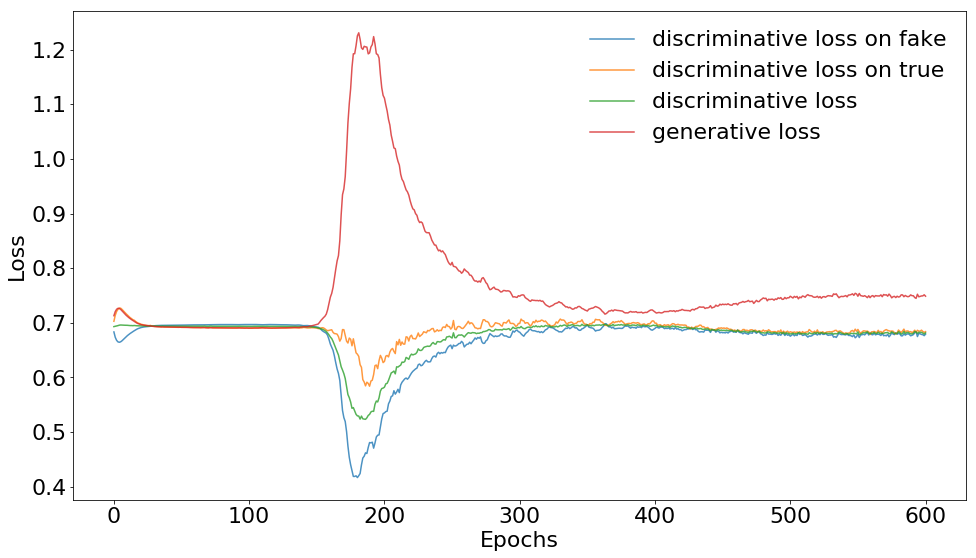

Epoch 701, Discriminator loss:0.687433004379, GAN loss:0.73936522007
For true: mean and s.d. =  -0.00822687769169 0.499325103892
For generator: mean and s.d. =  -0.00301511 0.490448


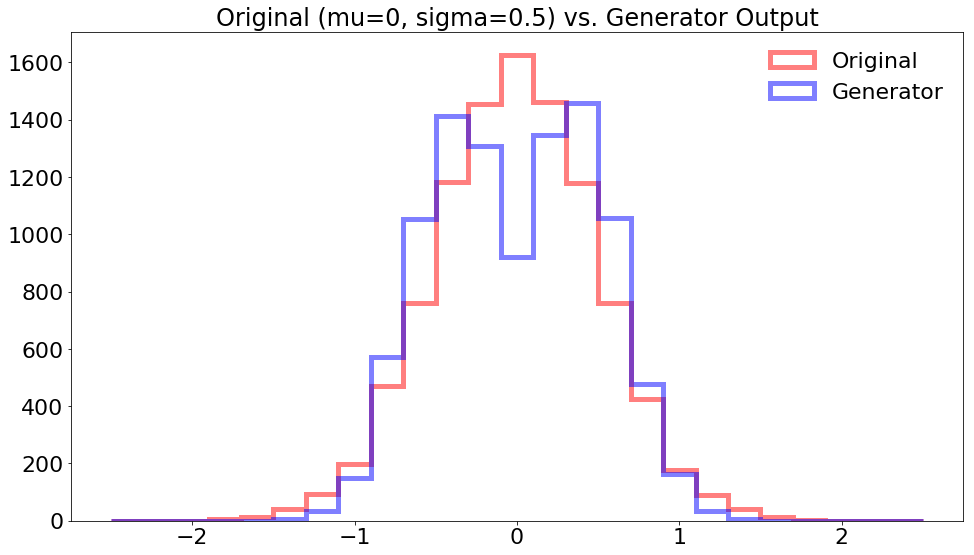

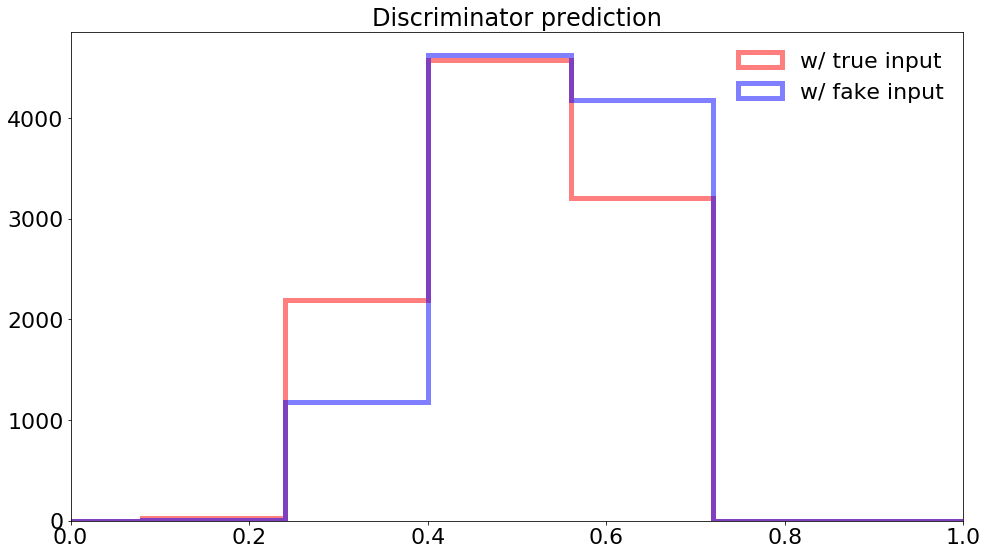

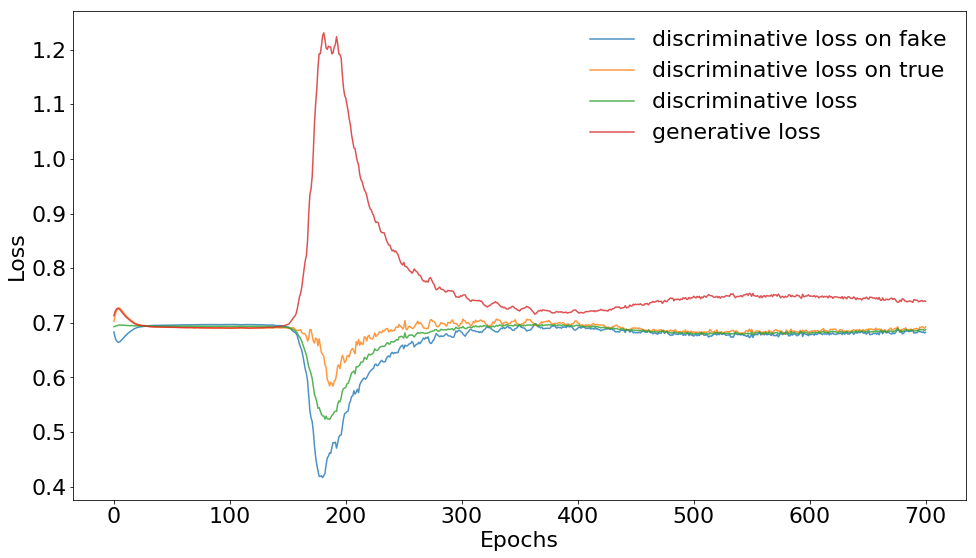

Epoch 801, Discriminator loss:0.689985394478, GAN loss:0.725875854492
For true: mean and s.d. =  -0.00163566593869 0.498641419308
For generator: mean and s.d. =  0.000129468 0.492222


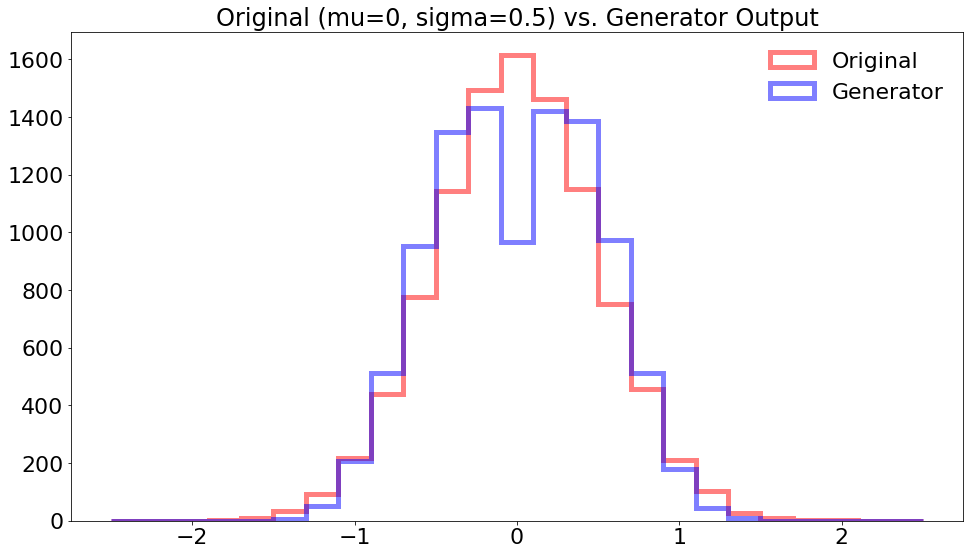

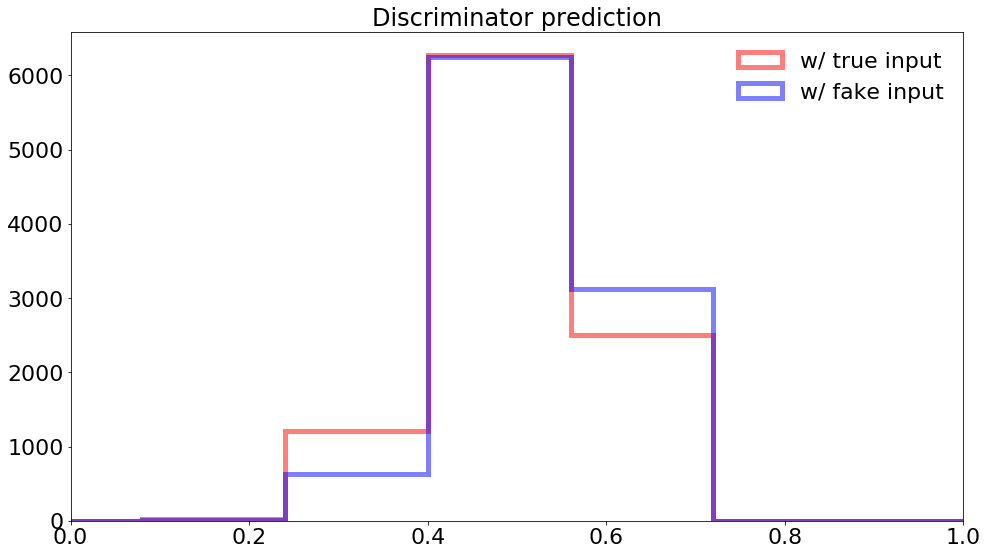

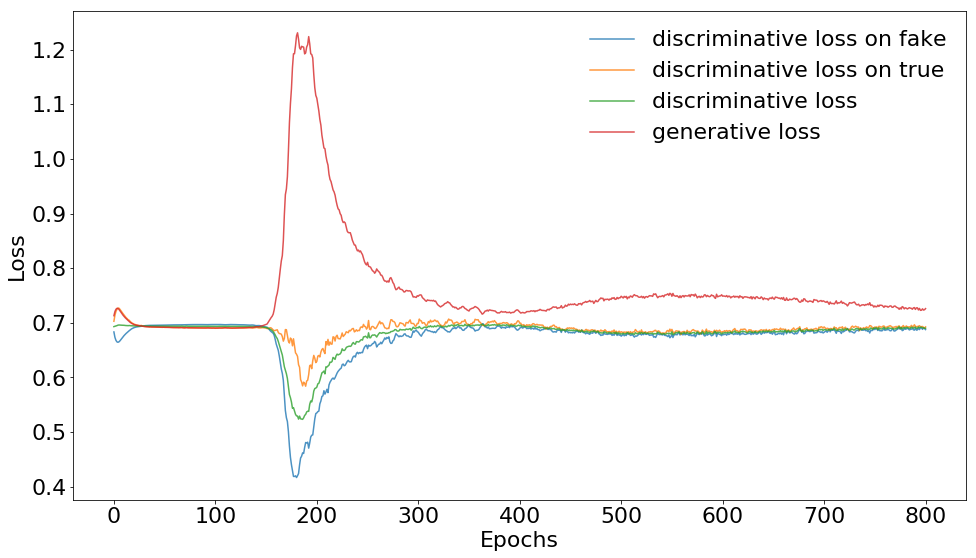

Epoch 901, Discriminator loss:0.693992376328, GAN loss:0.713232338428
For true: mean and s.d. =  -0.00709658554825 0.501315002651
For generator: mean and s.d. =  0.0080043 0.487704


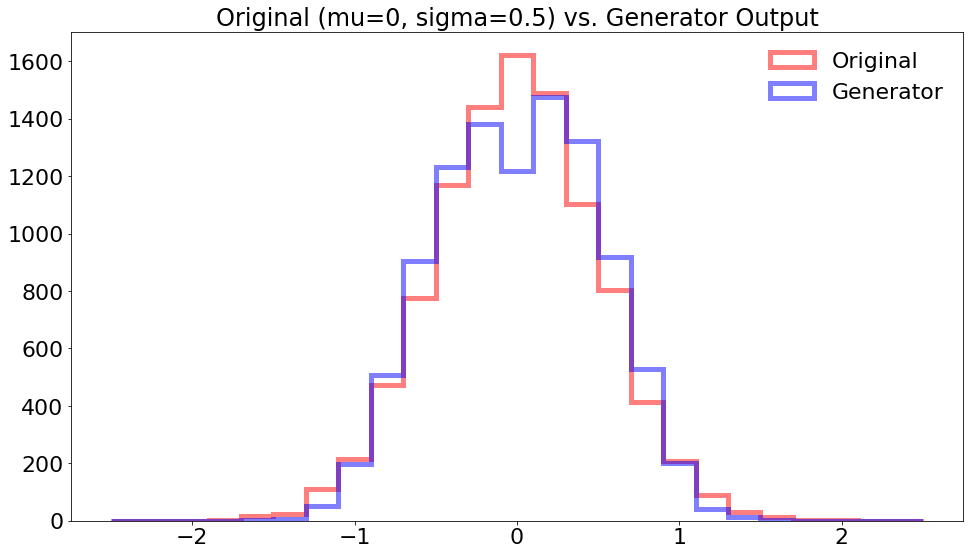

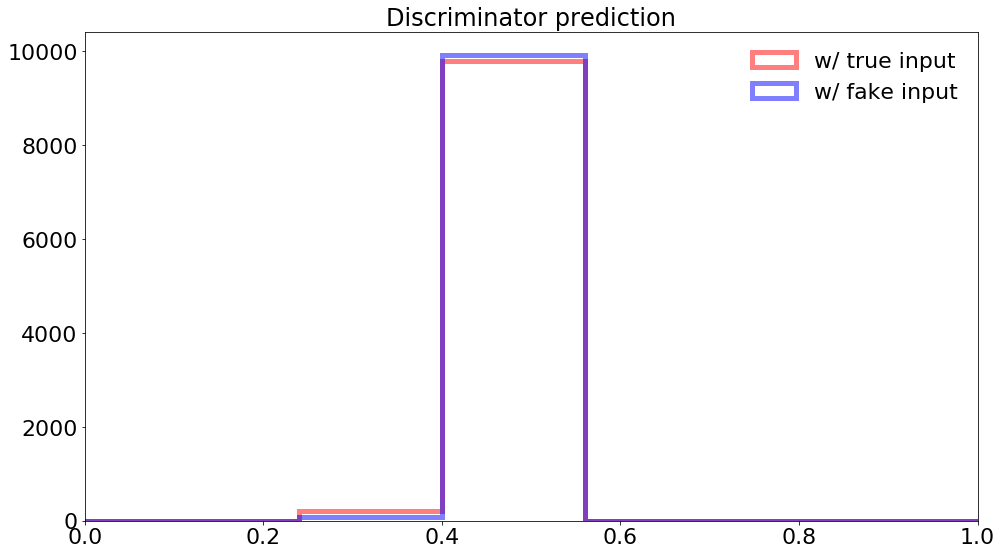

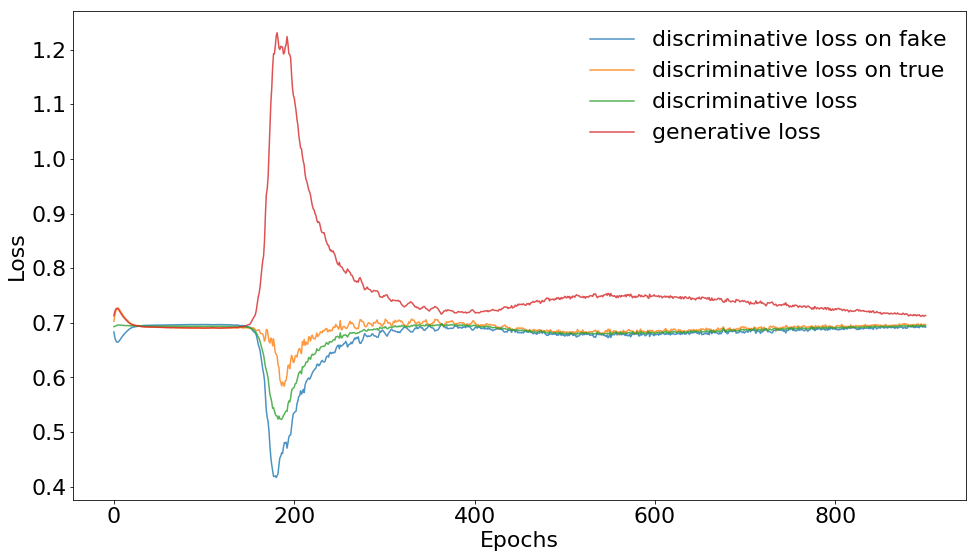

Epoch 1001, Discriminator loss:0.69570094347, GAN loss:0.706269741058
For true: mean and s.d. =  0.00136840266597 0.49498477274
For generator: mean and s.d. =  0.000186292 0.487959


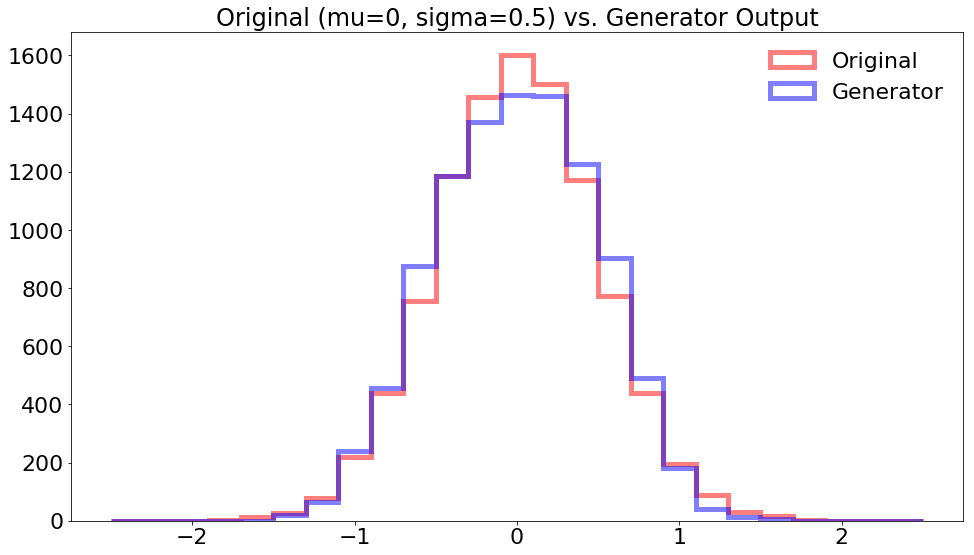

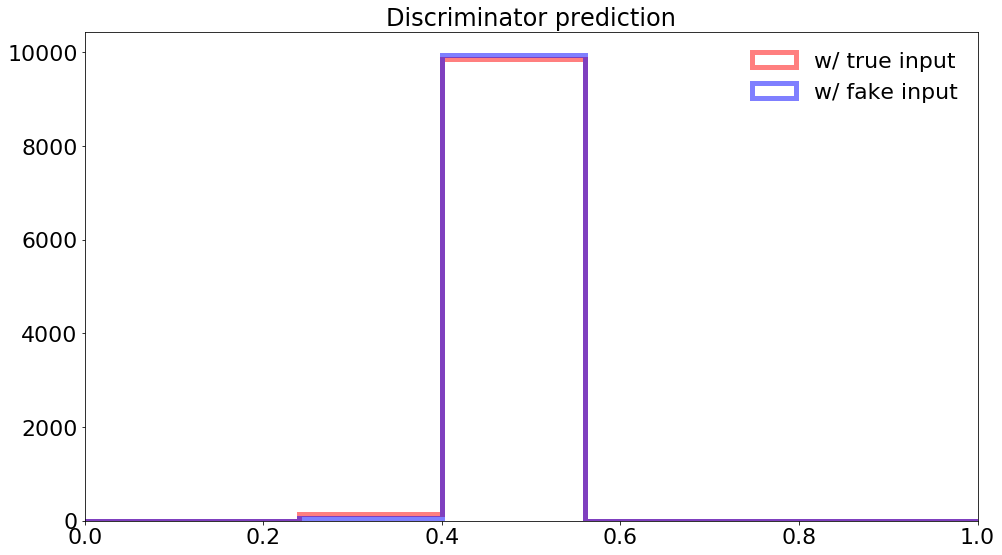

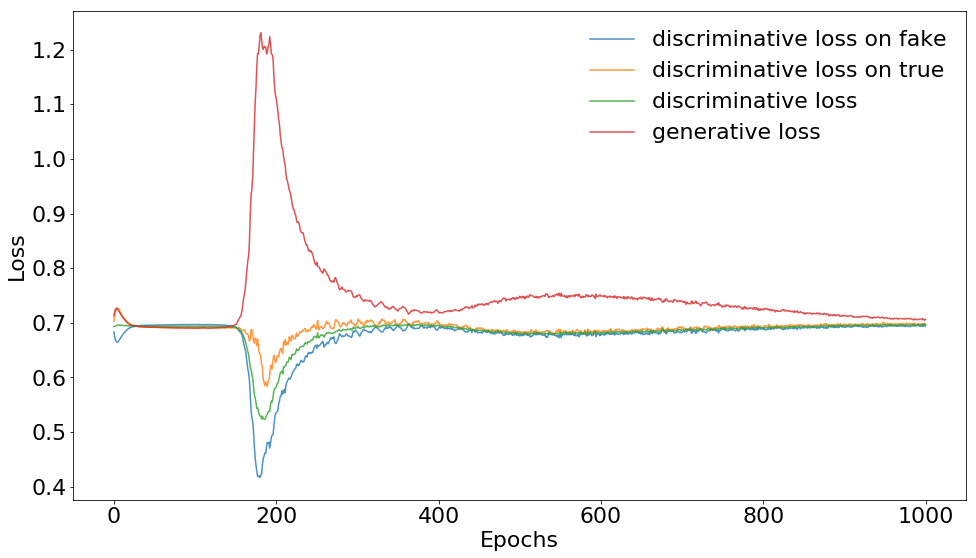

Epoch 1101, Discriminator loss:0.696580886841, GAN loss:0.703609764576
For true: mean and s.d. =  0.00713944764259 0.49976856409
For generator: mean and s.d. =  0.00786899 0.493122


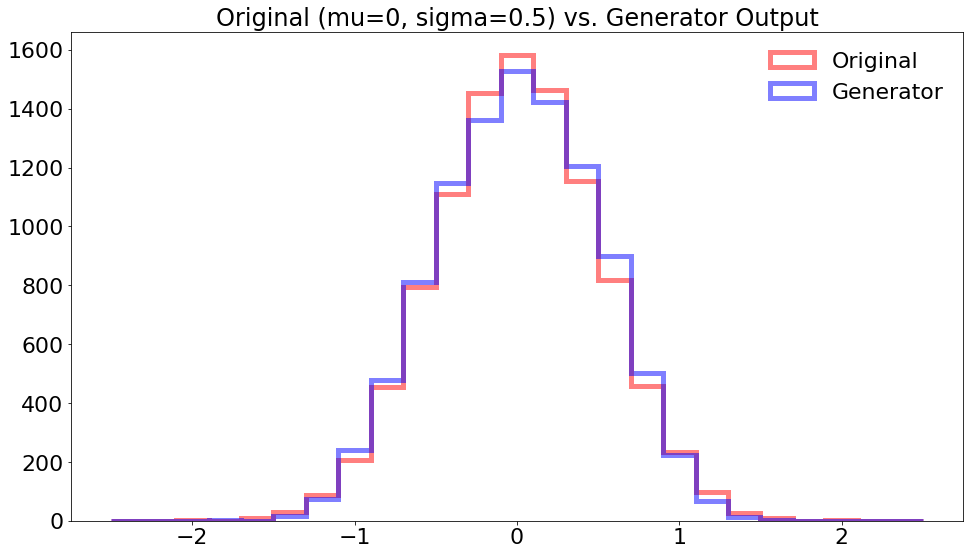

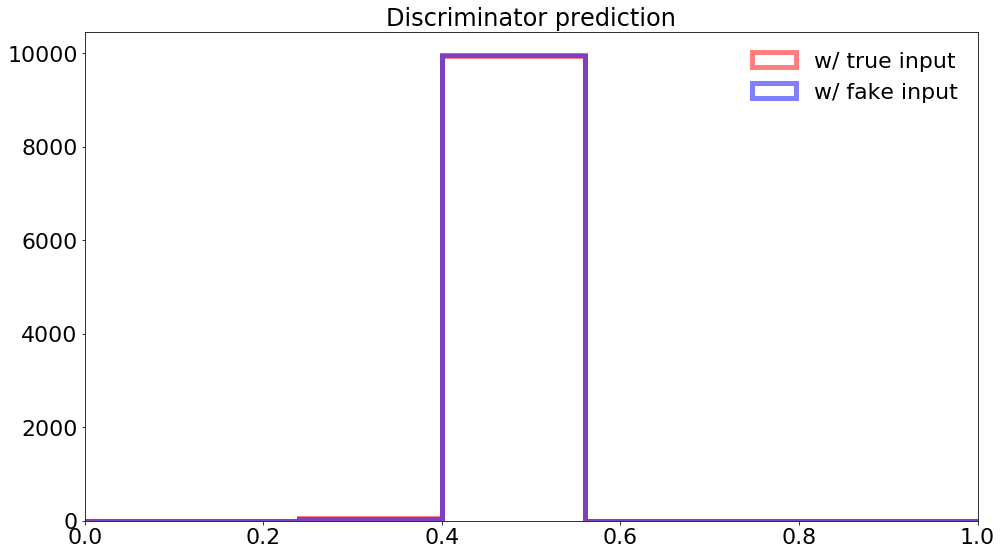

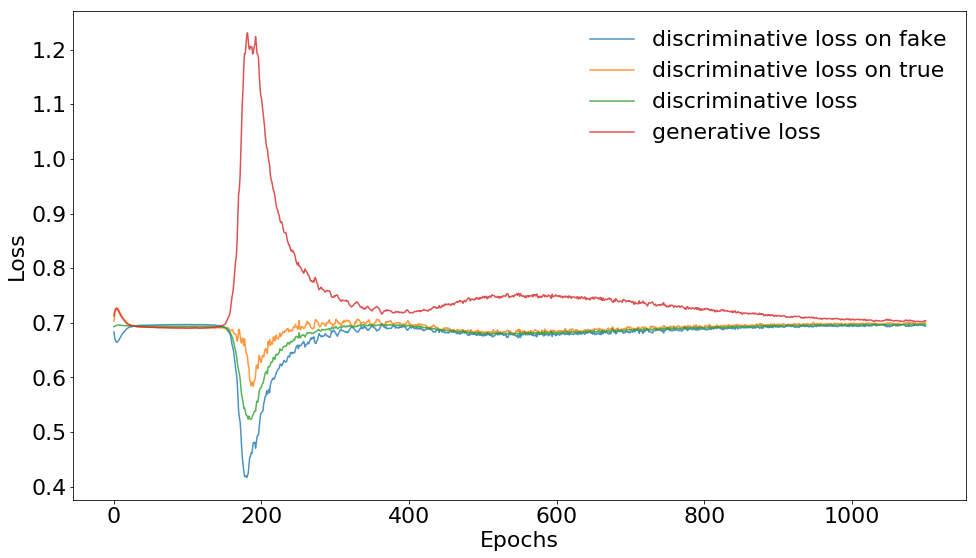

Epoch 1201, Discriminator loss:0.69685125351, GAN loss:0.70029592514
For true: mean and s.d. =  -0.00132194436971 0.496681272959
For generator: mean and s.d. =  -0.000326147 0.49234


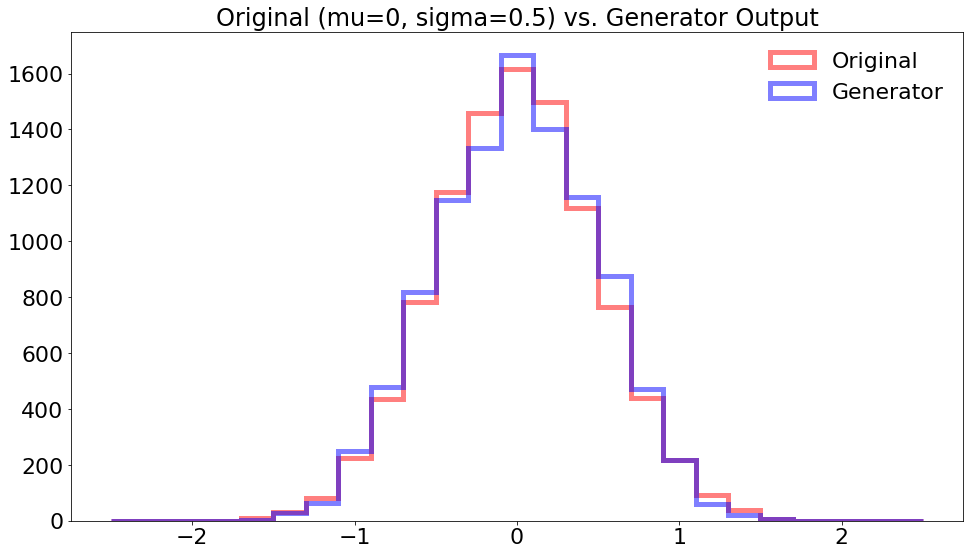

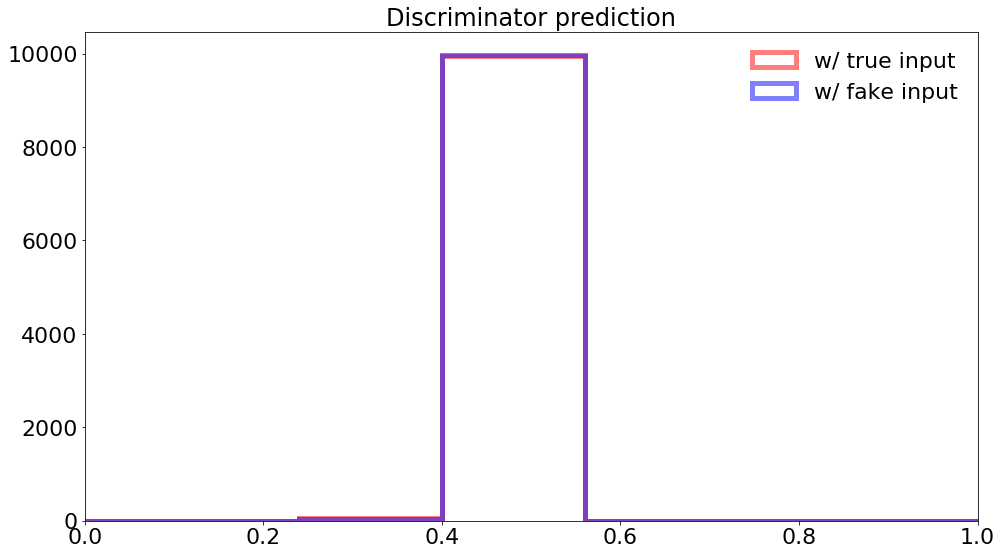

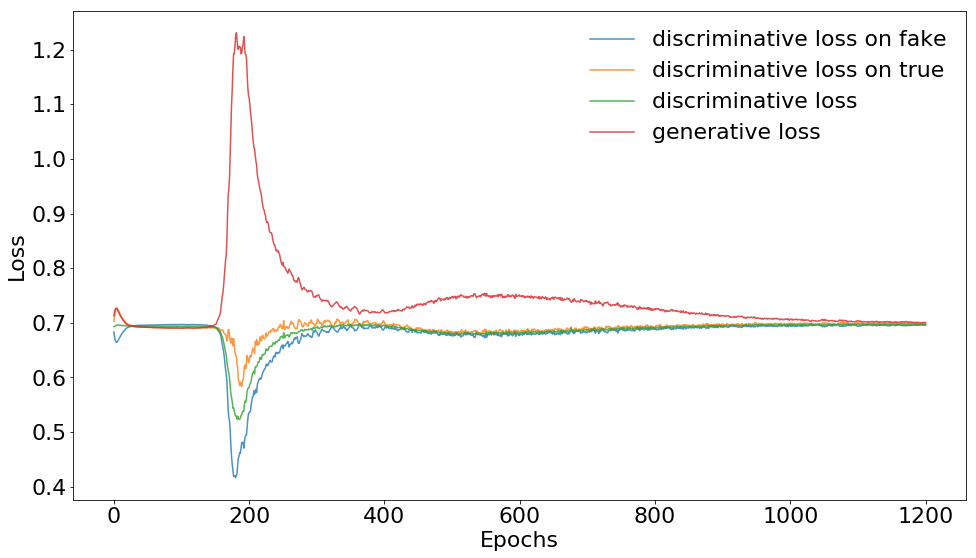

Epoch 1301, Discriminator loss:0.696941196918, GAN loss:0.700447976589
For true: mean and s.d. =  0.000669523790139 0.502353969343
For generator: mean and s.d. =  0.00714224 0.497657


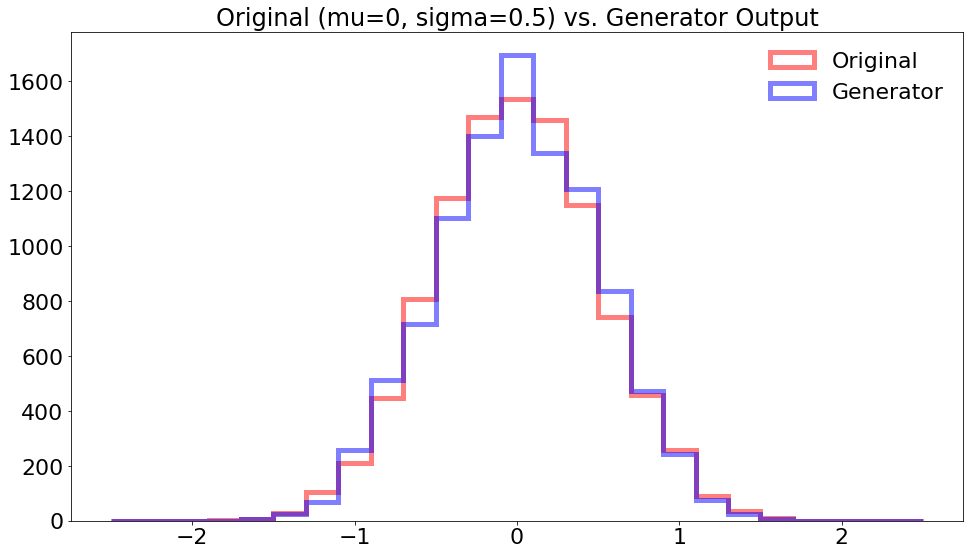

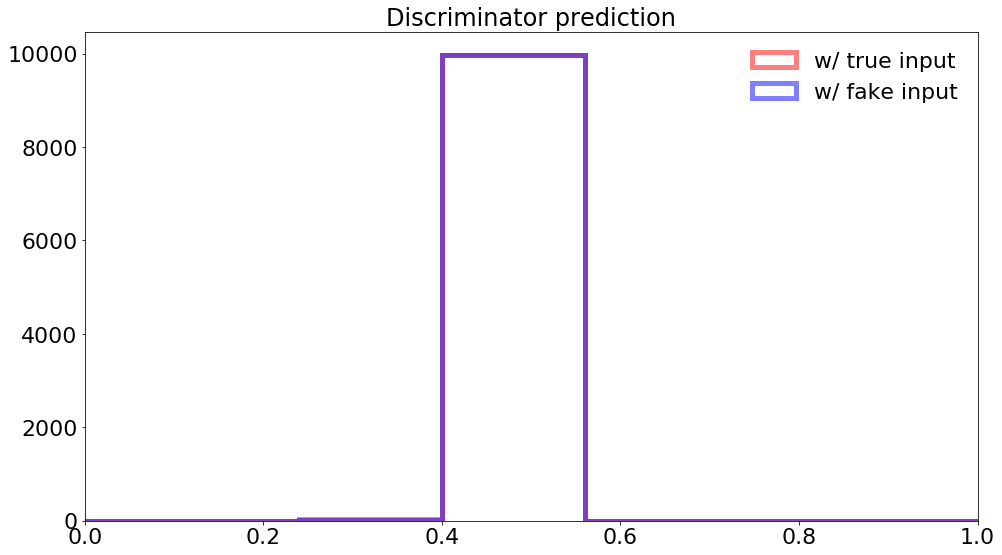

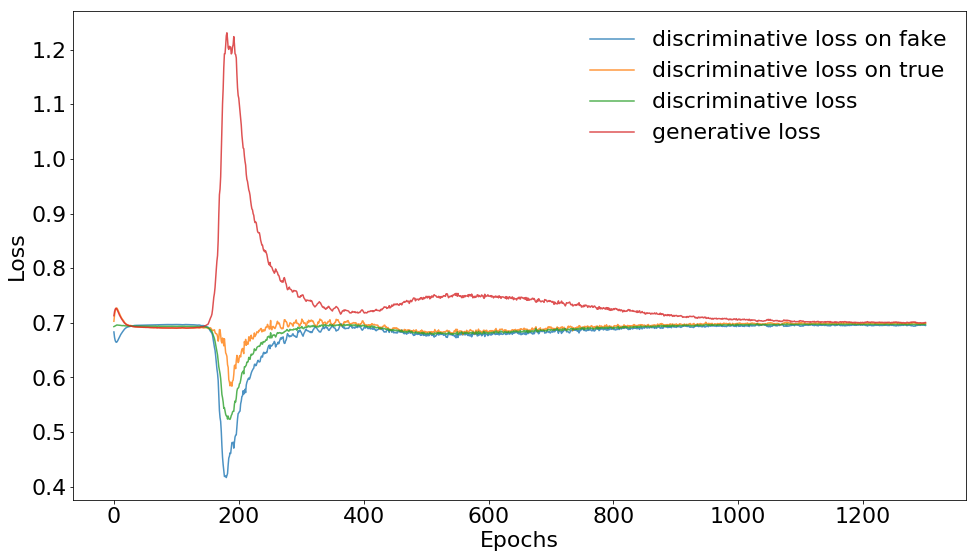

Epoch 1401, Discriminator loss:0.69638466835, GAN loss:0.699437737465
For true: mean and s.d. =  -0.00531251799823 0.505045553797
For generator: mean and s.d. =  0.0038428 0.496182


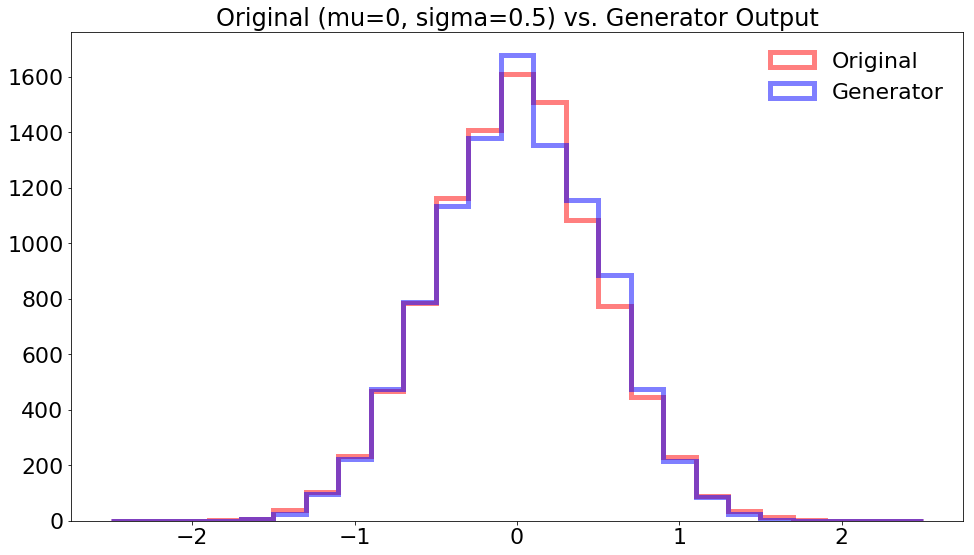

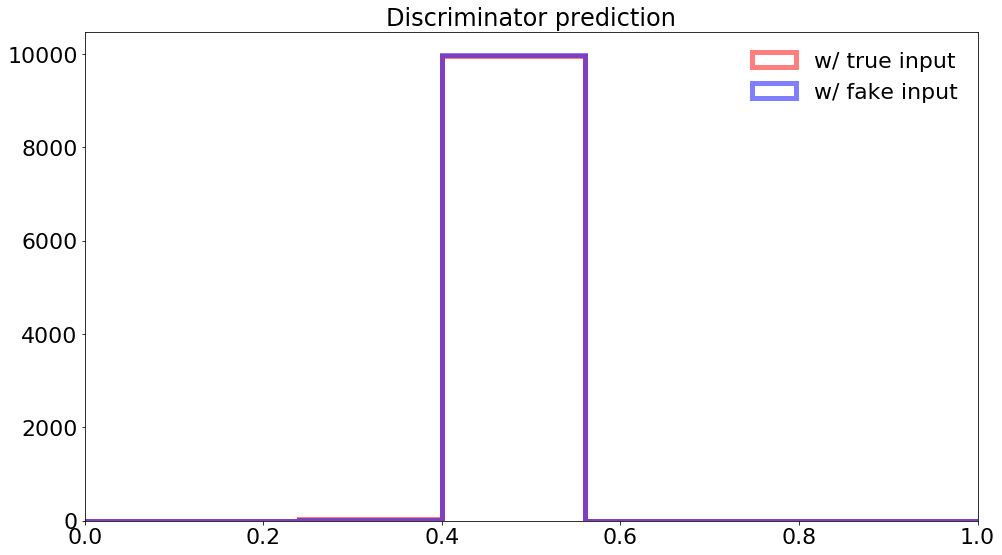

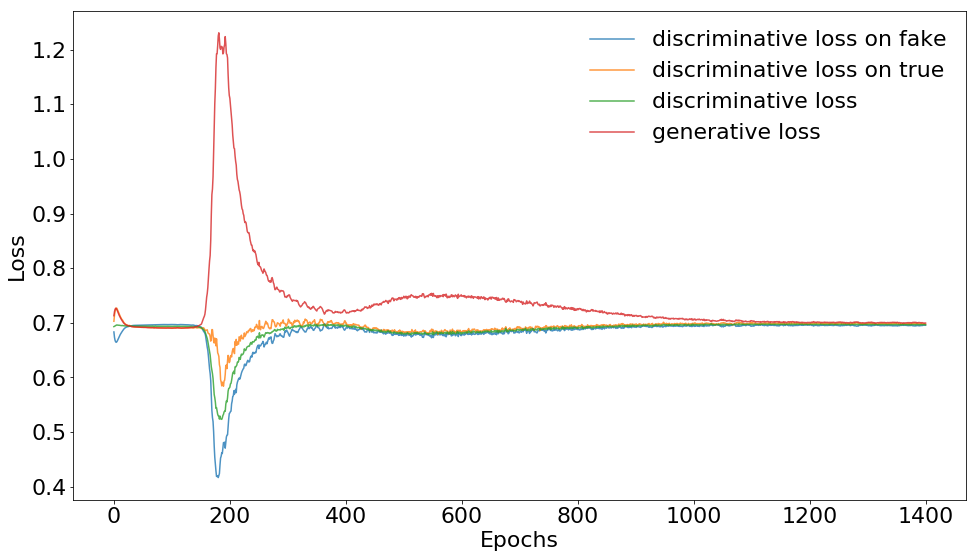

Epoch 1501, Discriminator loss:0.69650053978, GAN loss:0.699170410633
For true: mean and s.d. =  0.00550238197397 0.497950851975
For generator: mean and s.d. =  -0.000288586 0.496367


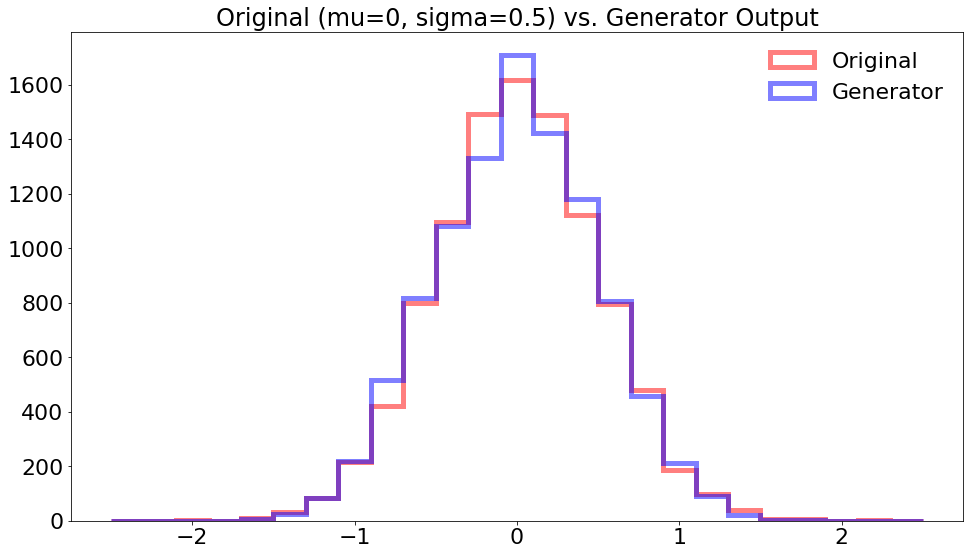

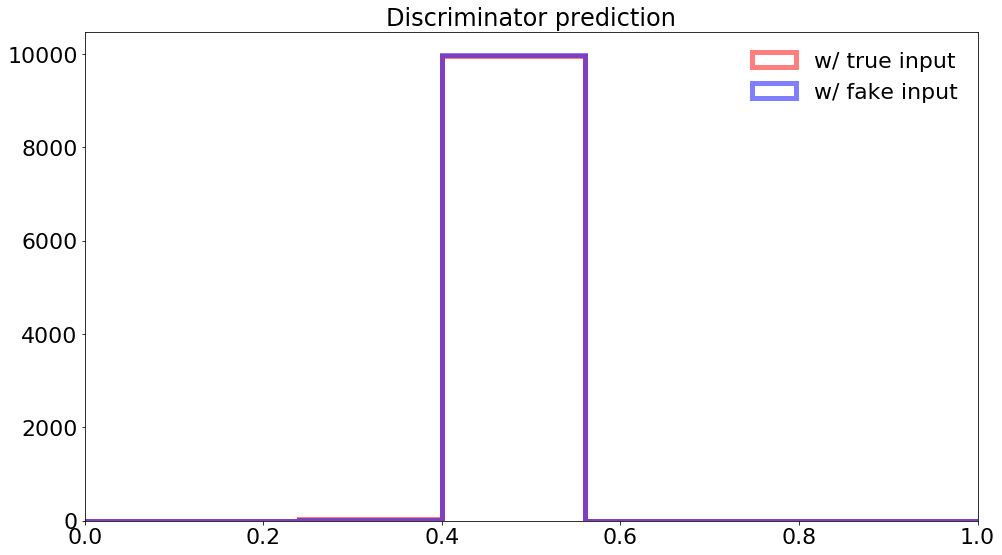

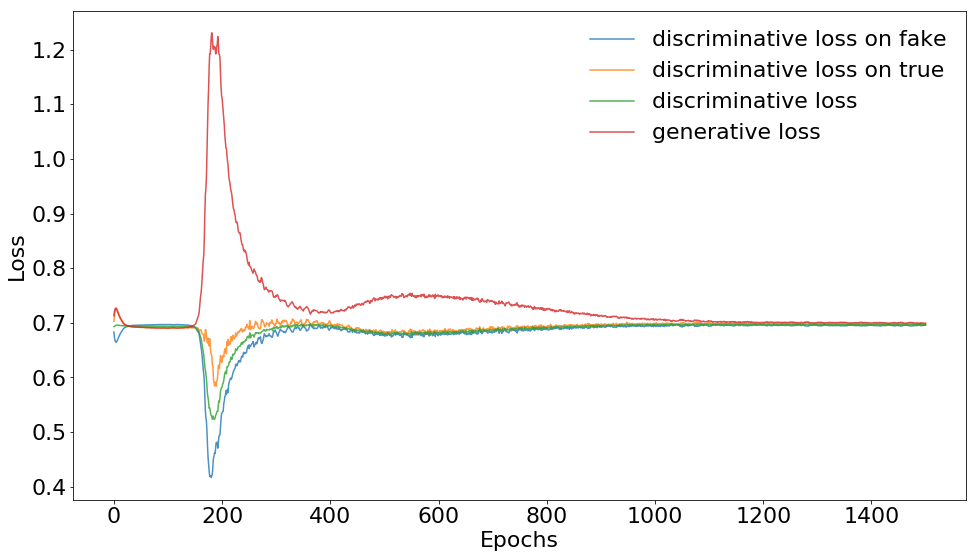

Epoch 1601, Discriminator loss:0.696447193623, GAN loss:0.698626101017
For true: mean and s.d. =  -0.00579965523279 0.497870186316
For generator: mean and s.d. =  -0.00714666 0.500952


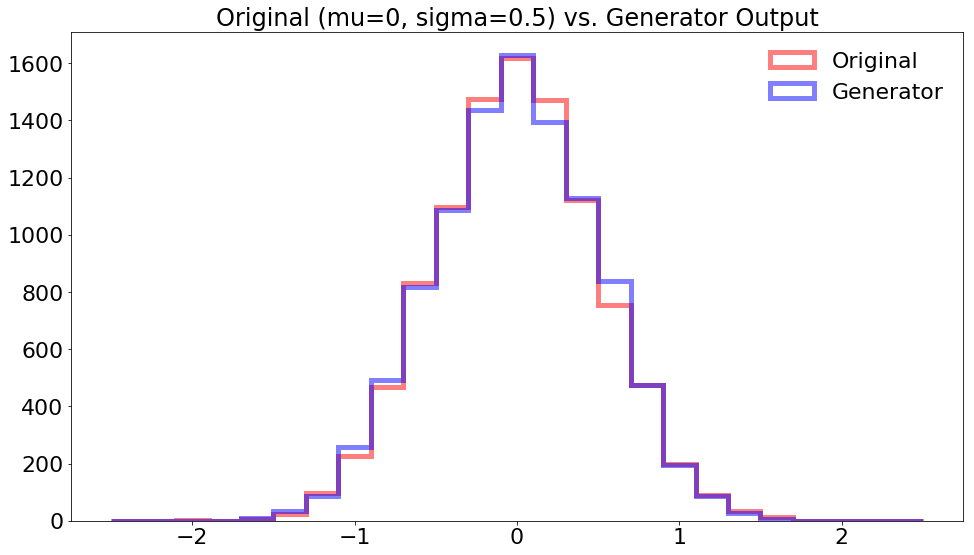

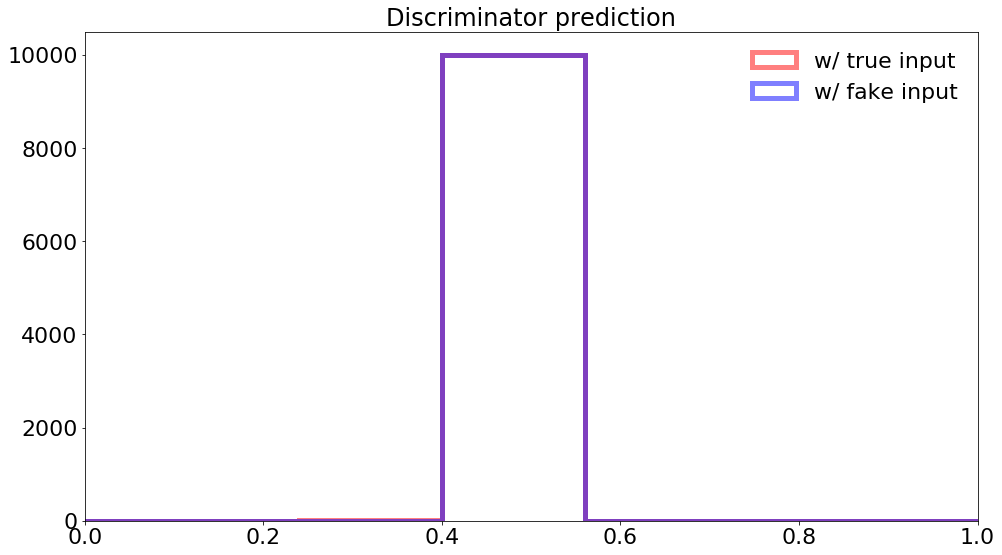

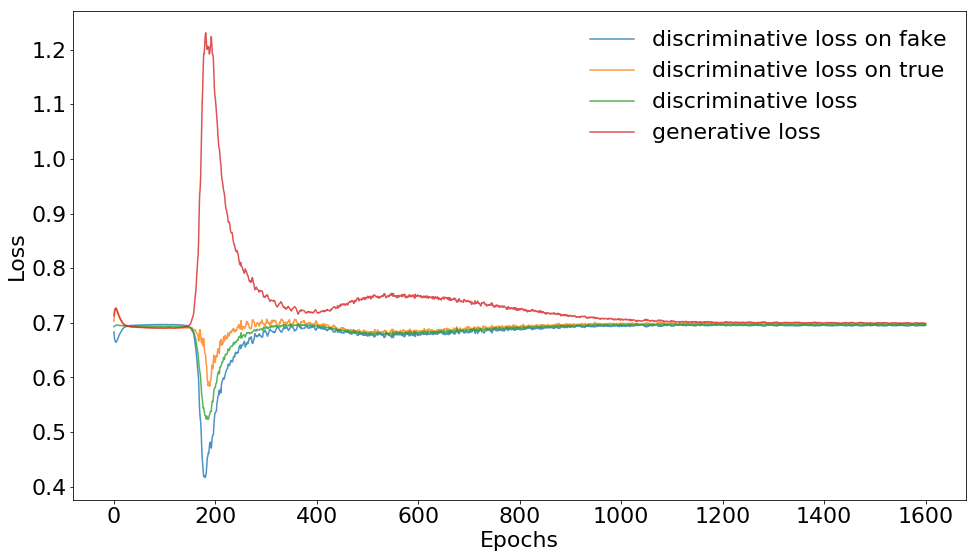

Epoch 1701, Discriminator loss:0.696288824081, GAN loss:0.698699235916
For true: mean and s.d. =  -0.00161593058148 0.501615972306
For generator: mean and s.d. =  -0.0118261 0.499516


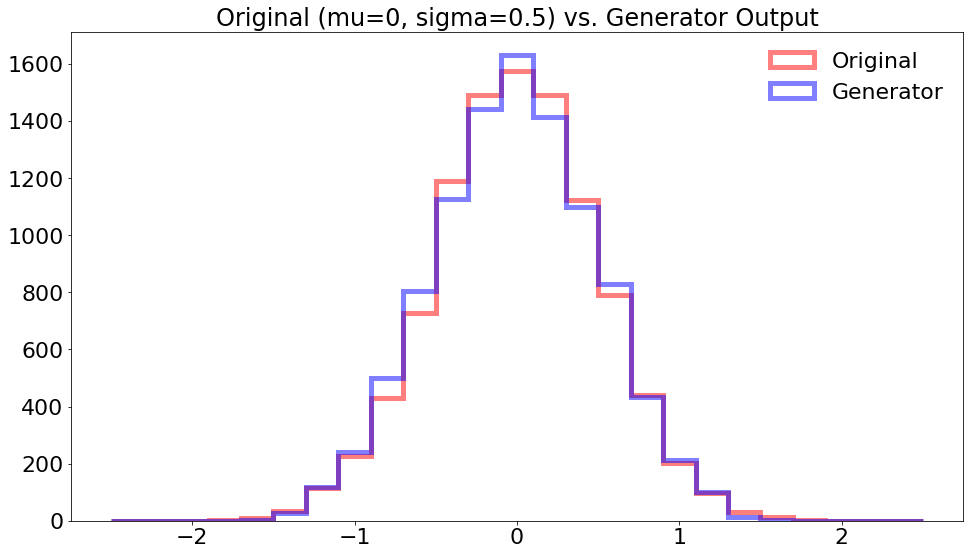

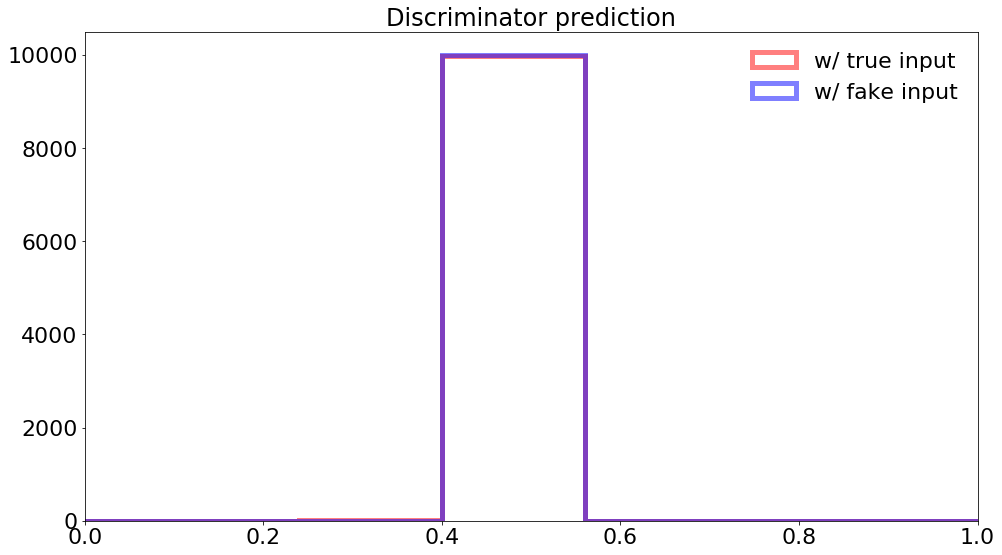

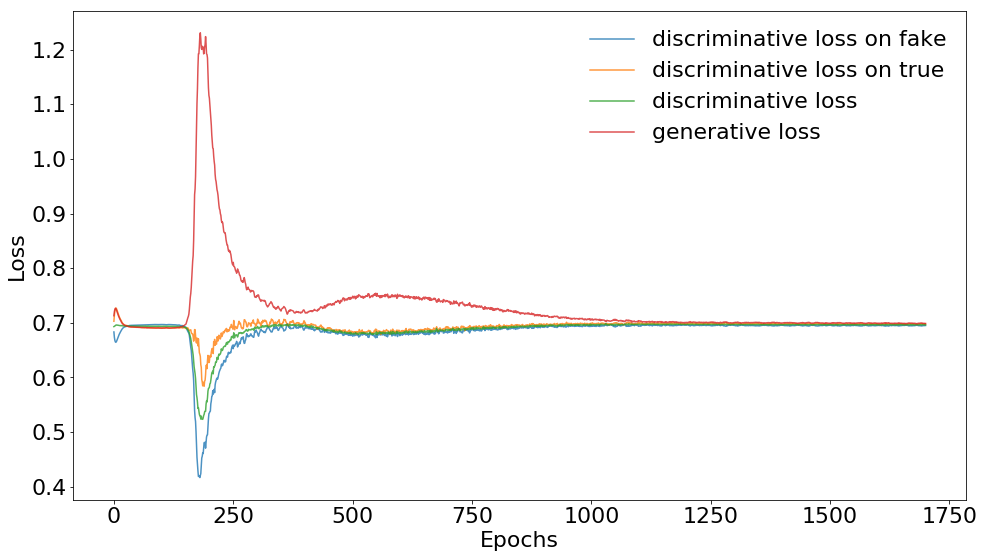

Epoch 1801, Discriminator loss:0.696081280708, GAN loss:0.69916921854
For true: mean and s.d. =  -0.00167751661701 0.49734923781
For generator: mean and s.d. =  -0.00710088 0.495839


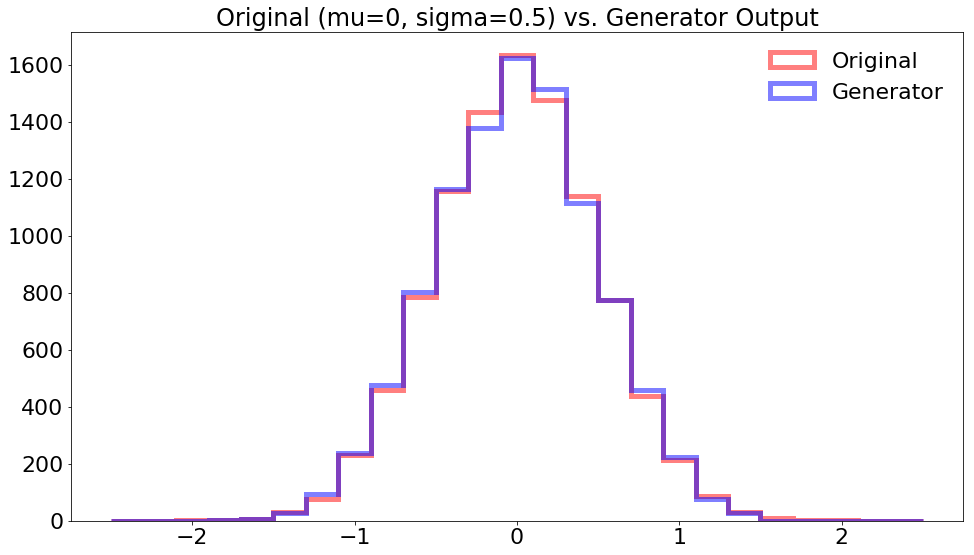

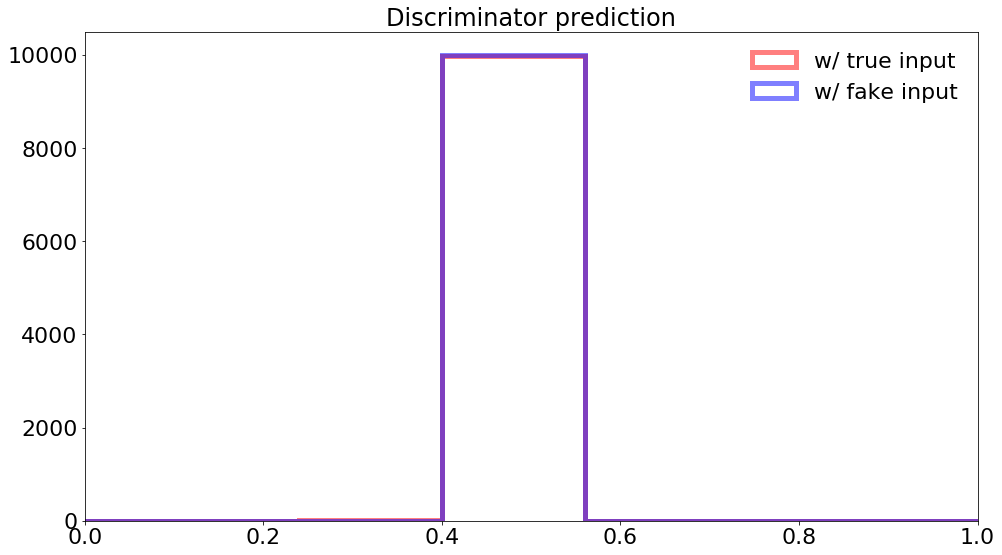

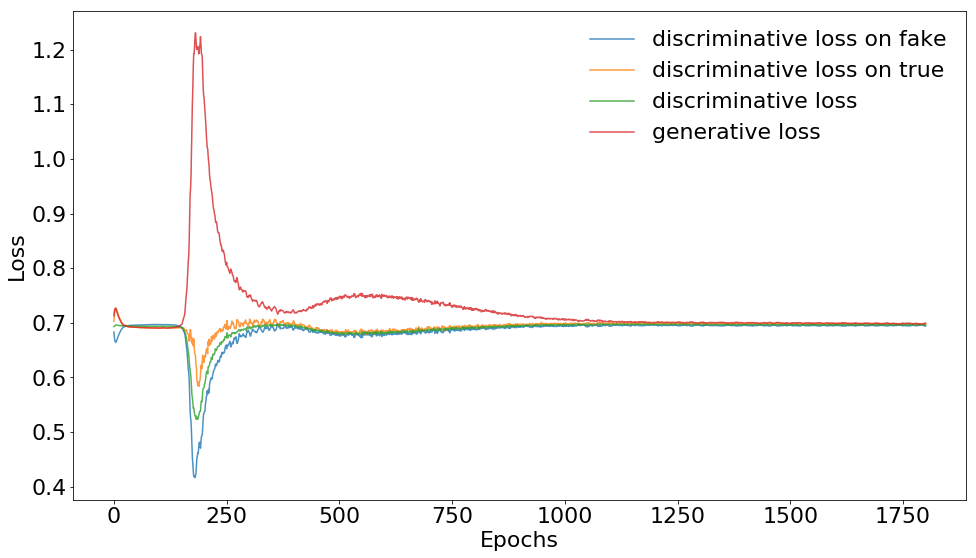

Epoch 1901, Discriminator loss:0.695942640305, GAN loss:0.697965502739
For true: mean and s.d. =  0.00066894340317 0.499109741833
For generator: mean and s.d. =  0.00522411 0.500185


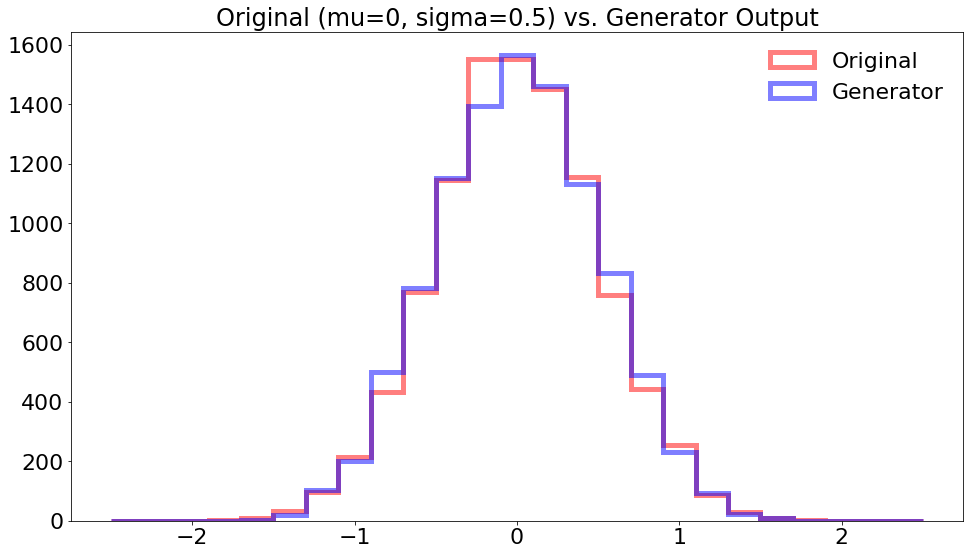

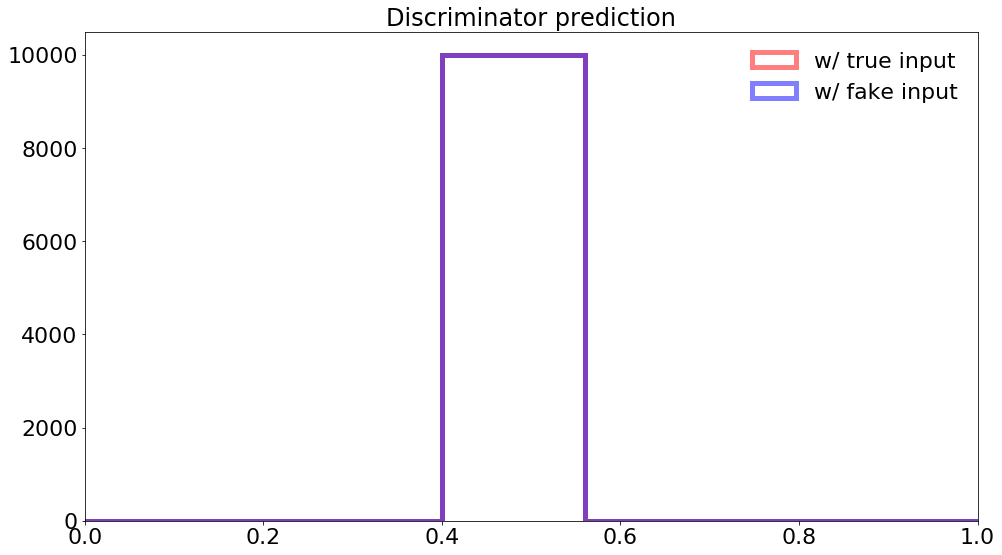

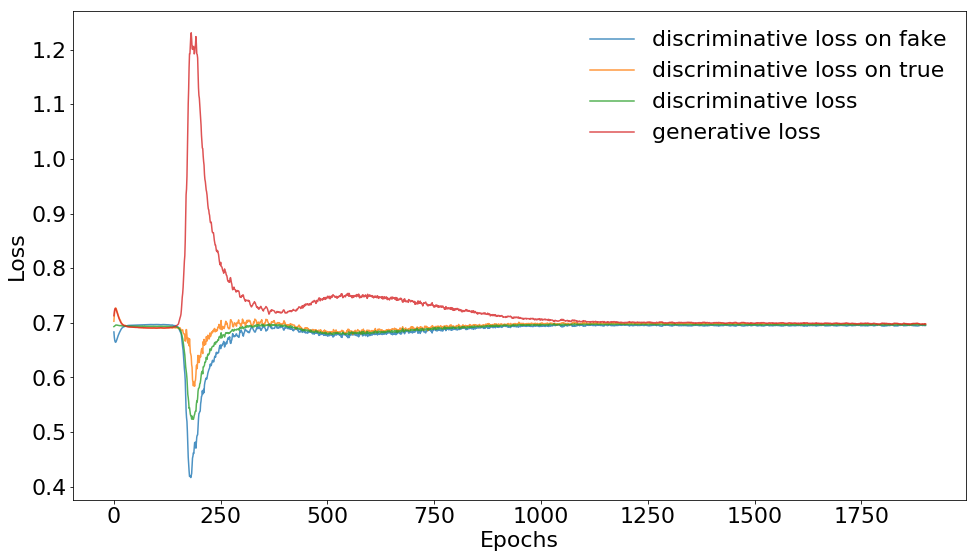

Epoch 2001, Discriminator loss:0.696052908897, GAN loss:0.697573423386
For true: mean and s.d. =  0.00970967656867 0.498051385543
For generator: mean and s.d. =  -0.000160339 0.493937


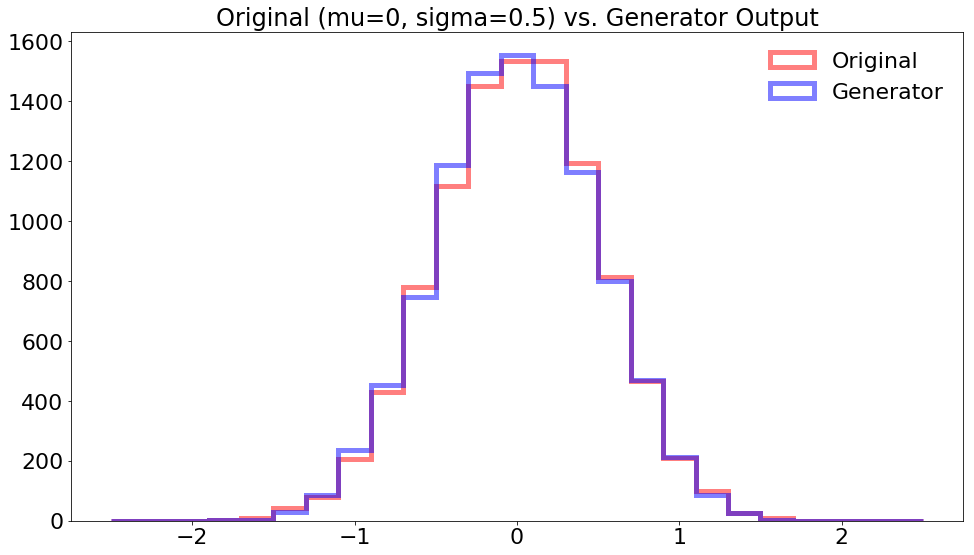

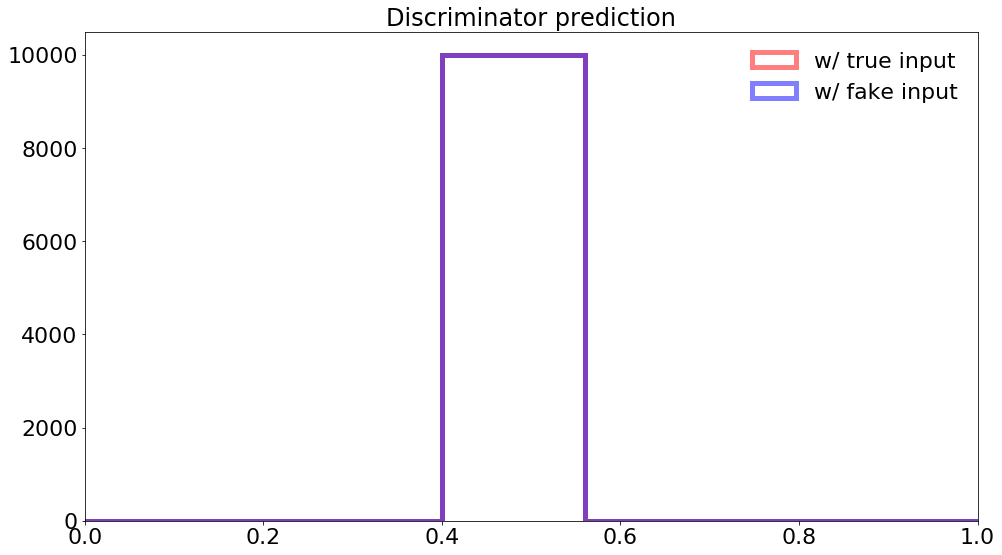

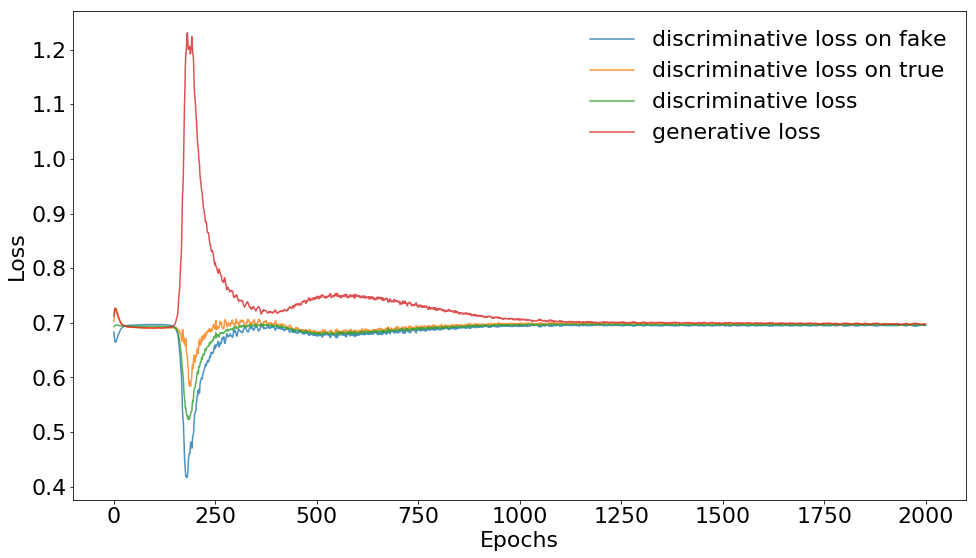

Epoch 2101, Discriminator loss:0.69601392746, GAN loss:0.697690546513
For true: mean and s.d. =  0.000955871803313 0.500008734575
For generator: mean and s.d. =  -0.00239714 0.495271


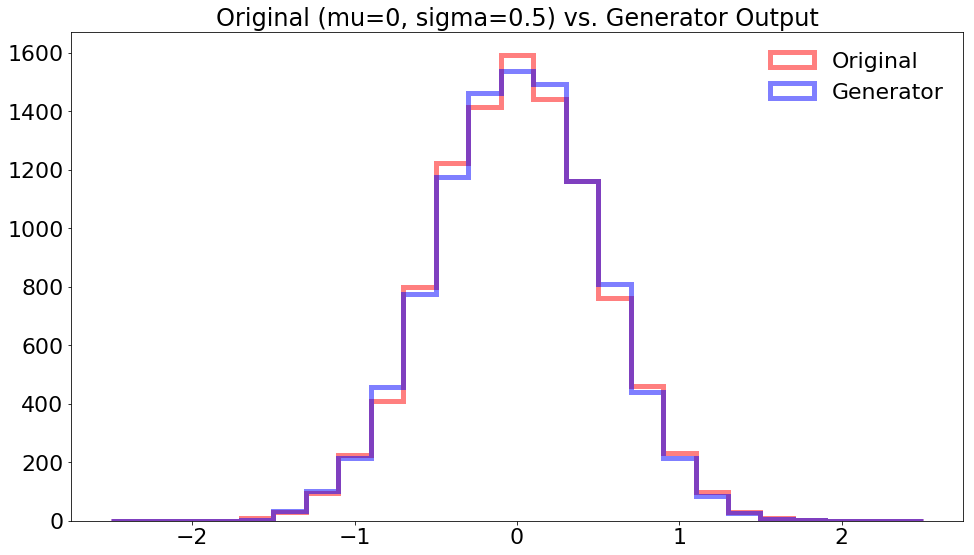

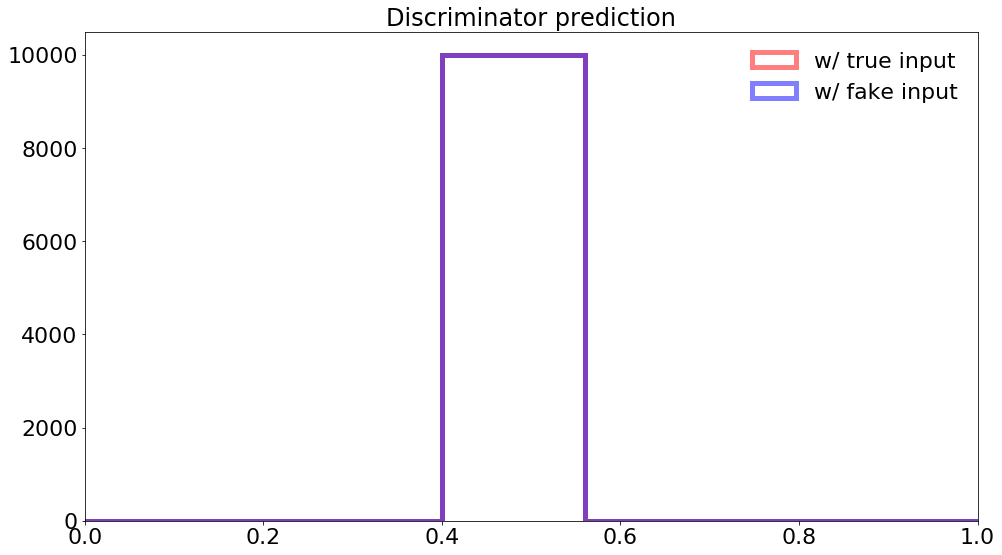

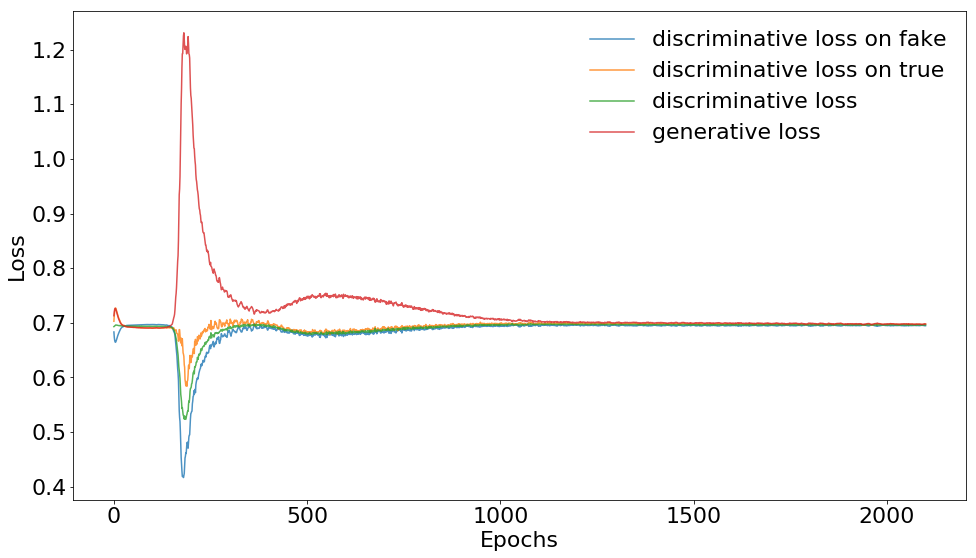

Epoch 2201, Discriminator loss:0.696027219296, GAN loss:0.697181463242
For true: mean and s.d. =  -0.00217506383955 0.500953942155
For generator: mean and s.d. =  -0.00103203 0.495468


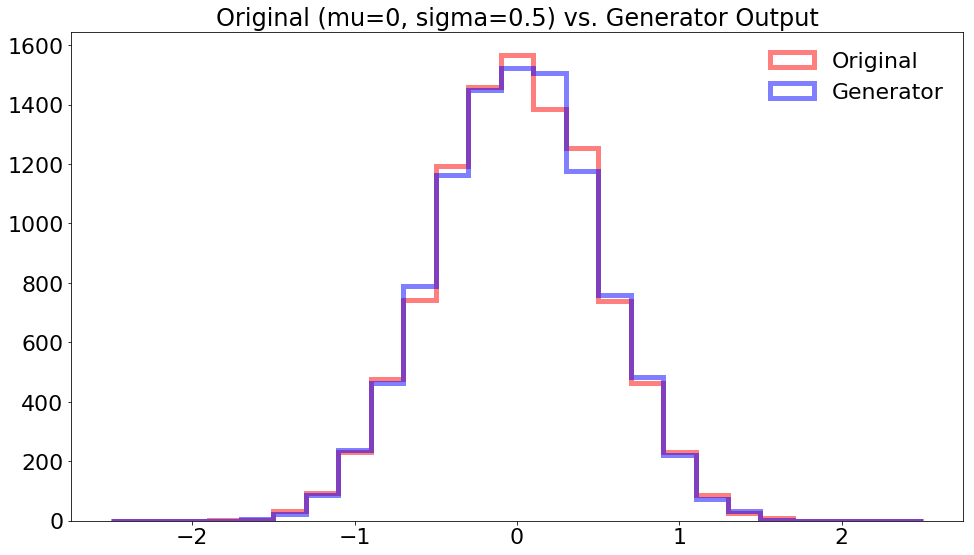

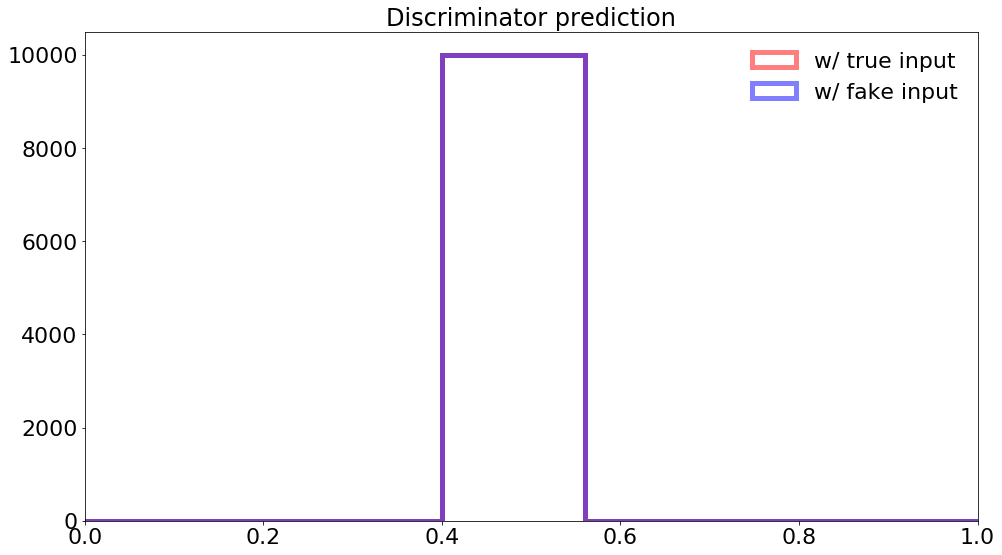

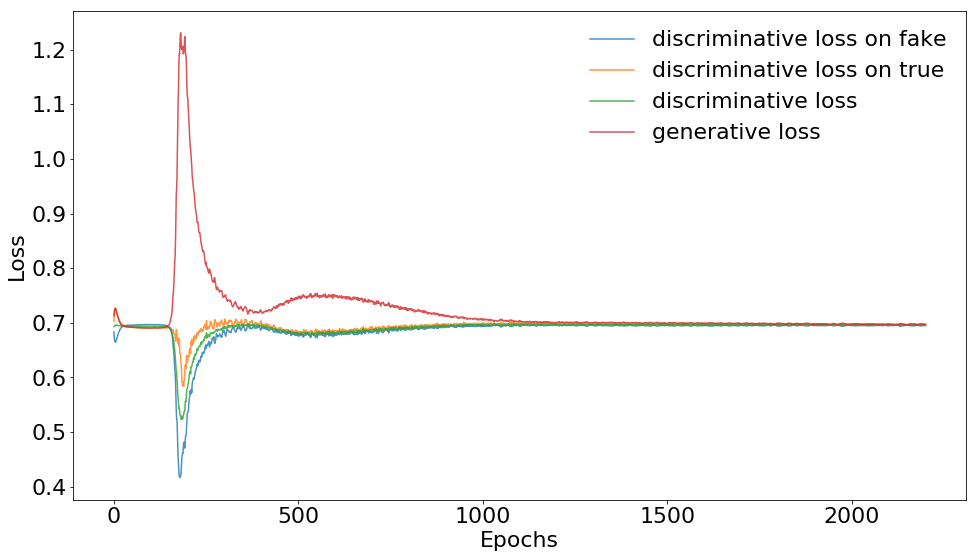

Epoch 2301, Discriminator loss:0.695741653442, GAN loss:0.697453916073
For true: mean and s.d. =  -0.0031033868644 0.4985778686
For generator: mean and s.d. =  0.00340554 0.500876


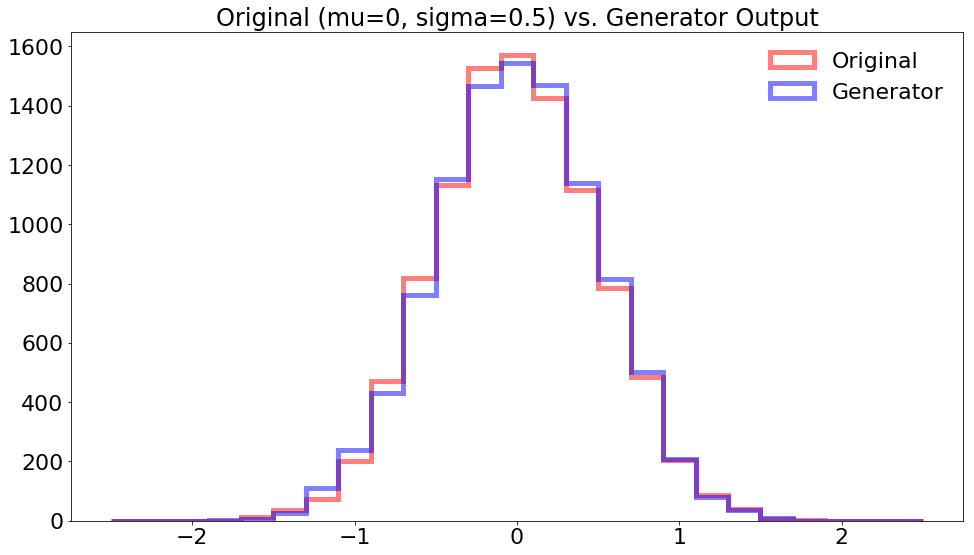

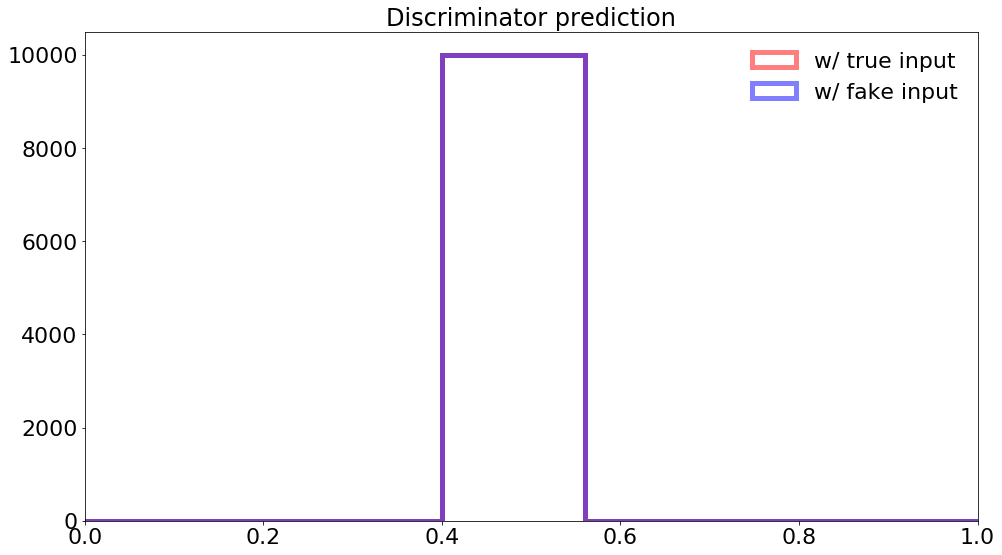

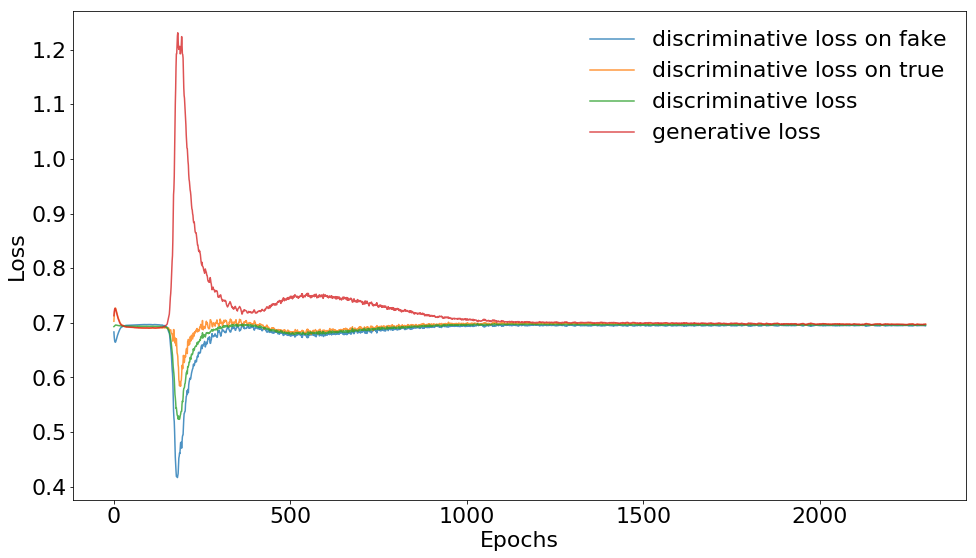

Epoch 2401, Discriminator loss:0.69572031498, GAN loss:0.696805596352
For true: mean and s.d. =  0.00550992730269 0.496720773871
For generator: mean and s.d. =  0.00101642 0.500154


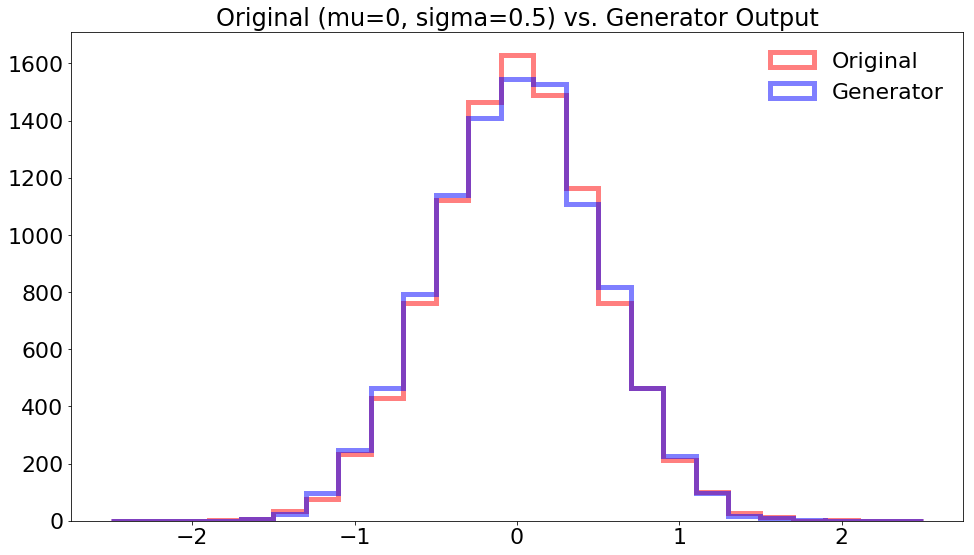

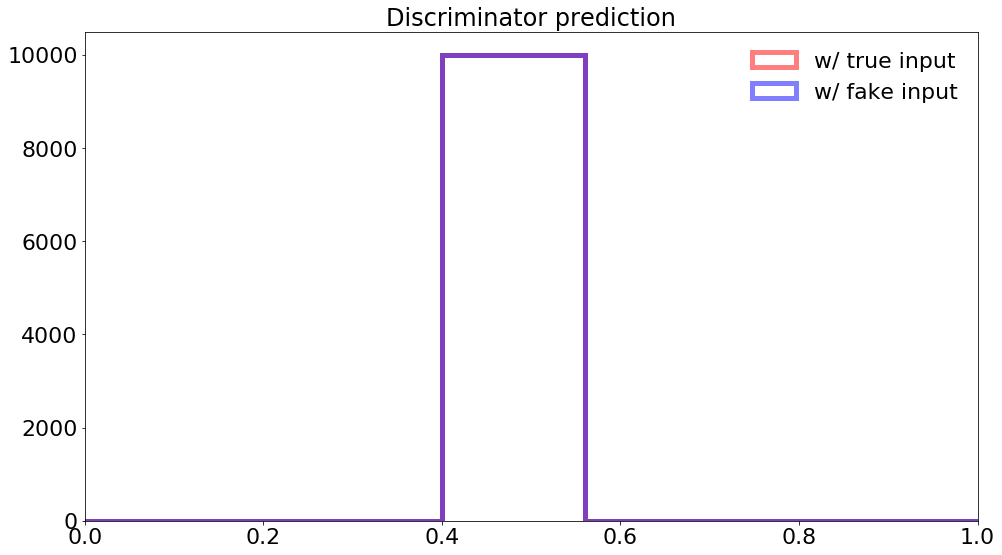

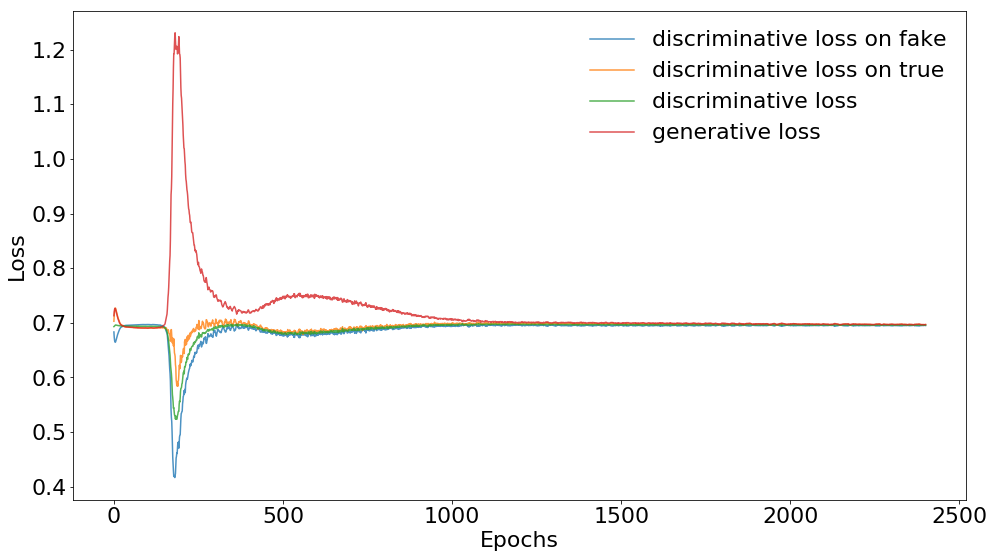

Epoch 2501, Discriminator loss:0.695639371872, GAN loss:0.696450293064
For true: mean and s.d. =  0.00107339907196 0.497248588328
For generator: mean and s.d. =  0.000661707 0.504561


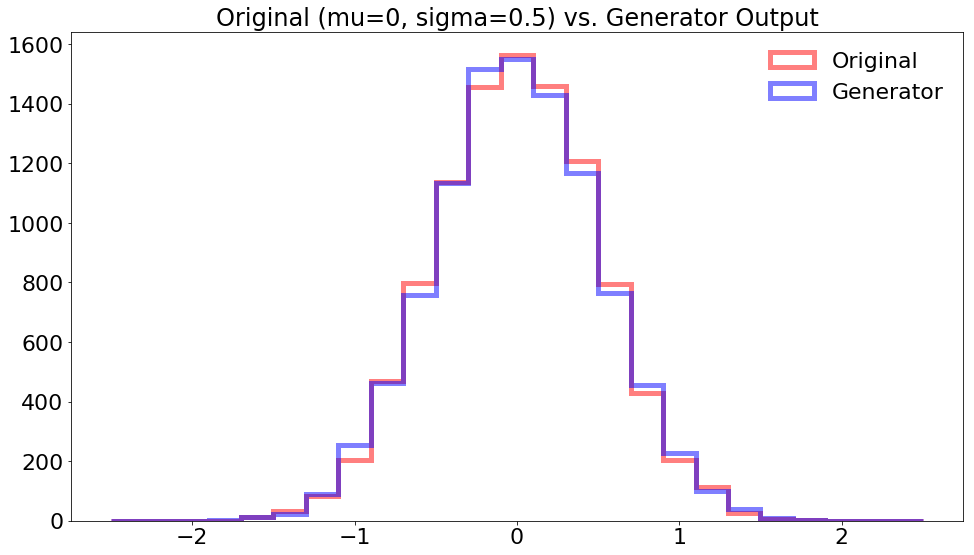

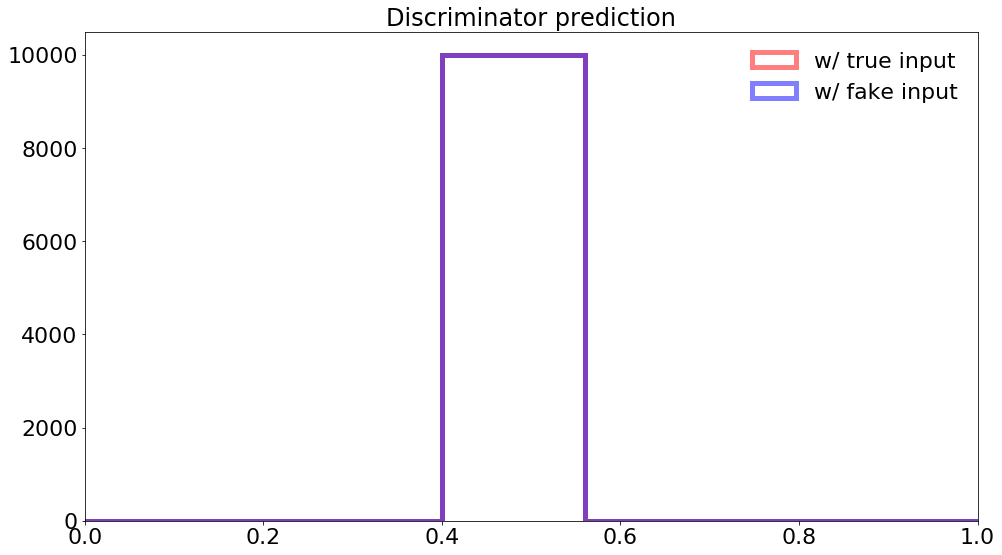

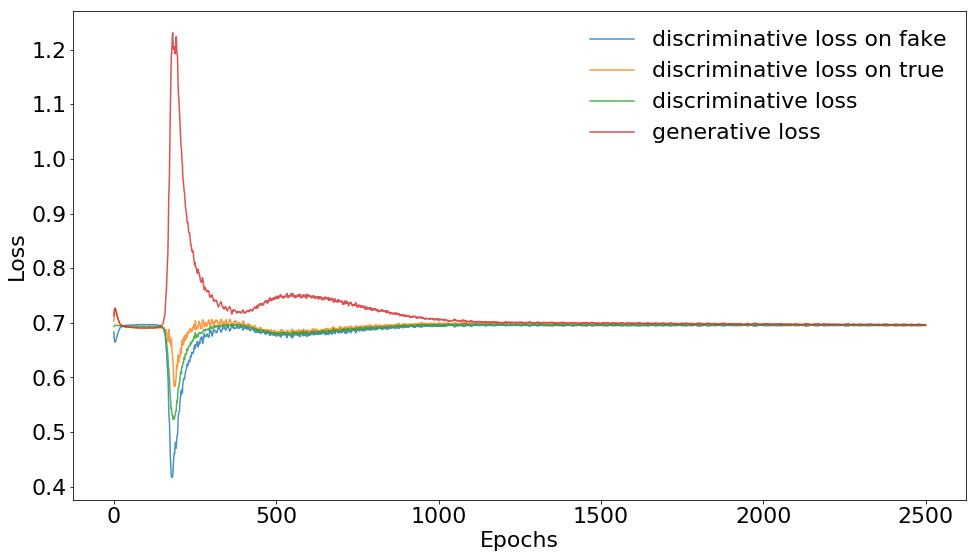

Epoch 2601, Discriminator loss:0.695506691933, GAN loss:0.696301162243
For true: mean and s.d. =  -0.00223329987434 0.498599785258
For generator: mean and s.d. =  0.0032978 0.493062


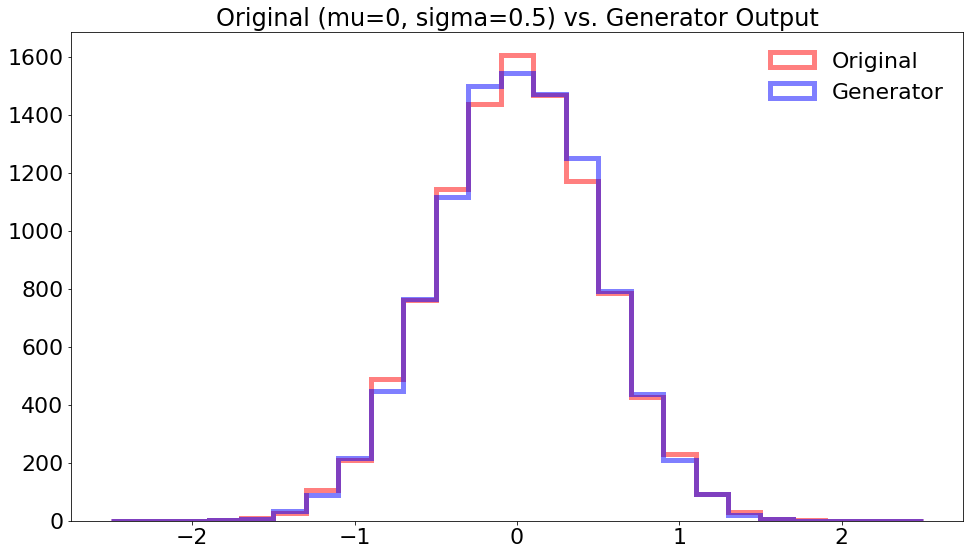

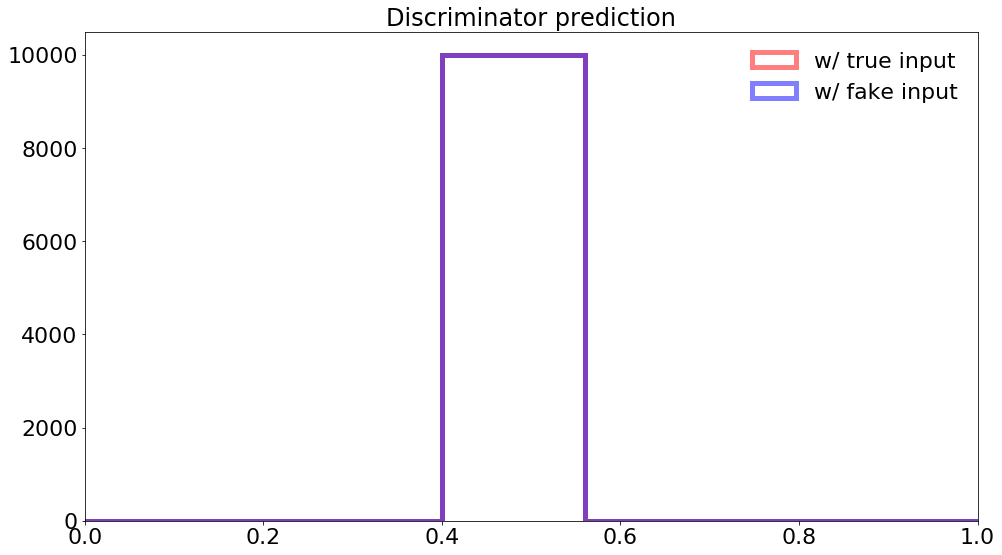

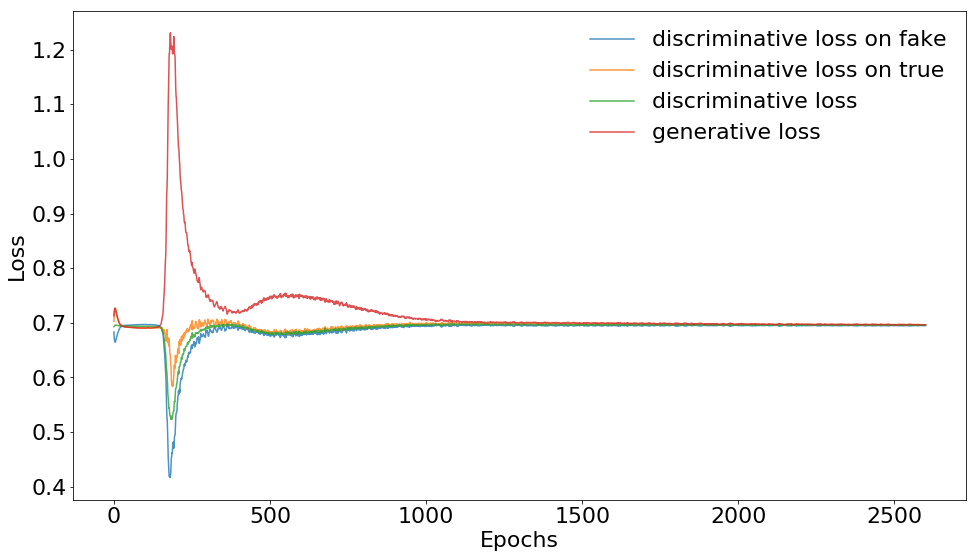

Epoch 2701, Discriminator loss:0.695479631424, GAN loss:0.696451485157
For true: mean and s.d. =  0.0040739929306 0.495515071236
For generator: mean and s.d. =  -0.0040408 0.497818


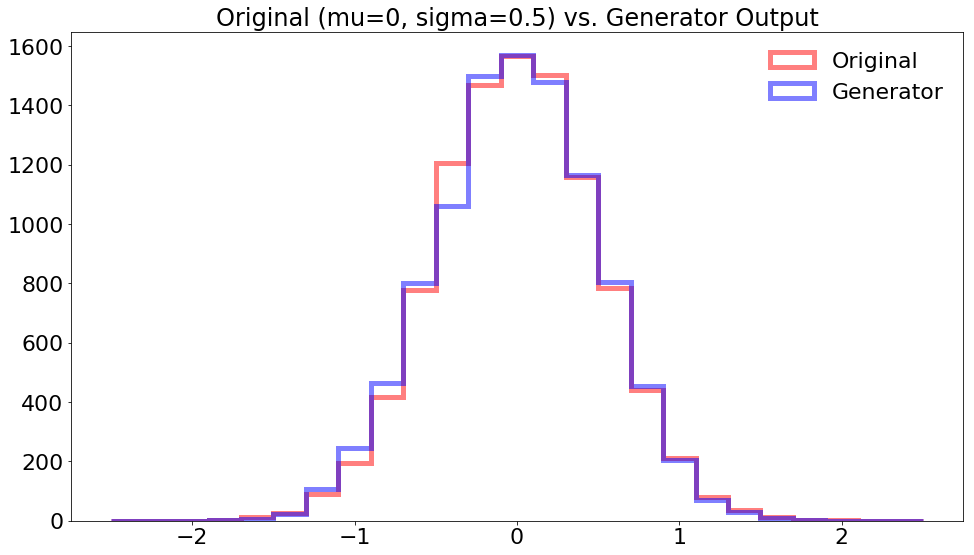

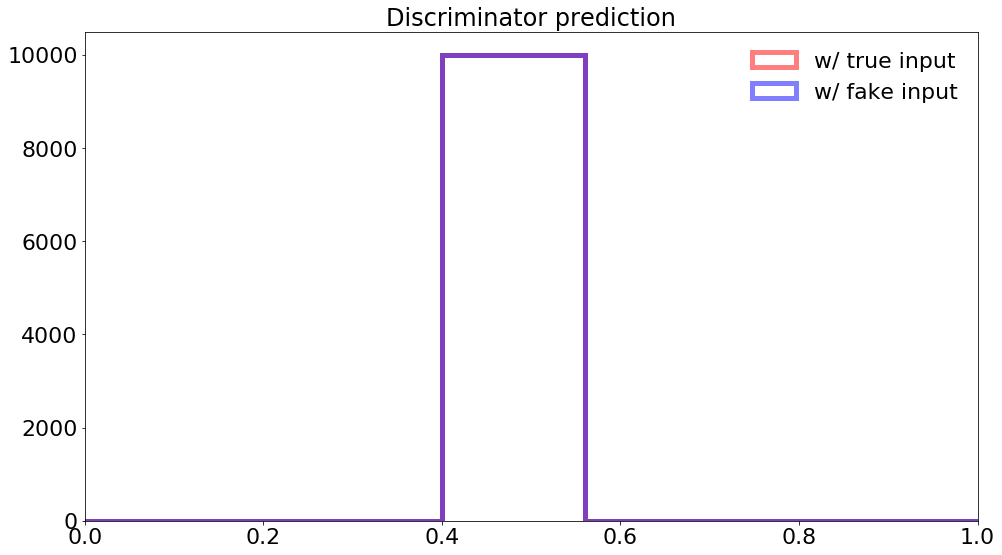

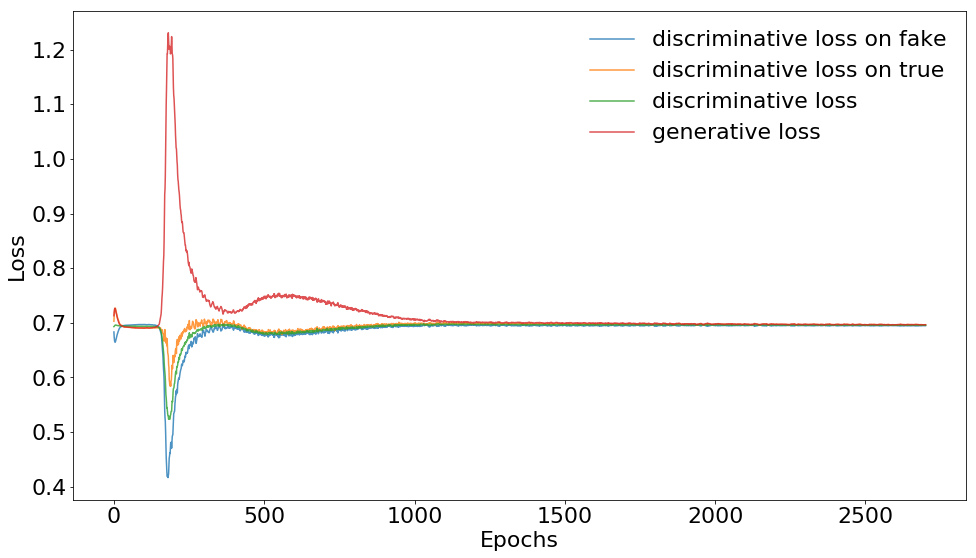

Epoch 2801, Discriminator loss:0.69547277689, GAN loss:0.695803403854
For true: mean and s.d. =  -0.00099929439876 0.49595188856
For generator: mean and s.d. =  -0.00254398 0.496076


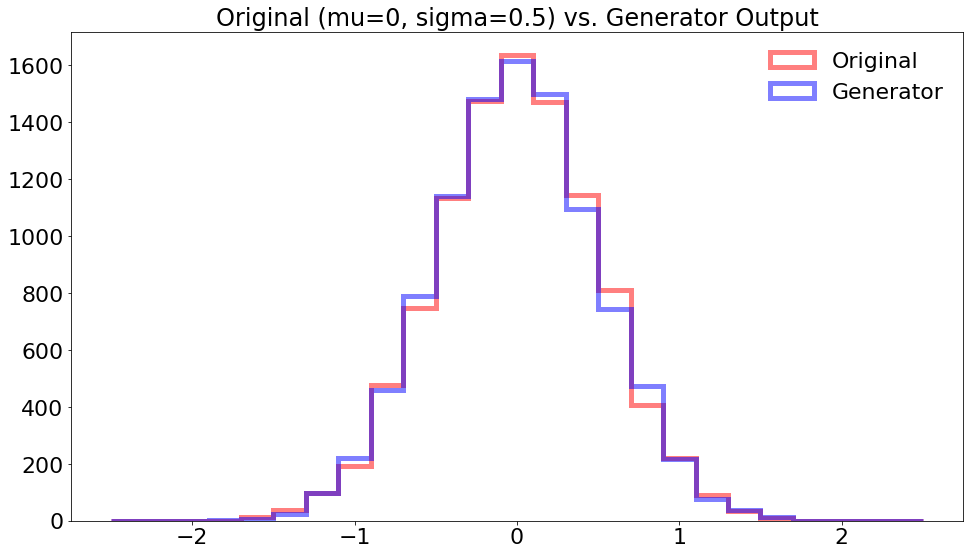

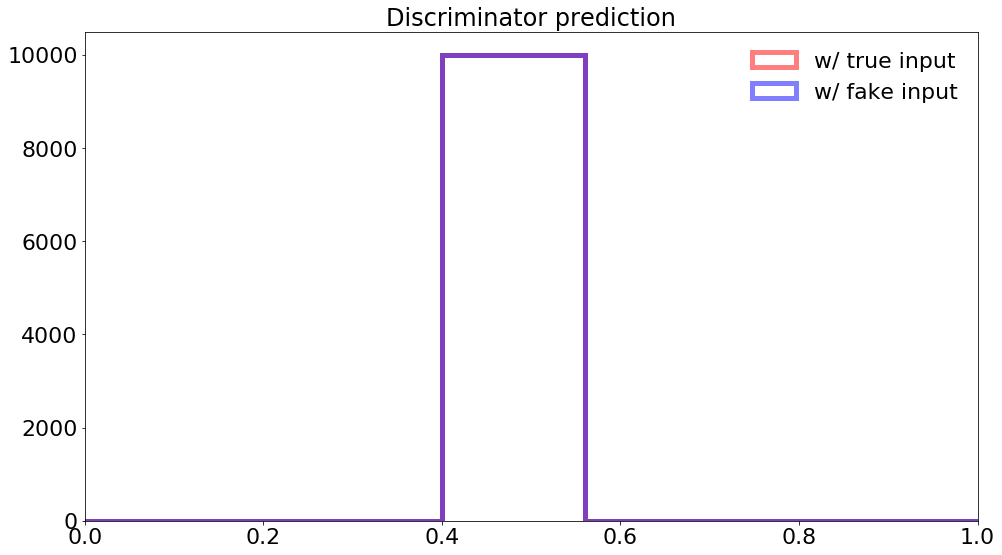

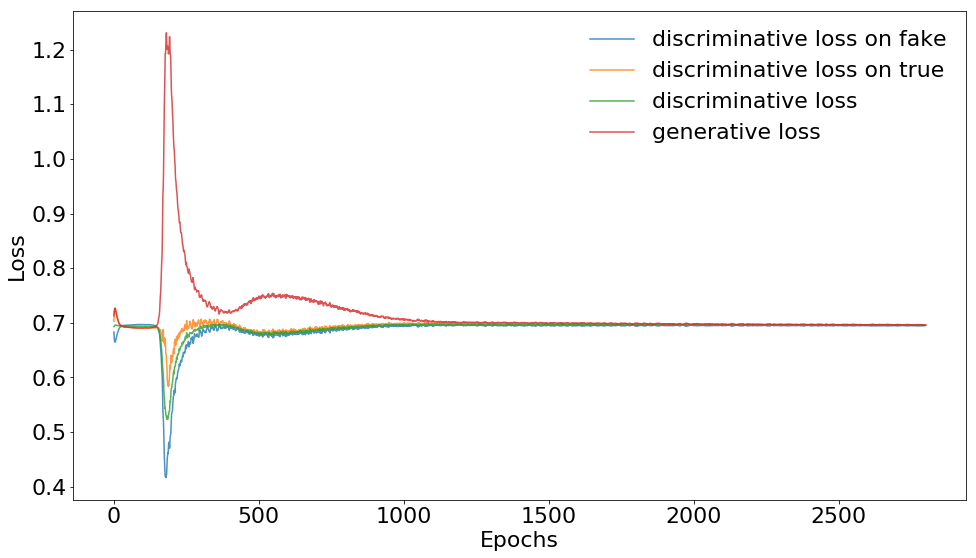

Epoch 2901, Discriminator loss:0.695291817188, GAN loss:0.696248531342
For true: mean and s.d. =  -0.004104130293 0.50402951225
For generator: mean and s.d. =  -0.00251539 0.500518


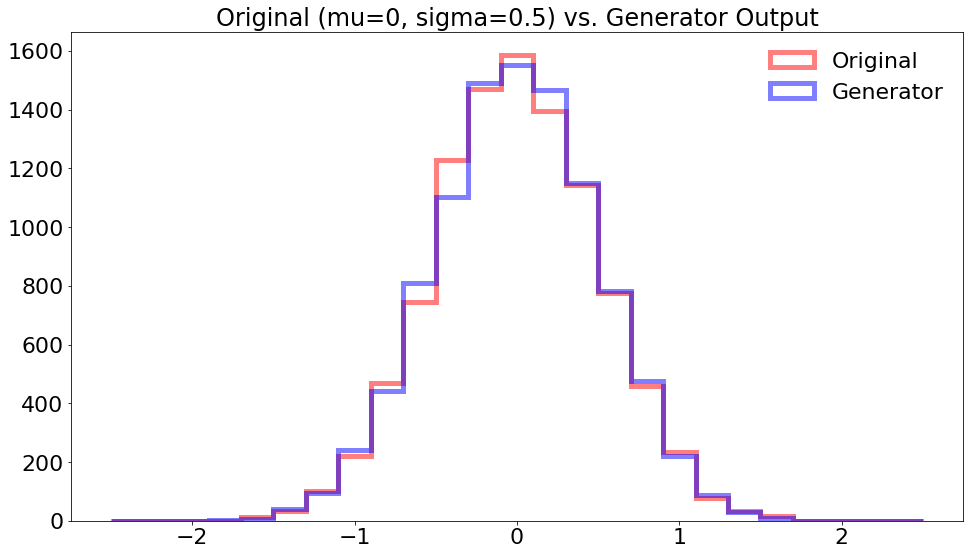

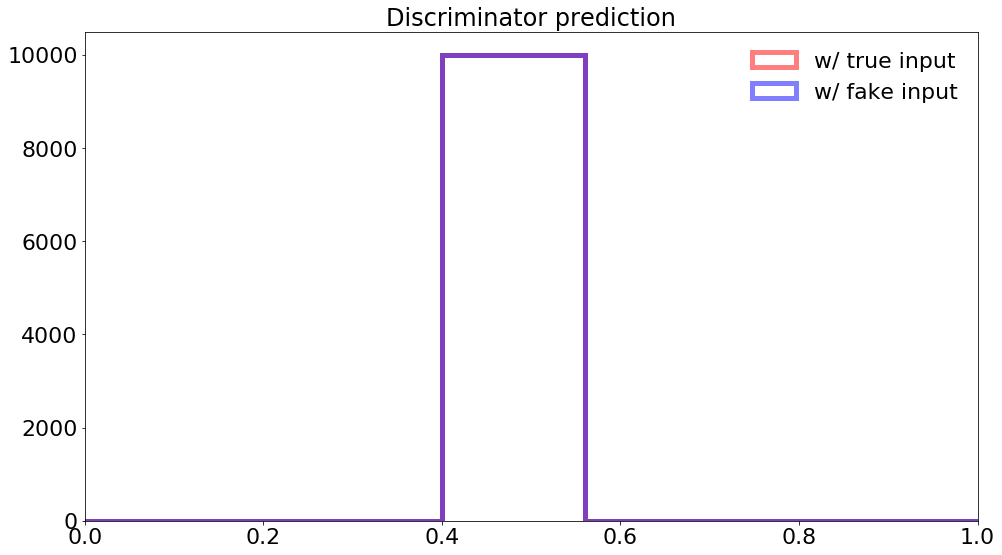

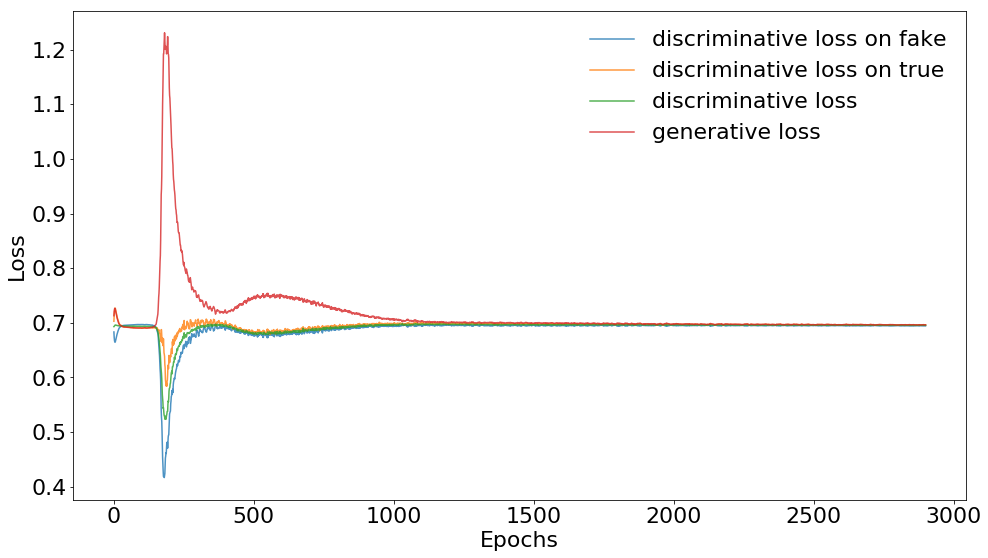

Epoch 3001, Discriminator loss:0.695273995399, GAN loss:0.696108818054
For true: mean and s.d. =  -0.00497836587009 0.499850189053
For generator: mean and s.d. =  -0.00140691 0.504517


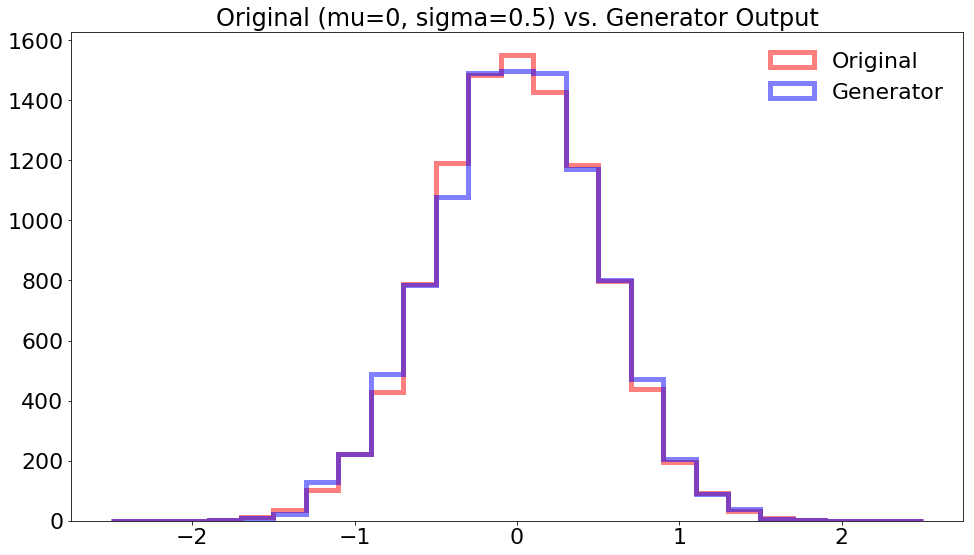

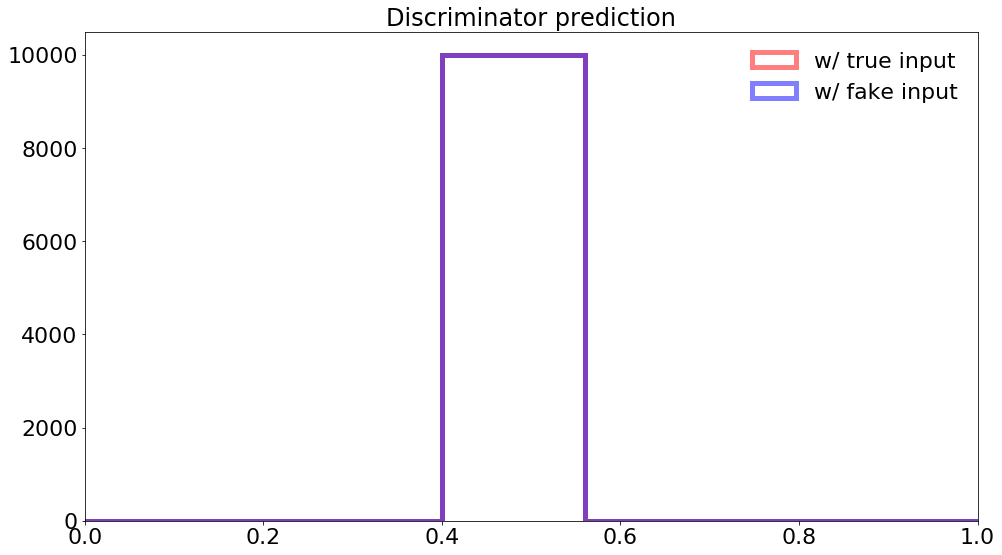

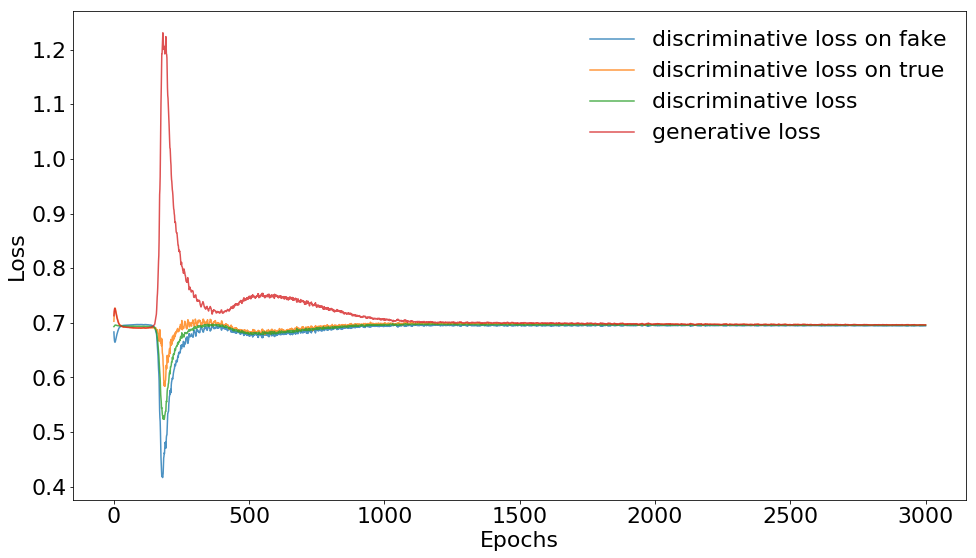

Epoch 3101, Discriminator loss:0.695045590401, GAN loss:0.695994317532
For true: mean and s.d. =  -0.000890234223719 0.502871473524
For generator: mean and s.d. =  0.00553236 0.494868


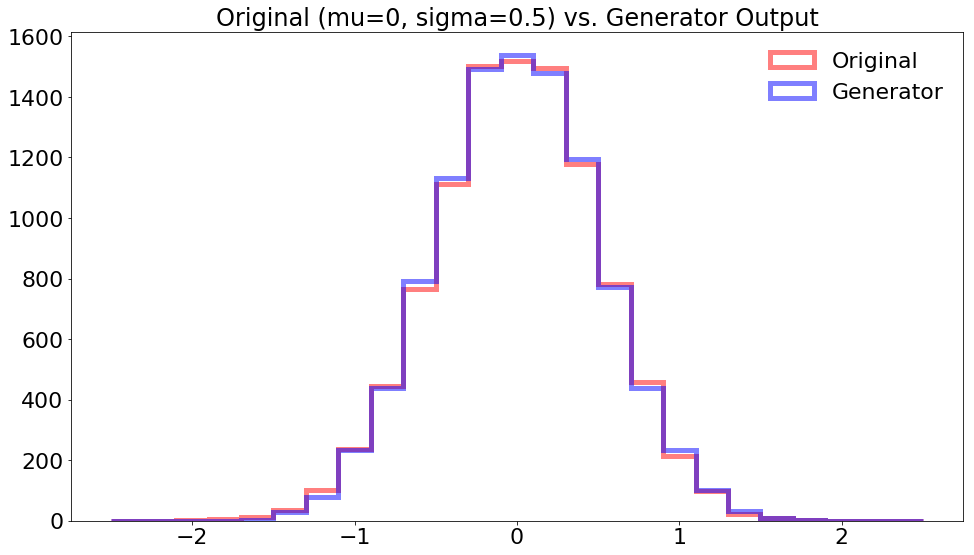

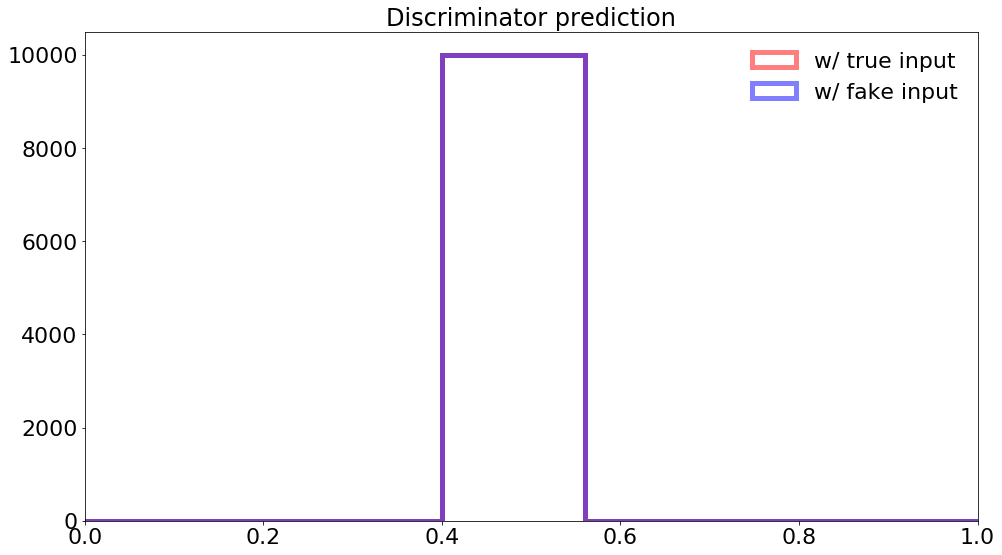

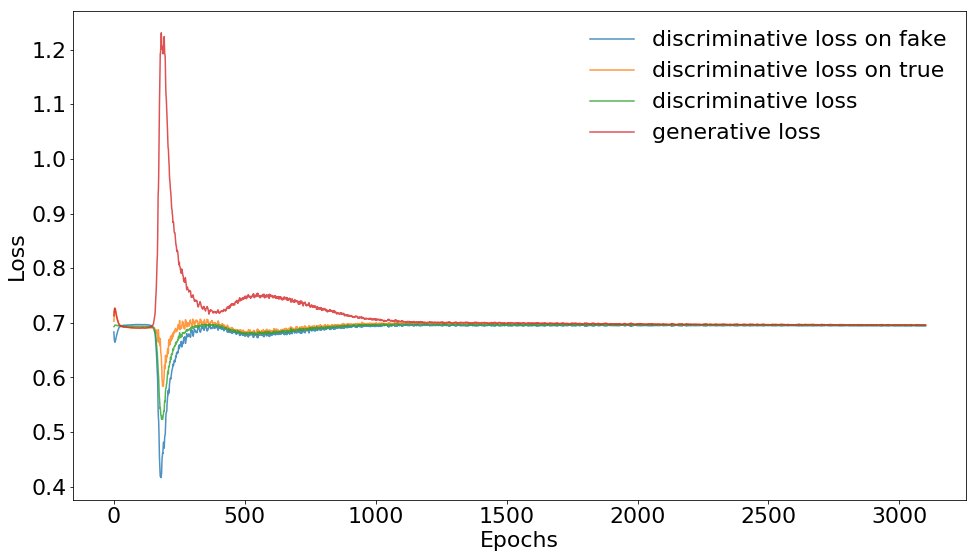

Epoch 3201, Discriminator loss:0.694937944412, GAN loss:0.696366250515
For true: mean and s.d. =  0.00500773922859 0.498344110654
For generator: mean and s.d. =  -0.00717756 0.495625


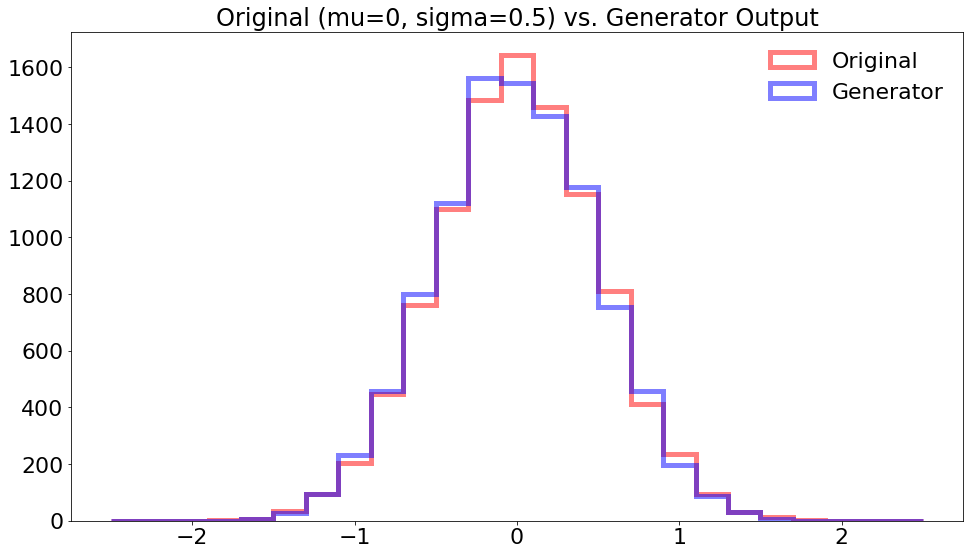

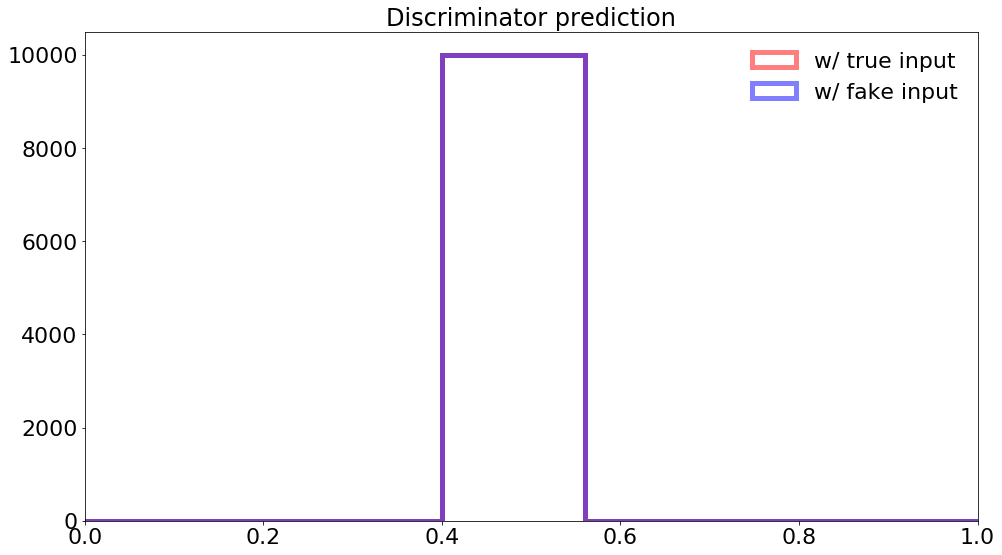

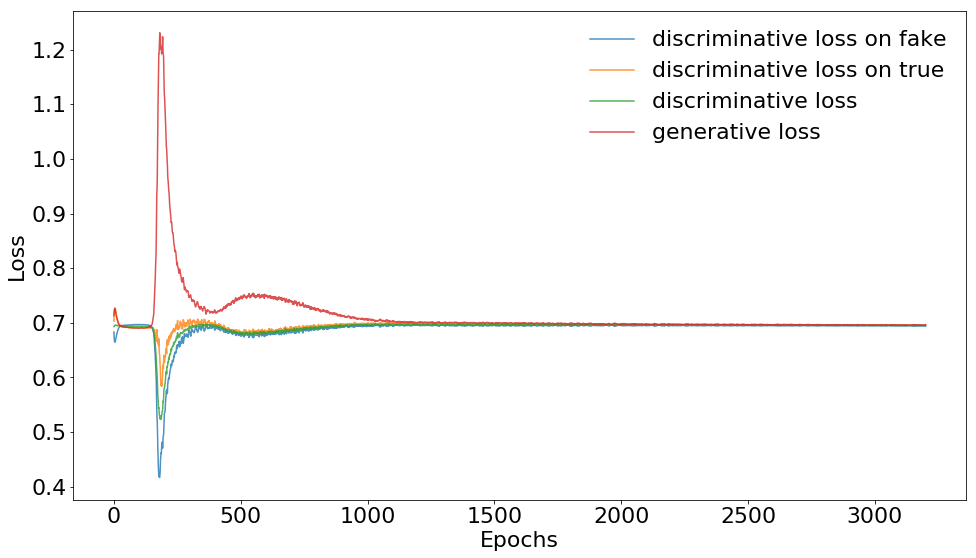

Epoch 3301, Discriminator loss:0.694882512093, GAN loss:0.695534646511
For true: mean and s.d. =  0.00443490833202 0.502172889784
For generator: mean and s.d. =  -0.000820166 0.497115


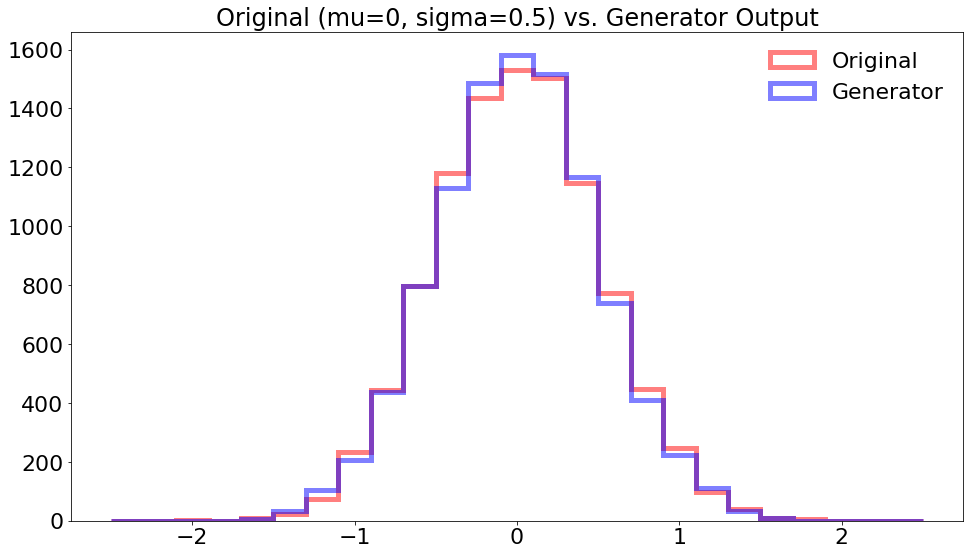

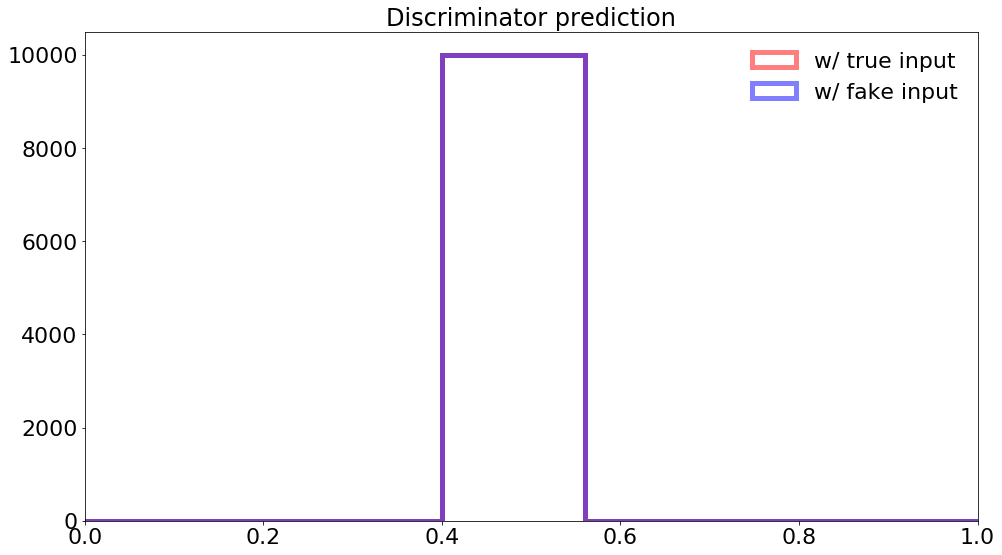

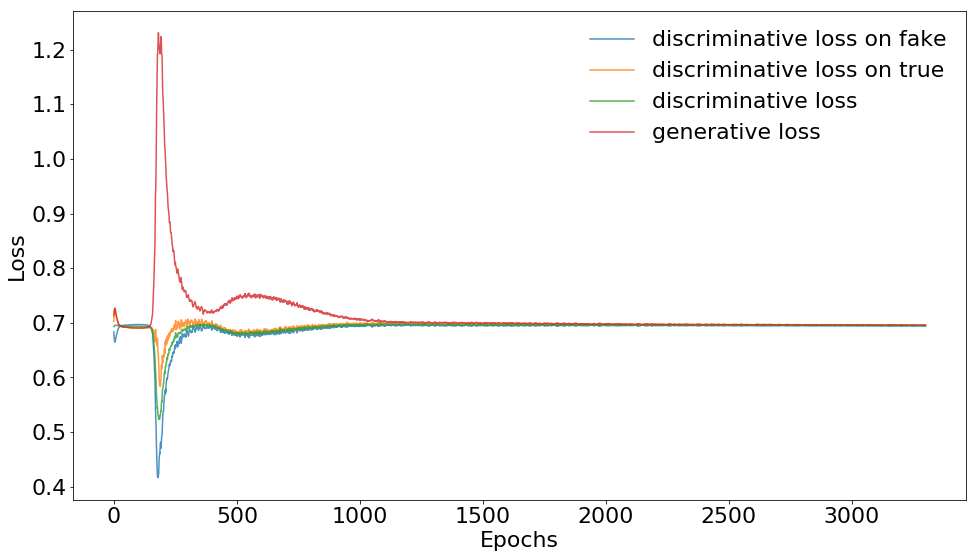

Epoch 3401, Discriminator loss:0.694750070572, GAN loss:0.695605397224
For true: mean and s.d. =  0.00650095724958 0.495642064316
For generator: mean and s.d. =  -0.00364803 0.501614


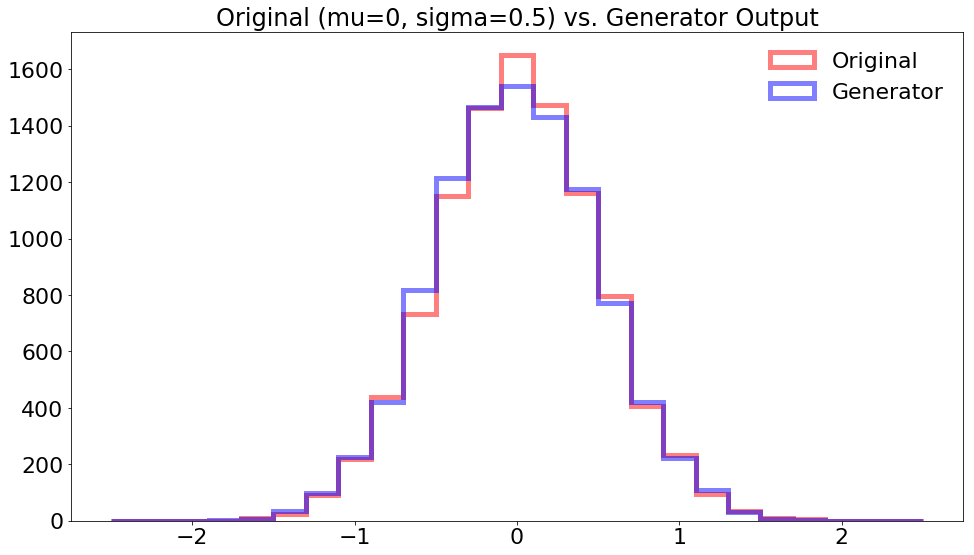

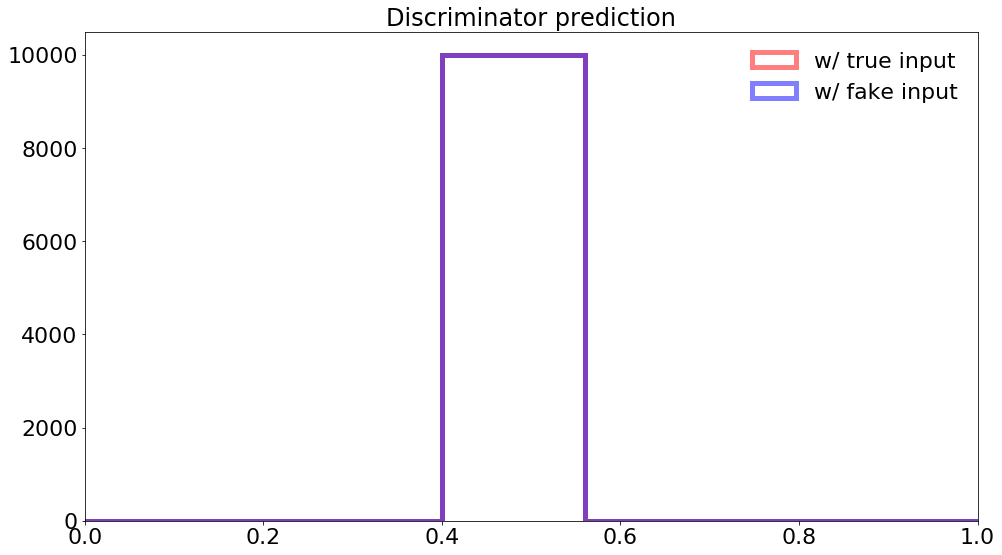

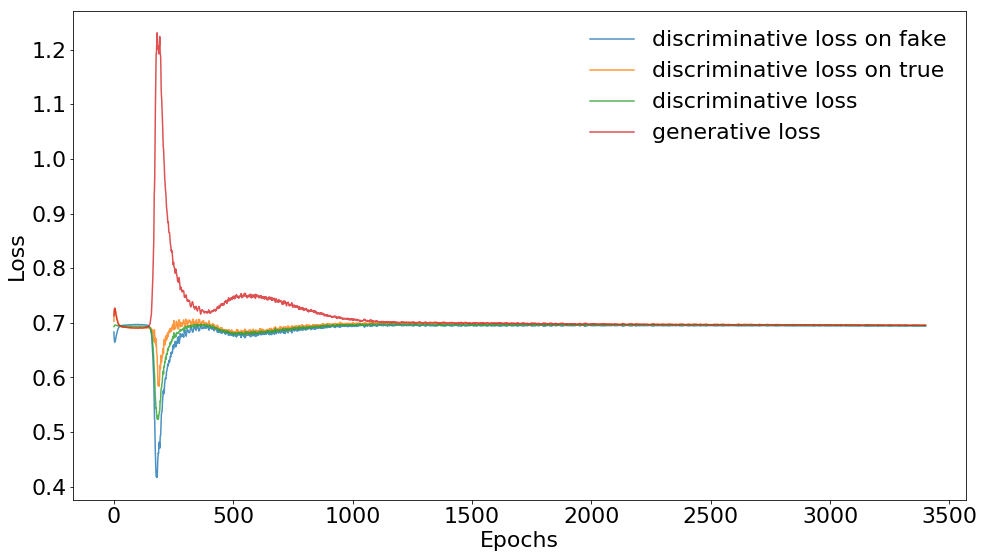

Epoch 3501, Discriminator loss:0.694622159004, GAN loss:0.695644378662
For true: mean and s.d. =  0.00367521077443 0.504719740837
For generator: mean and s.d. =  -0.00164312 0.500165


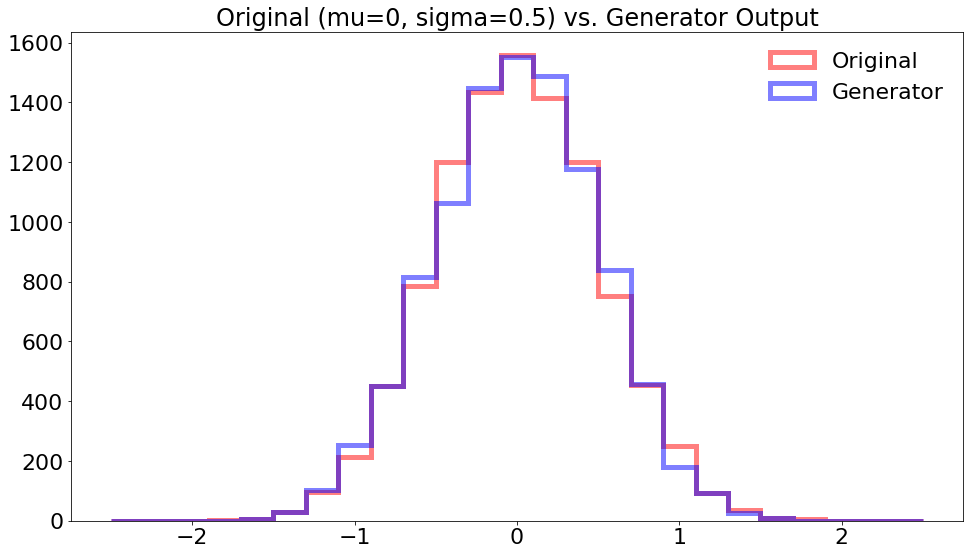

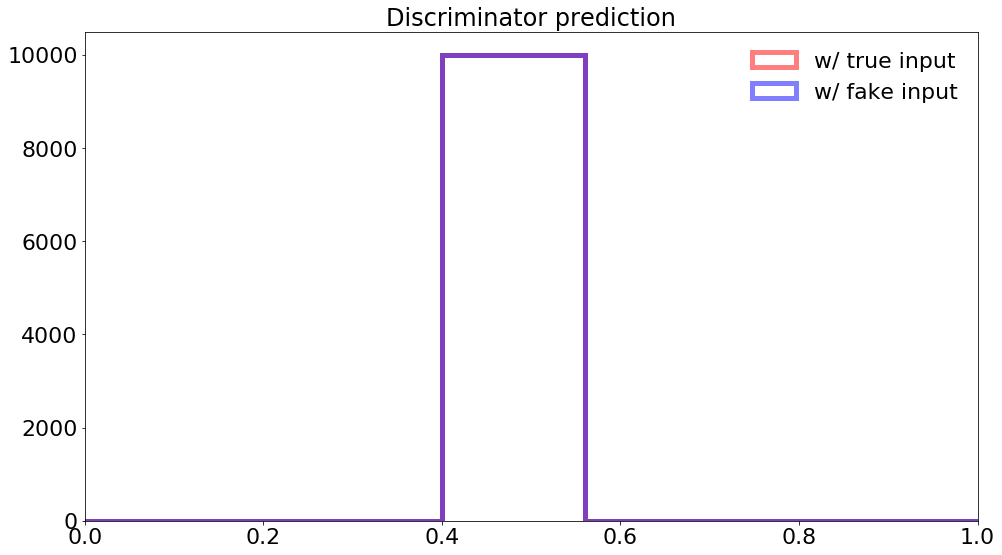

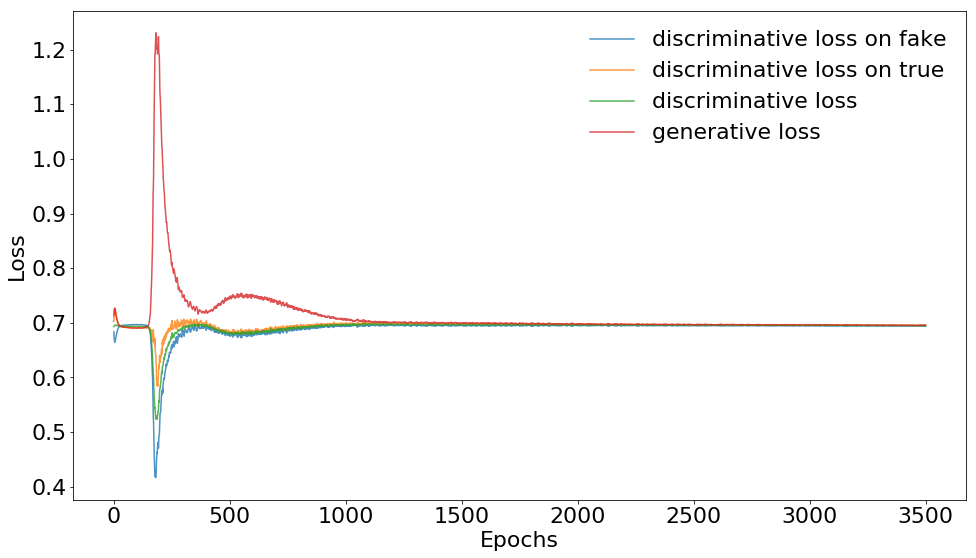

Epoch 3601, Discriminator loss:0.694613456726, GAN loss:0.695893704891
For true: mean and s.d. =  0.00104768107662 0.500247563949
For generator: mean and s.d. =  0.00188174 0.494557


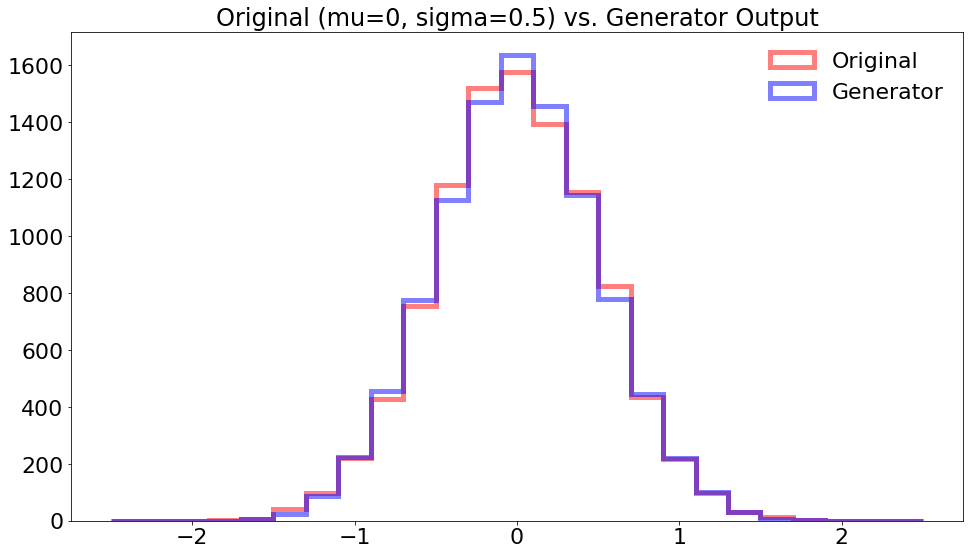

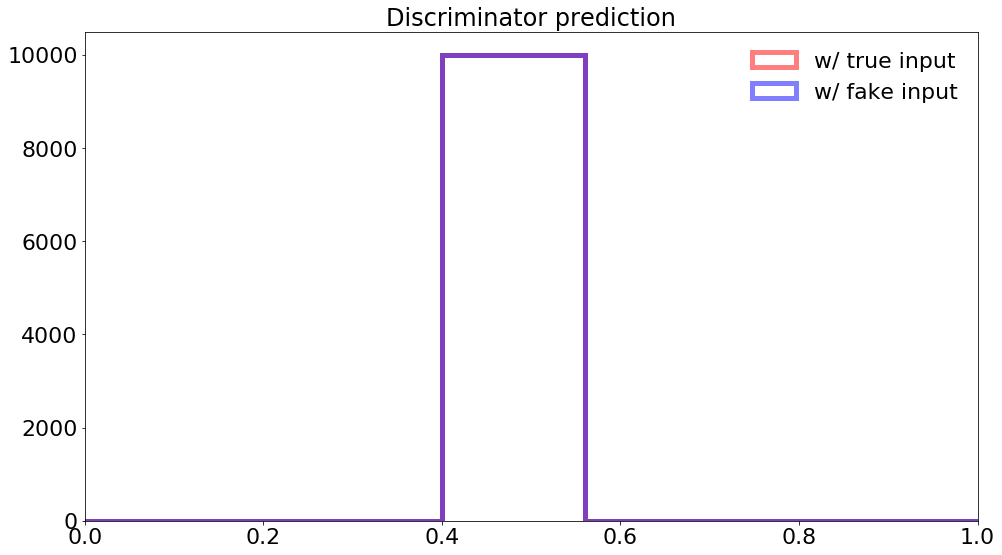

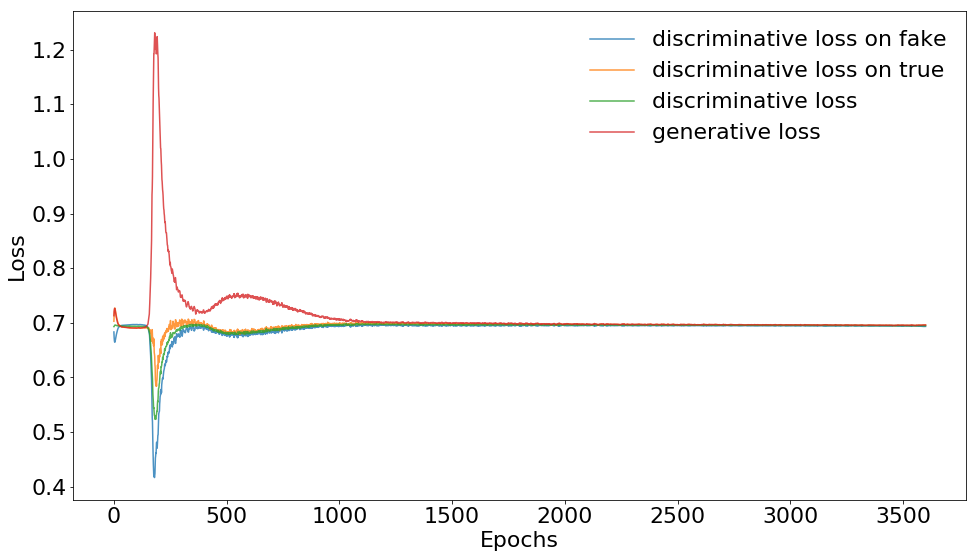

Epoch 3701, Discriminator loss:0.694430947304, GAN loss:0.695888638496
For true: mean and s.d. =  0.00421446387951 0.498433455688
For generator: mean and s.d. =  0.00646395 0.504922


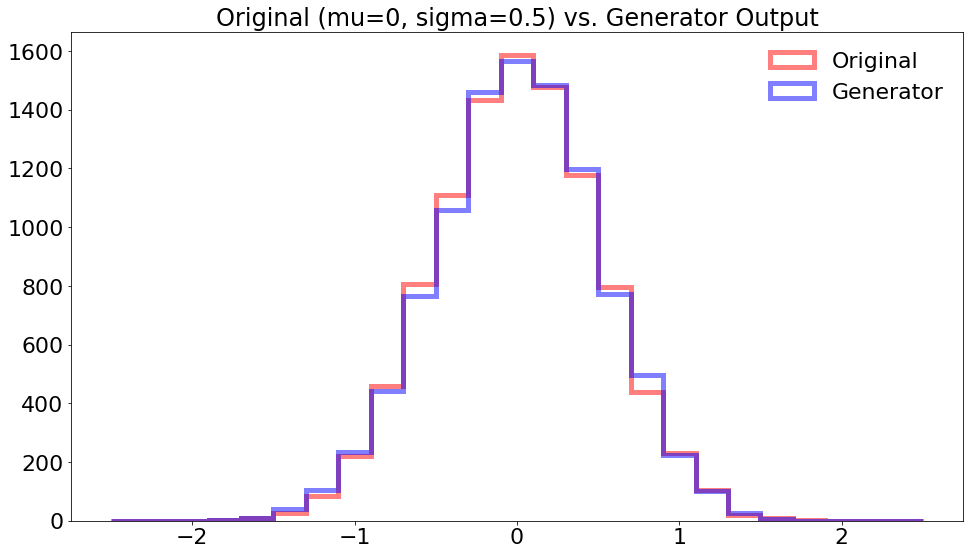

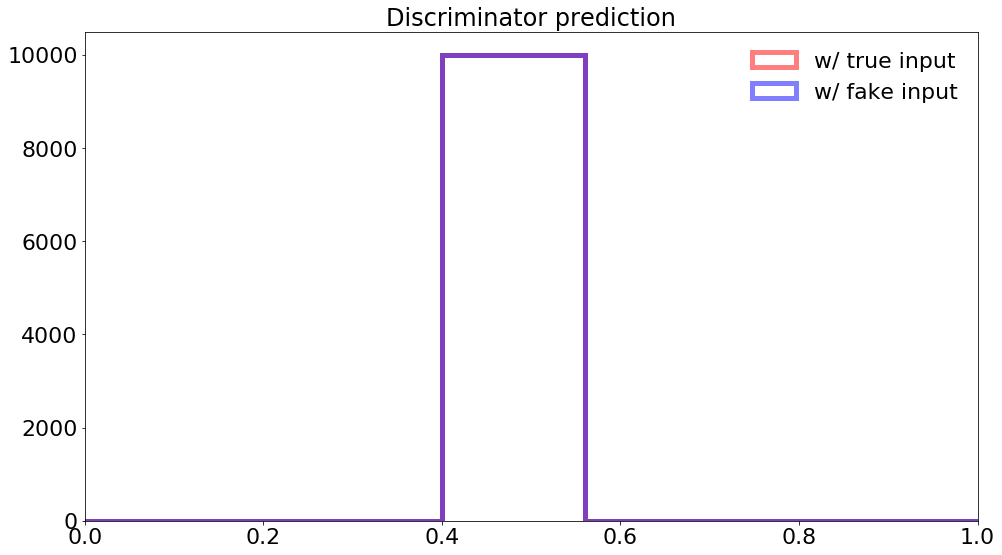

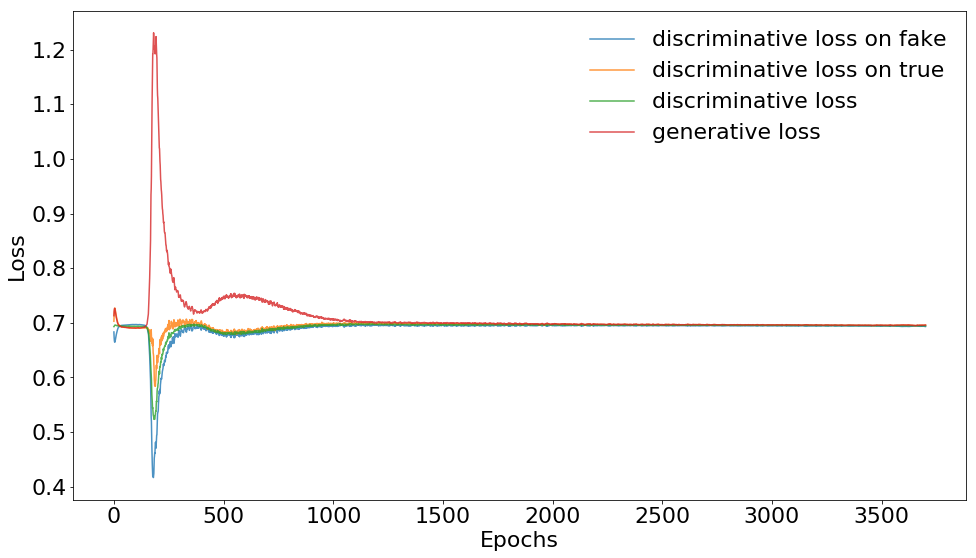

Epoch 3801, Discriminator loss:0.694447577, GAN loss:0.695344507694
For true: mean and s.d. =  0.00119918853357 0.499110497654
For generator: mean and s.d. =  0.00013092 0.500075


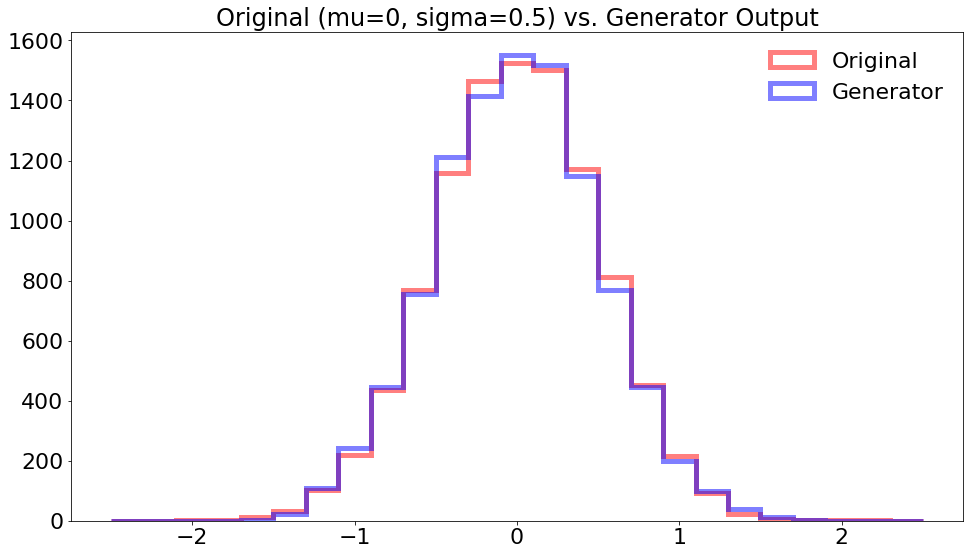

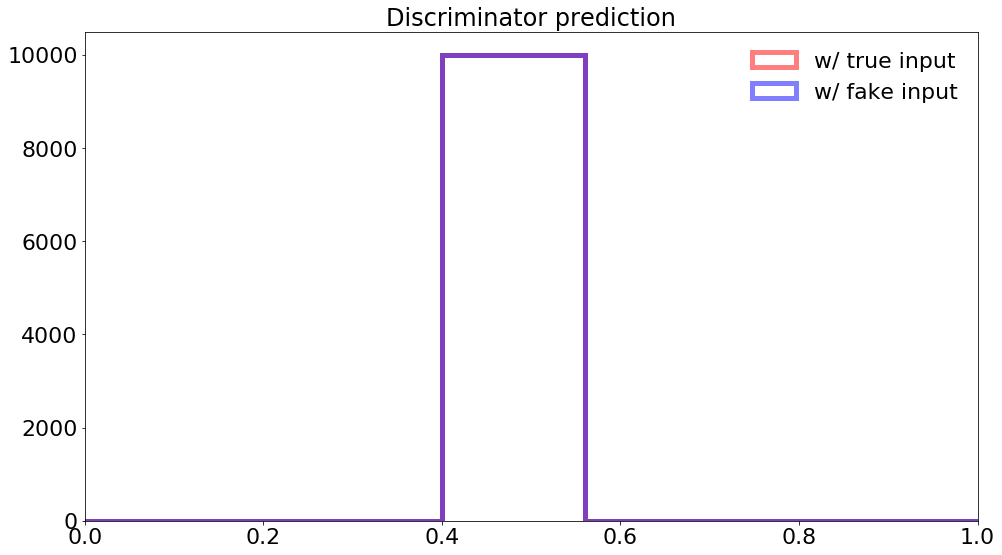

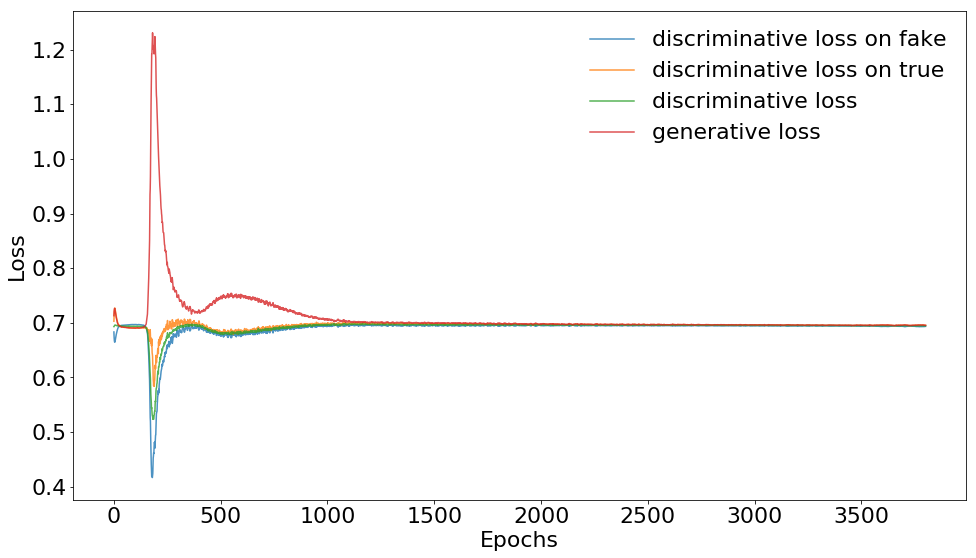

Epoch 3901, Discriminator loss:0.694271326065, GAN loss:0.695497334003
For true: mean and s.d. =  0.0106778962995 0.499477541814
For generator: mean and s.d. =  -0.0156919 0.496208


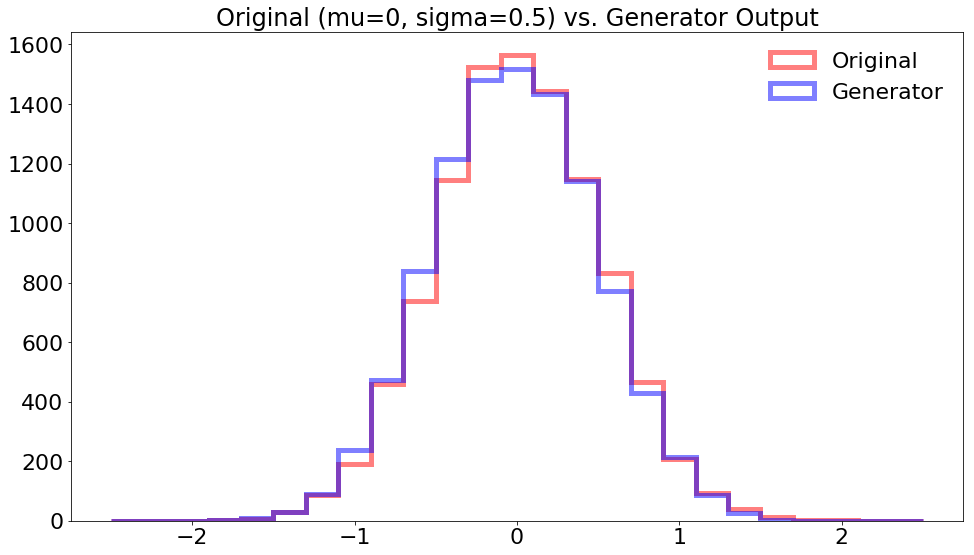

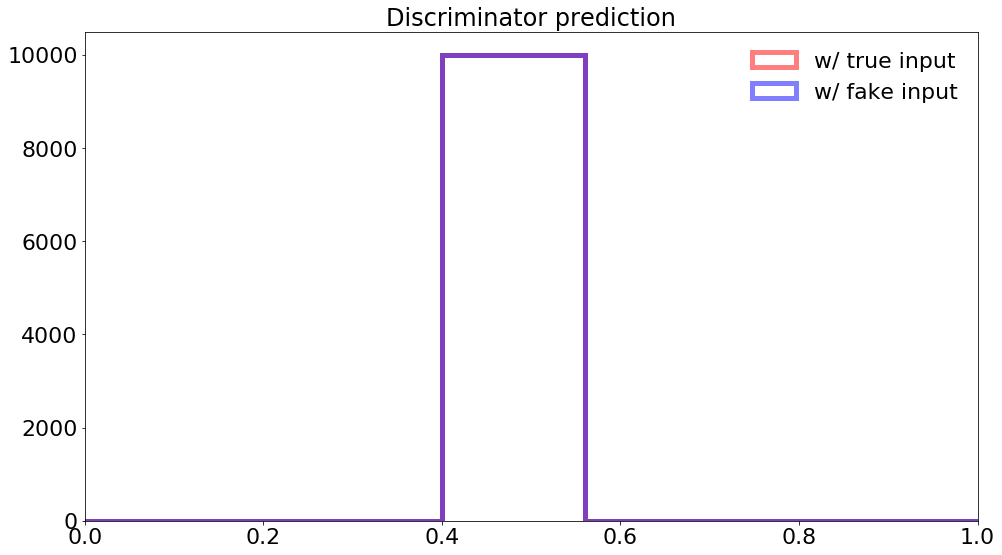

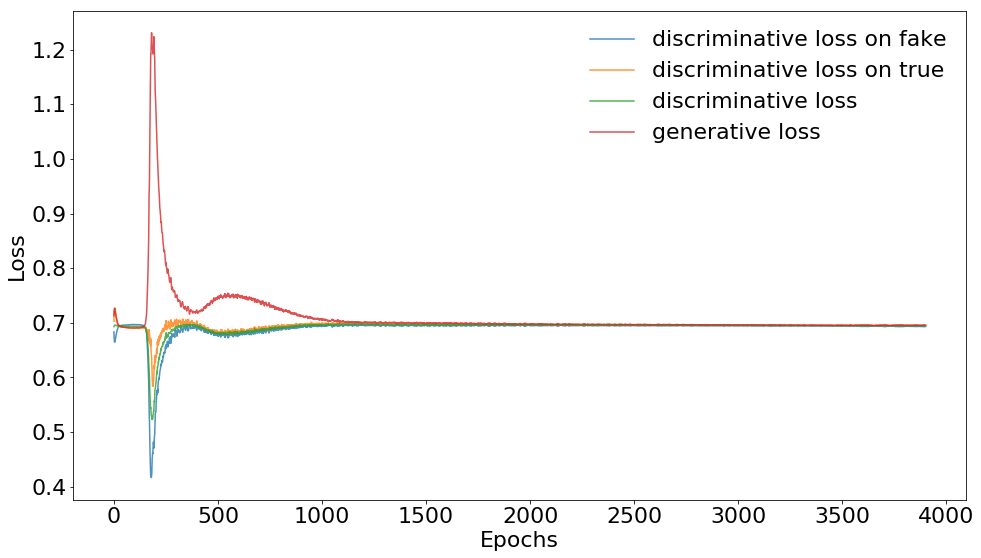

Epoch 4001, Discriminator loss:0.694154083729, GAN loss:0.695165812969
For true: mean and s.d. =  0.00522709339778 0.50151531453
For generator: mean and s.d. =  -0.0044296 0.49558


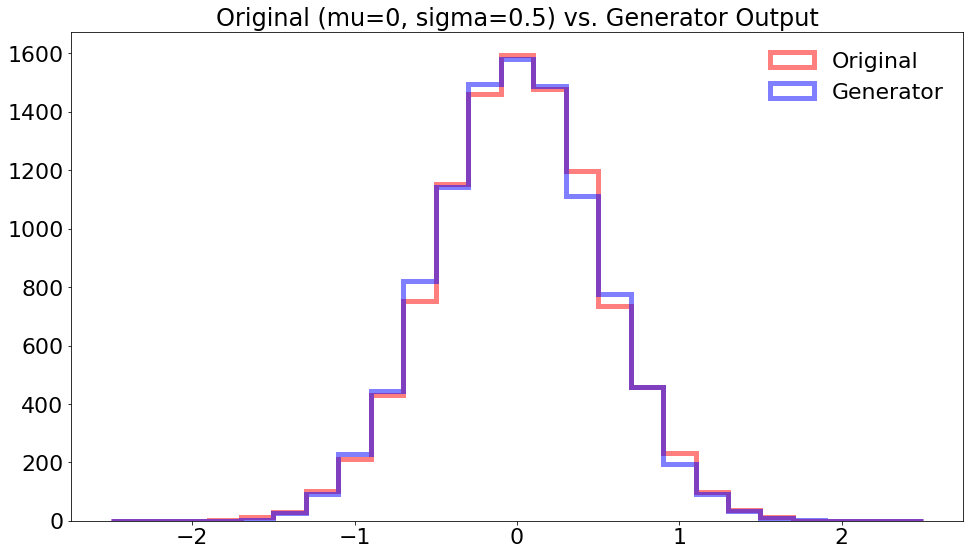

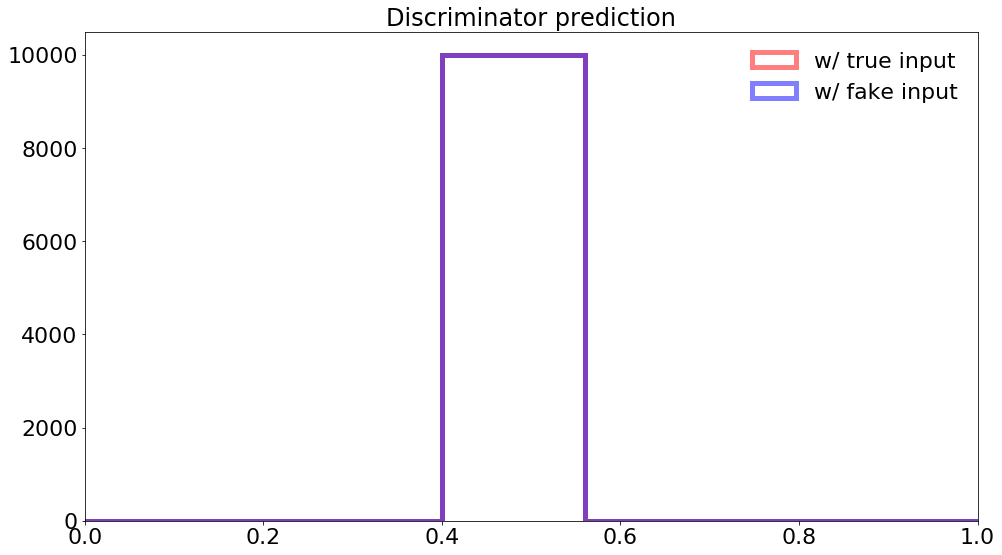

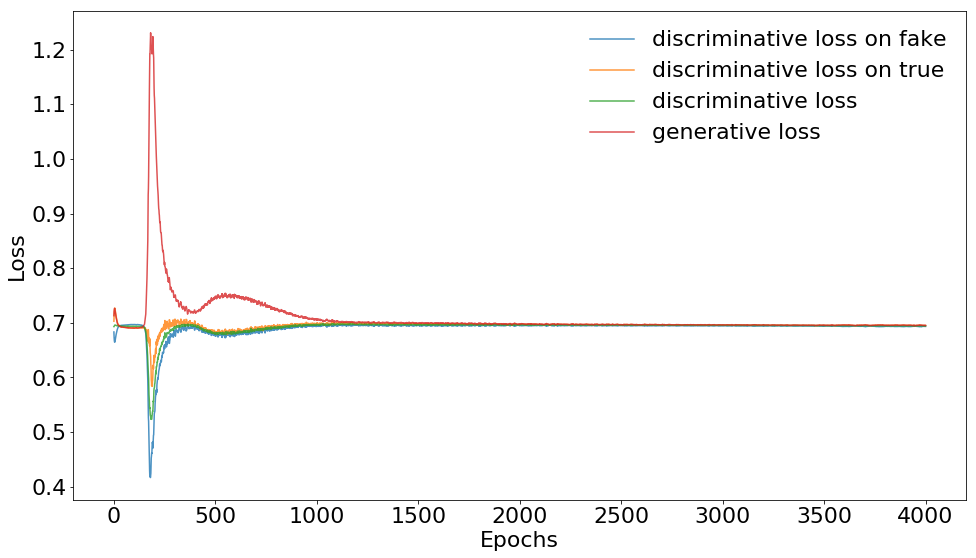

Epoch 4101, Discriminator loss:0.694180965424, GAN loss:0.695715904236
For true: mean and s.d. =  -0.00163488146195 0.499357463979
For generator: mean and s.d. =  -0.0015976 0.490835


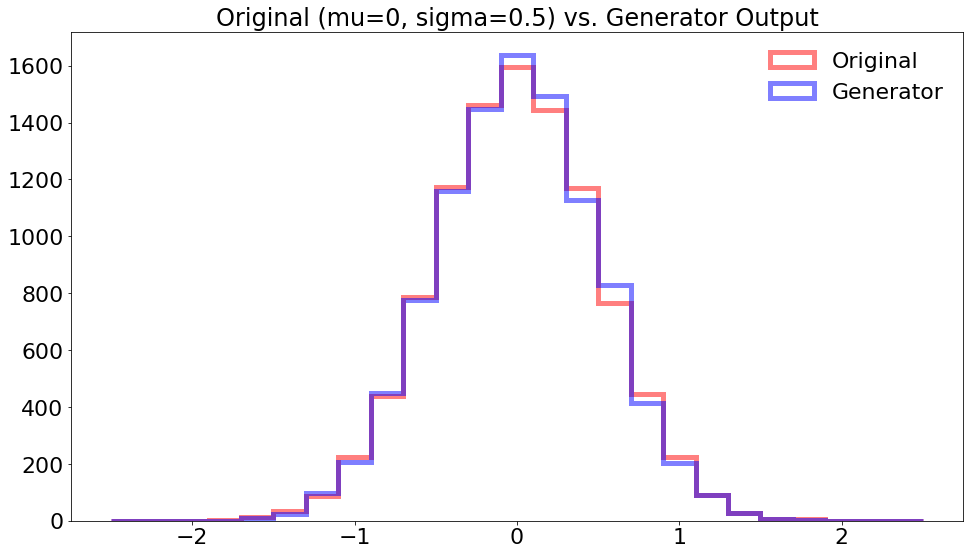

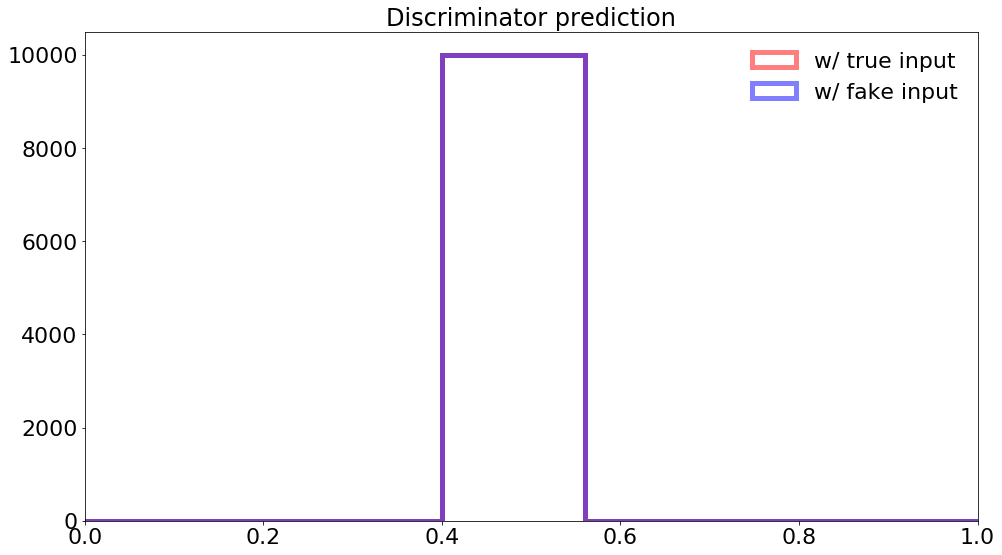

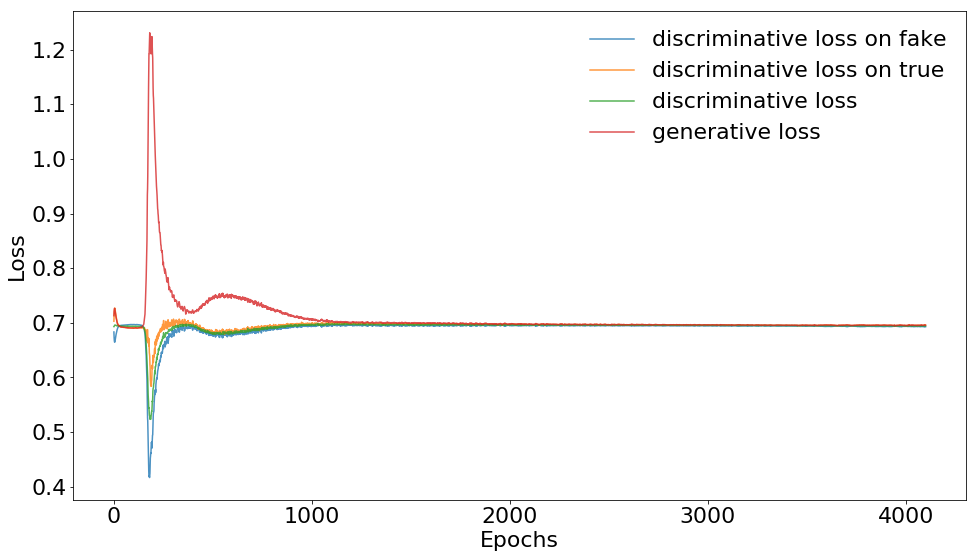

Epoch 4201, Discriminator loss:0.693922400475, GAN loss:0.695246219635
For true: mean and s.d. =  0.00356298247145 0.4979926369
For generator: mean and s.d. =  0.00255242 0.497542


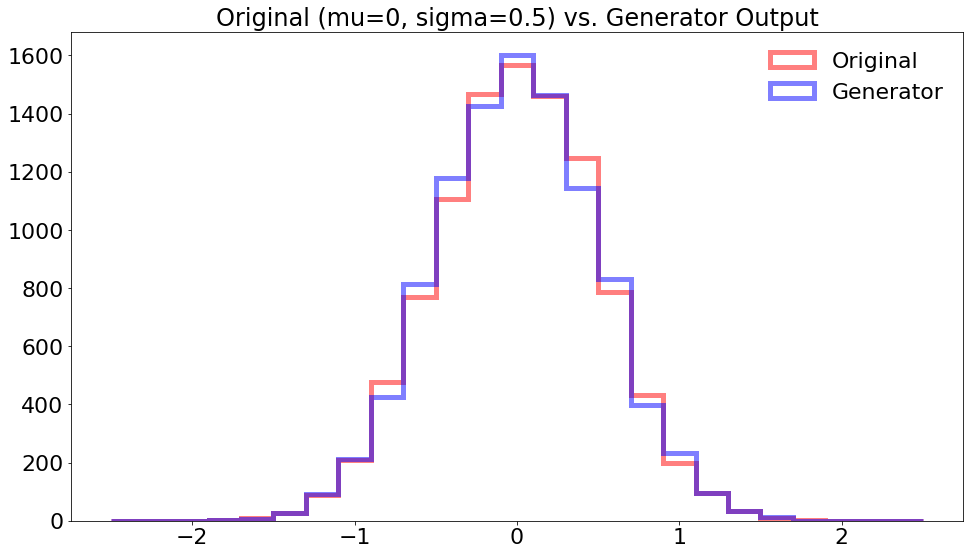

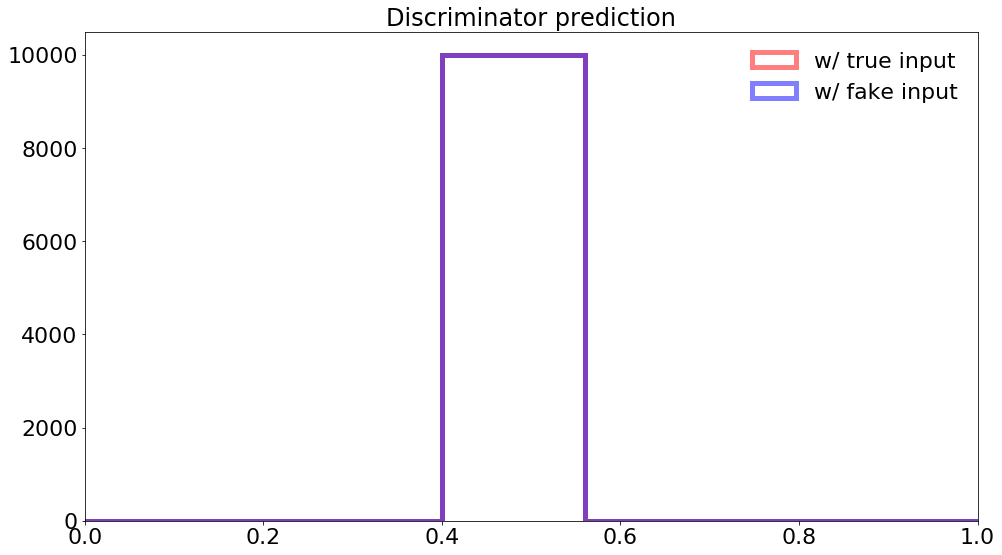

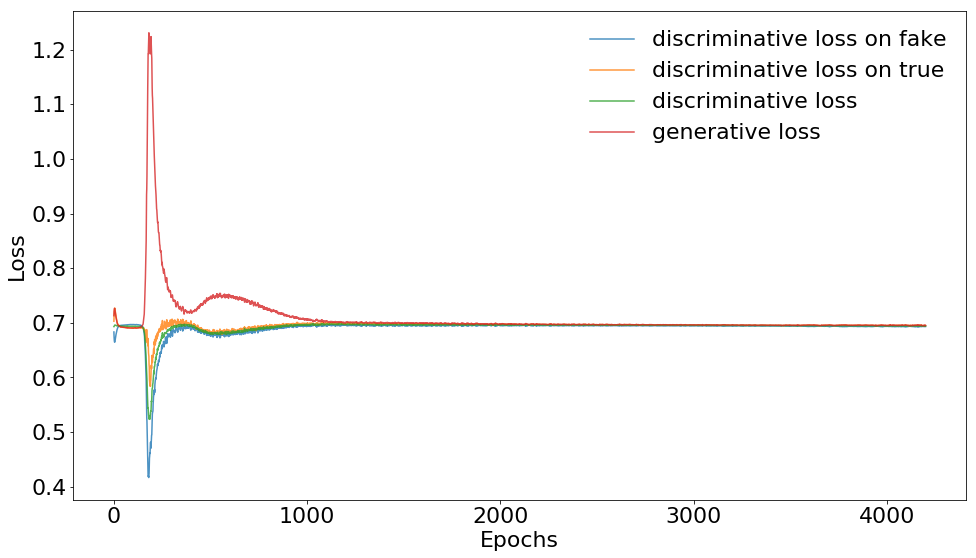

Epoch 4301, Discriminator loss:0.693861484528, GAN loss:0.69495344162
For true: mean and s.d. =  0.000339886025714 0.49888697467
For generator: mean and s.d. =  0.000674878 0.497328


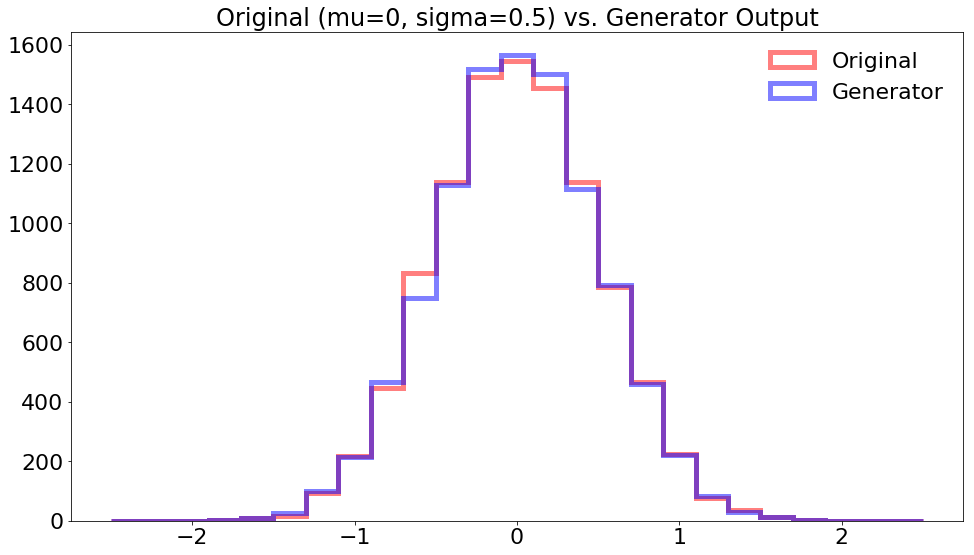

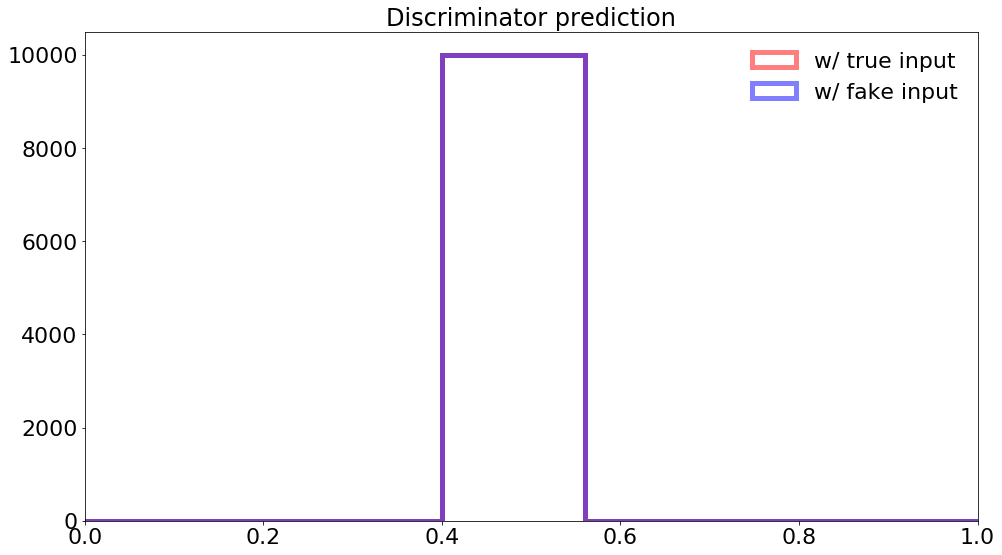

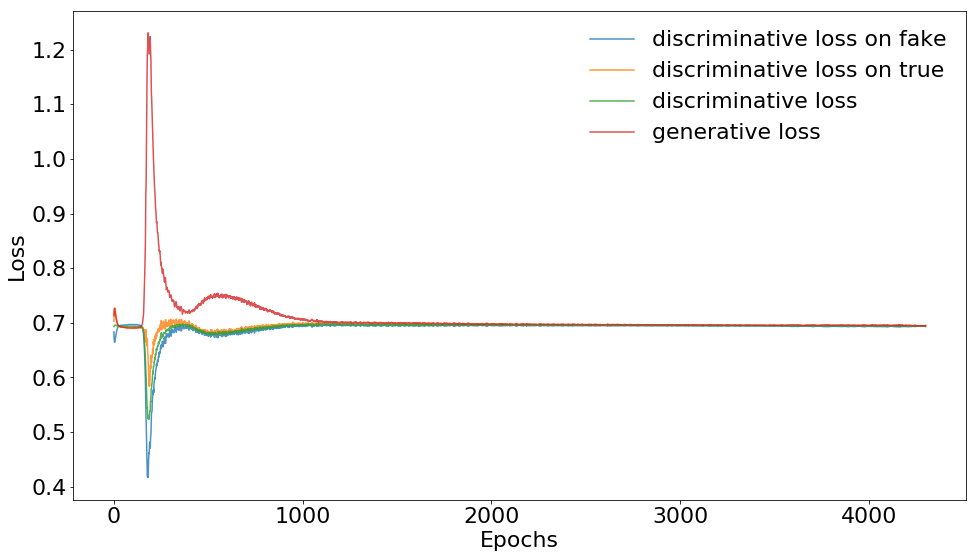

Epoch 4401, Discriminator loss:0.693849921227, GAN loss:0.694699943066
For true: mean and s.d. =  0.00279311224482 0.497579612078
For generator: mean and s.d. =  0.00775756 0.497222


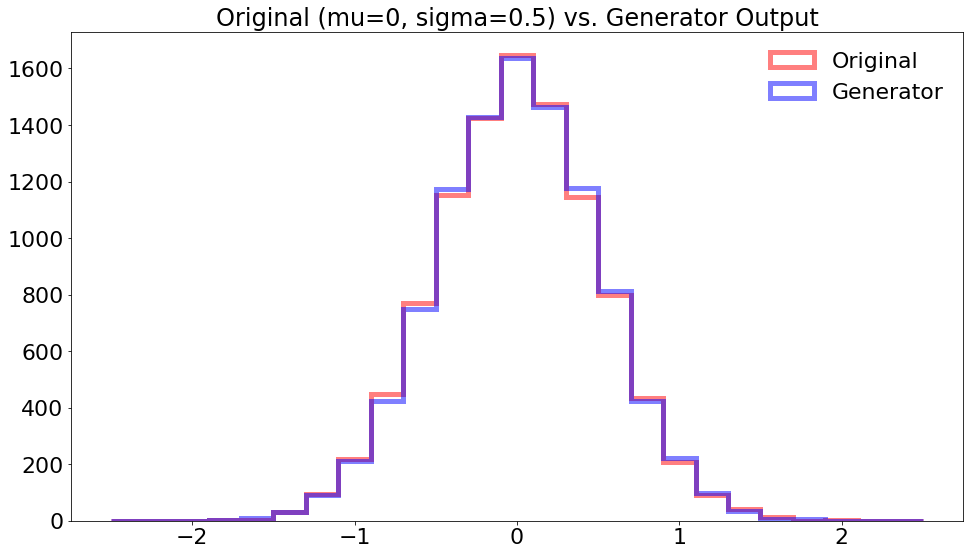

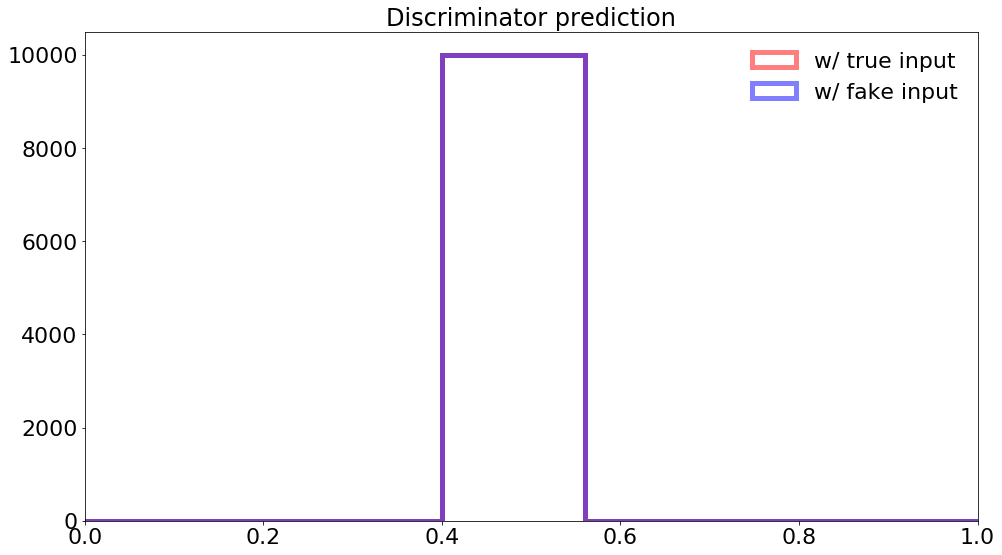

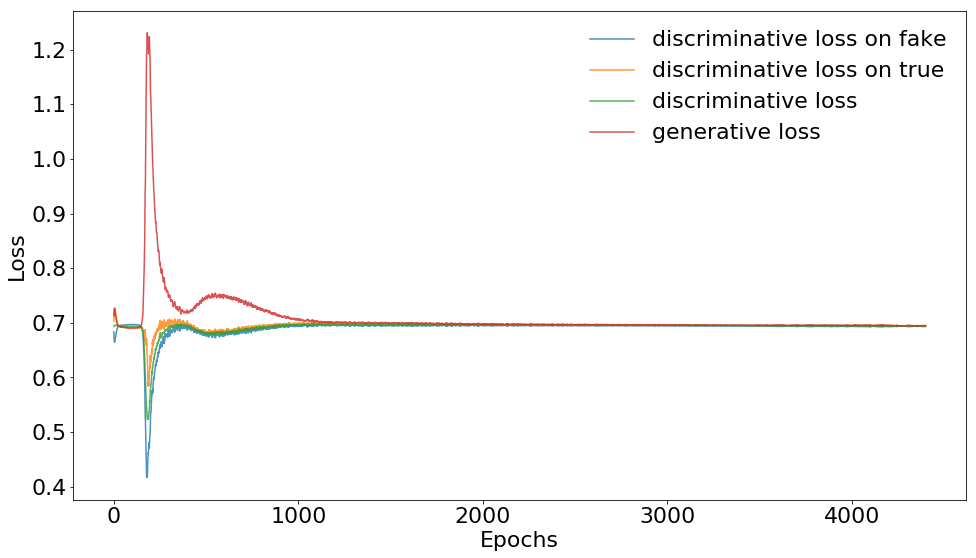

Epoch 4501, Discriminator loss:0.693803608418, GAN loss:0.694351494312
For true: mean and s.d. =  -0.0015715753241 0.49755826282
For generator: mean and s.d. =  0.00237772 0.503152


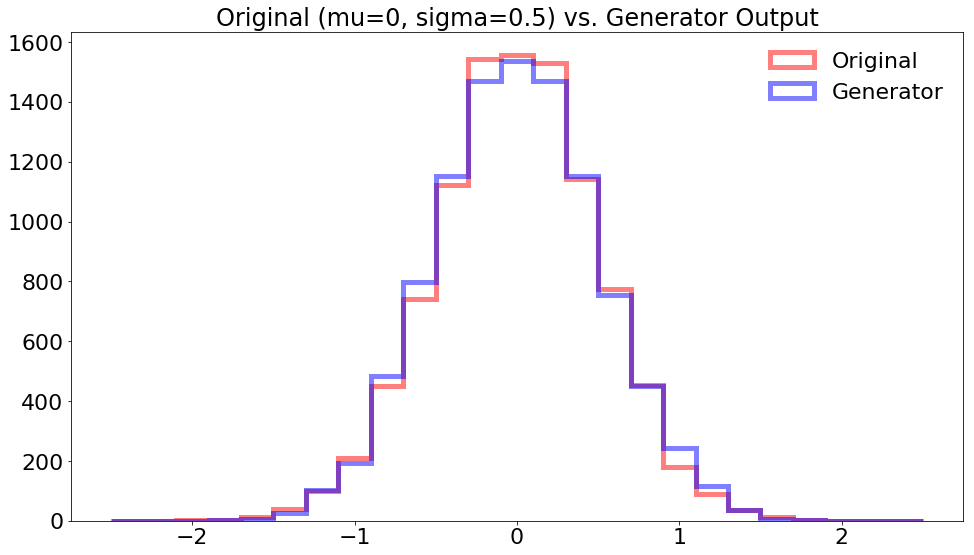

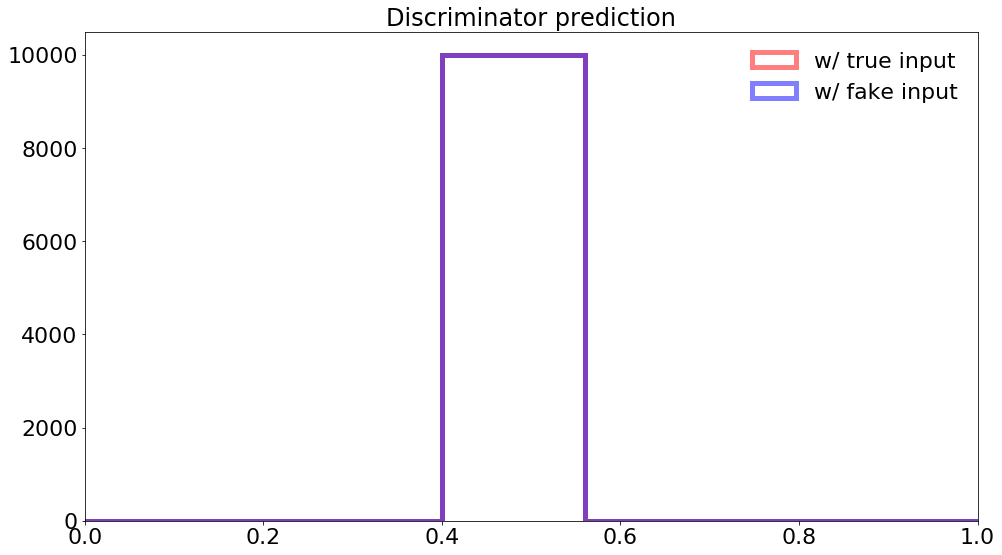

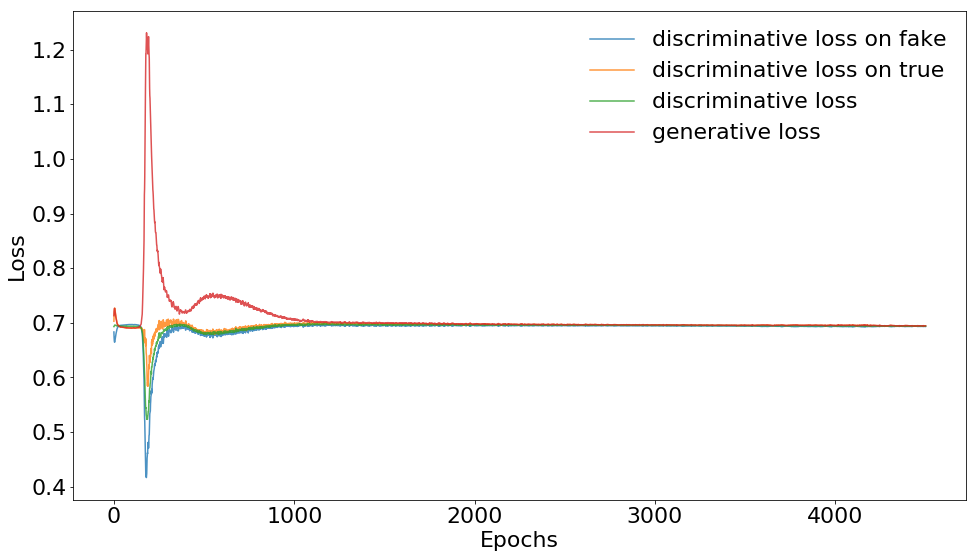

Epoch 4601, Discriminator loss:0.693778574467, GAN loss:0.69407004118
For true: mean and s.d. =  -0.00326195671025 0.503061244189
For generator: mean and s.d. =  -0.00238821 0.497144


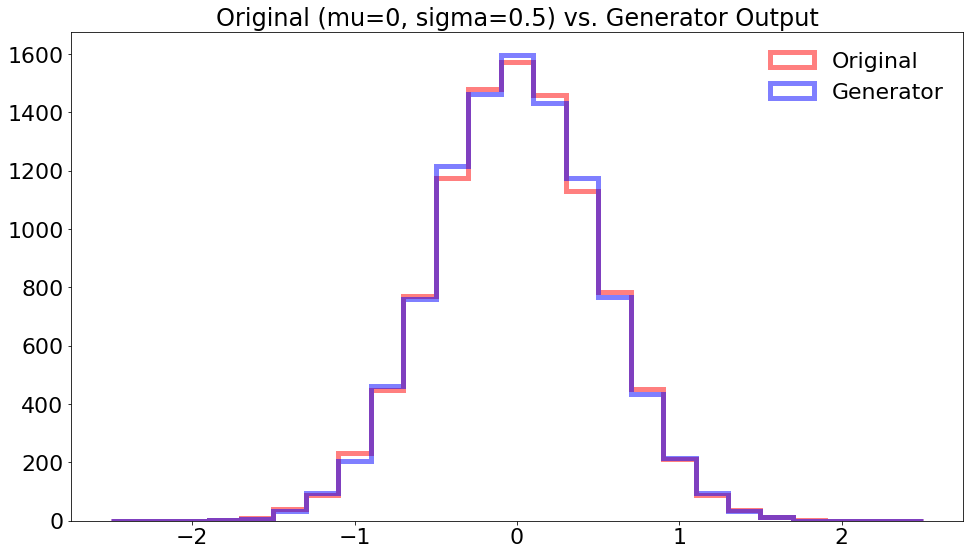

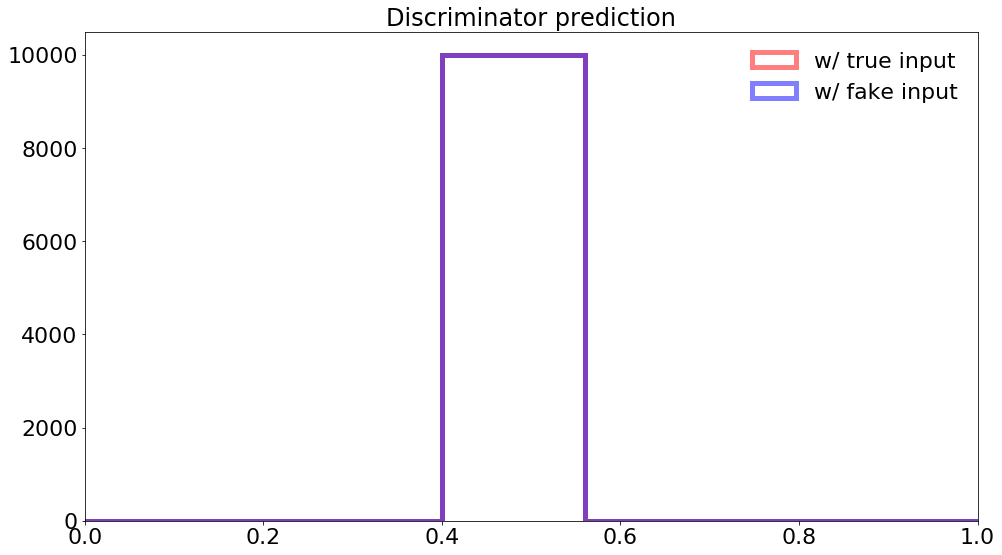

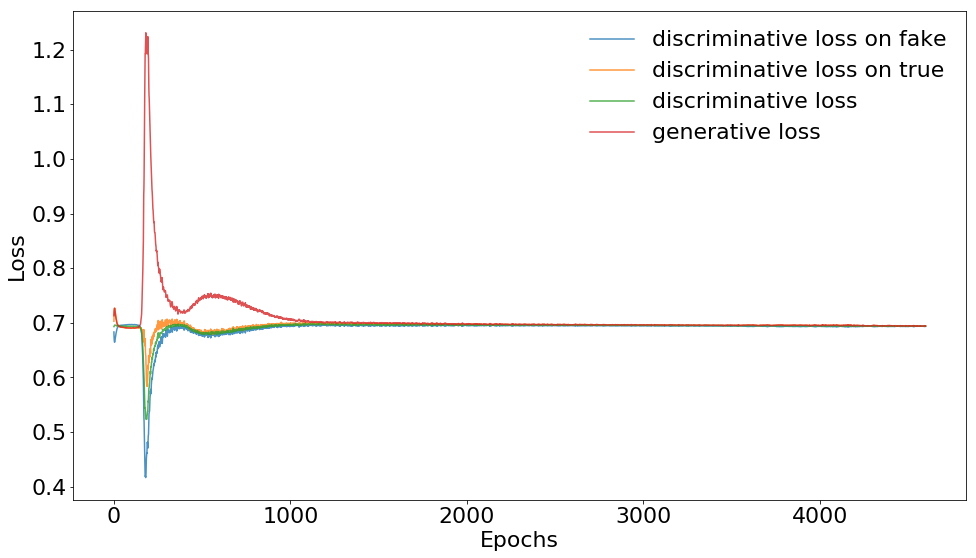

Epoch 4701, Discriminator loss:0.6940356493, GAN loss:0.693566679955
For true: mean and s.d. =  0.0131441928917 0.500049300724
For generator: mean and s.d. =  0.00536862 0.502753


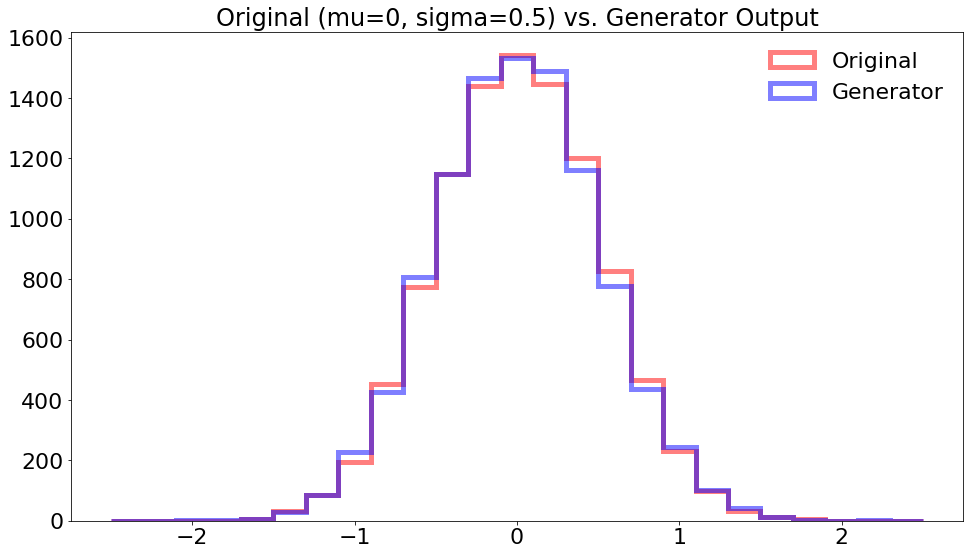

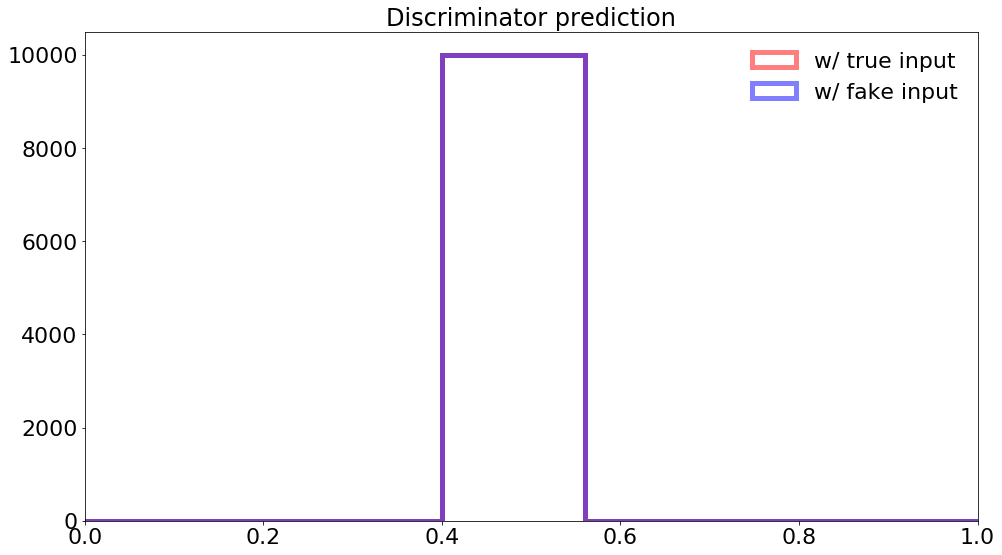

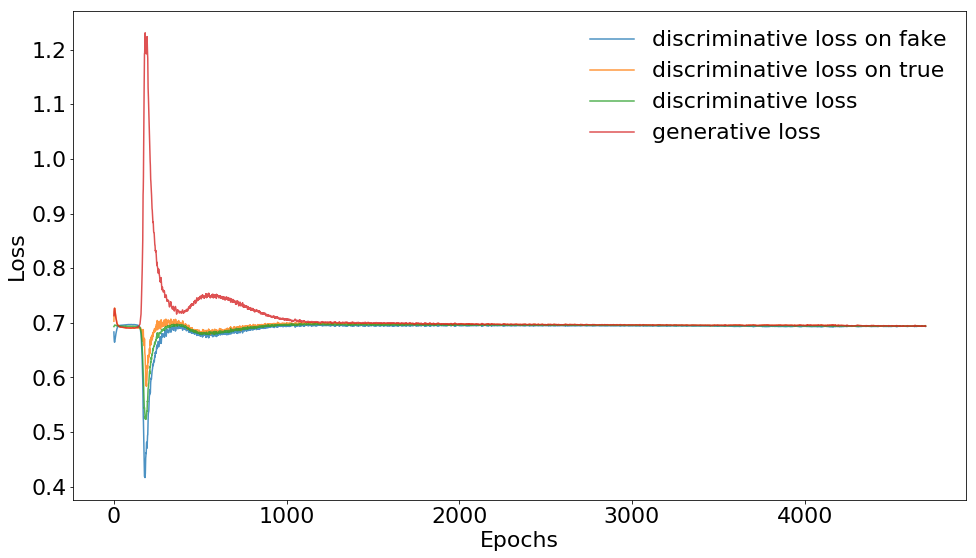

Epoch 4801, Discriminator loss:0.693635702133, GAN loss:0.693596065044
For true: mean and s.d. =  -0.0074564150346 0.501299371493
For generator: mean and s.d. =  -0.000860278 0.498371


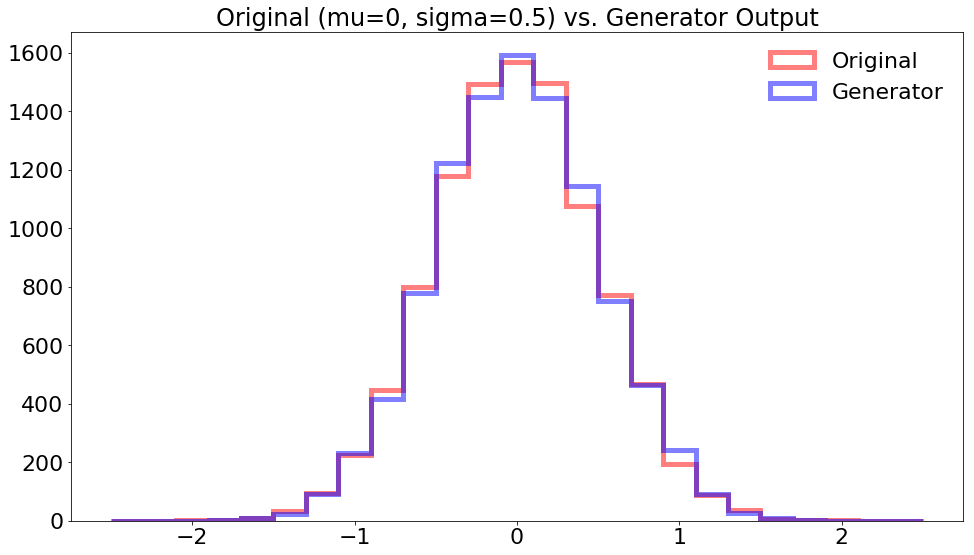

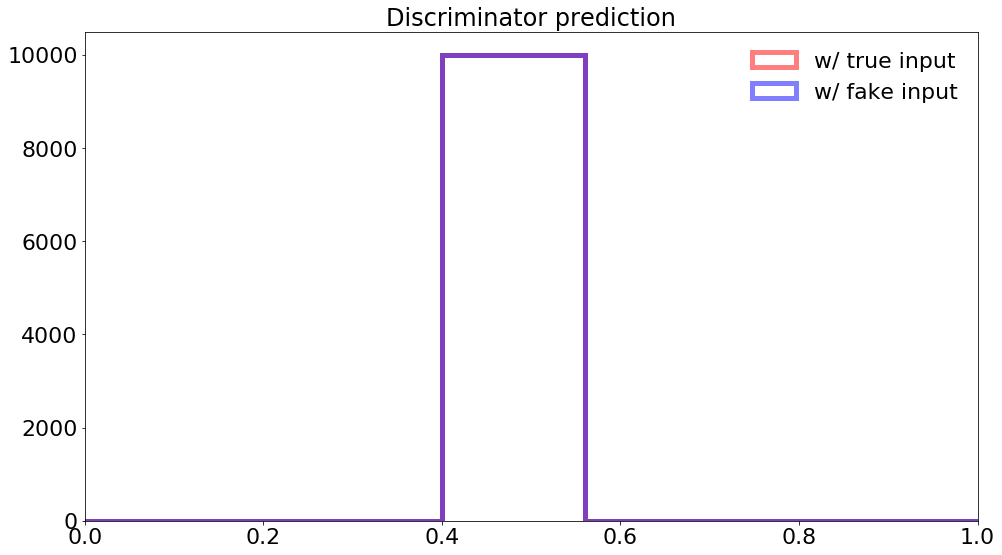

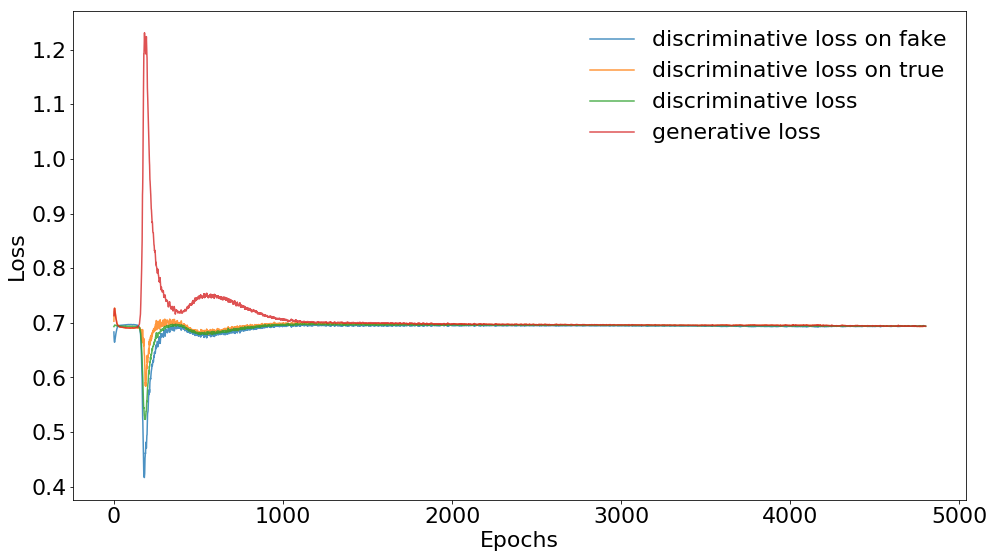

Epoch 4901, Discriminator loss:0.693622112274, GAN loss:0.693517208099
For true: mean and s.d. =  0.00636070770161 0.50303383151
For generator: mean and s.d. =  0.00683348 0.500194


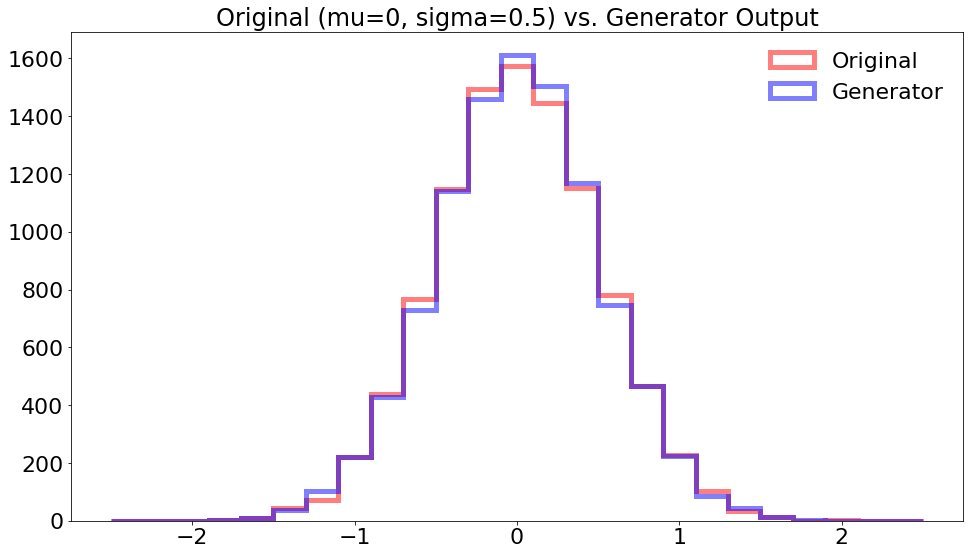

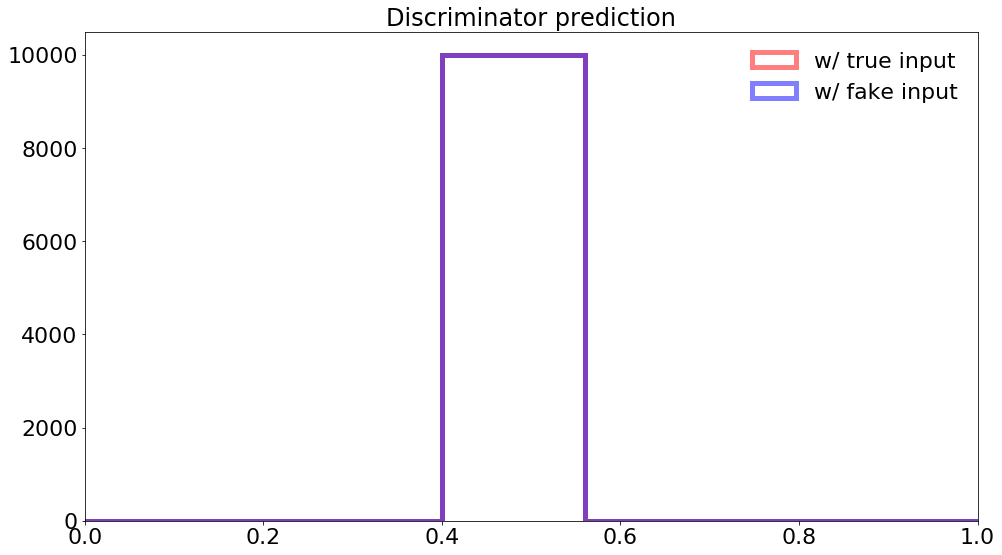

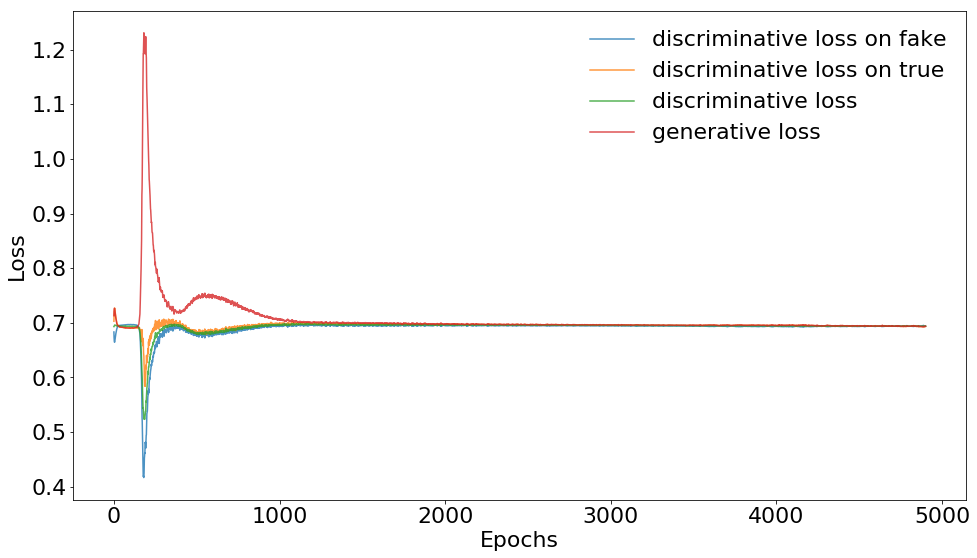

Epoch 5001, Discriminator loss:0.693666815758, GAN loss:0.69295835495
For true: mean and s.d. =  0.00655159441832 0.505609689467
For generator: mean and s.d. =  -0.000940759 0.502354


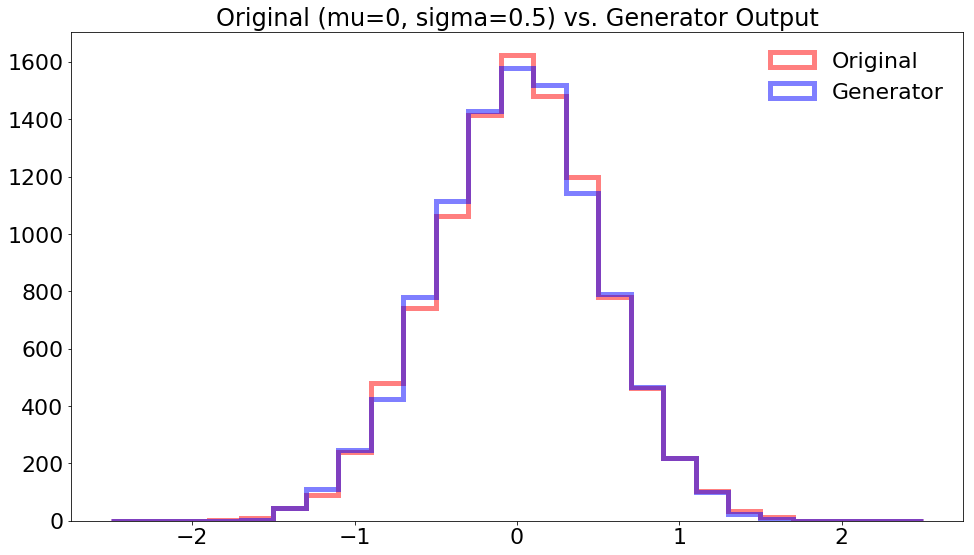

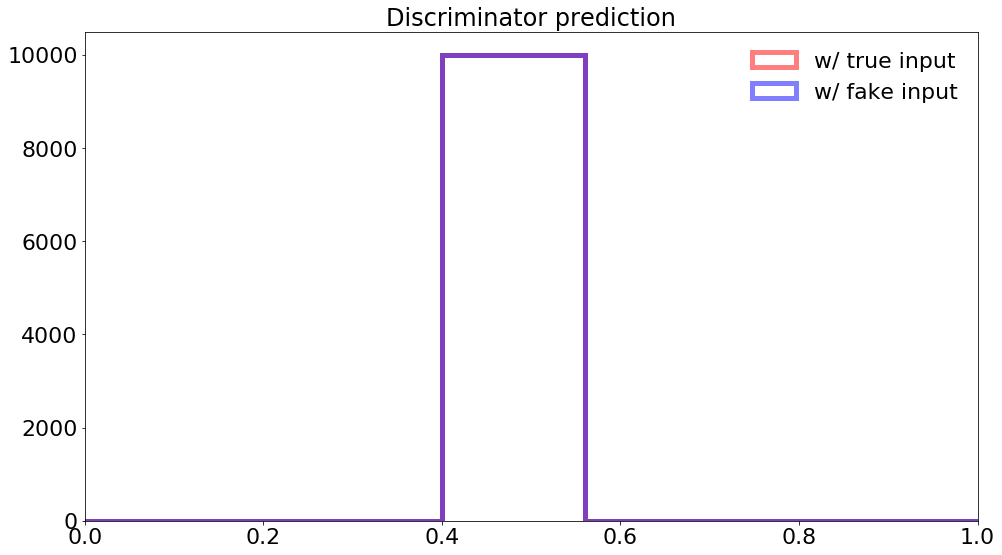

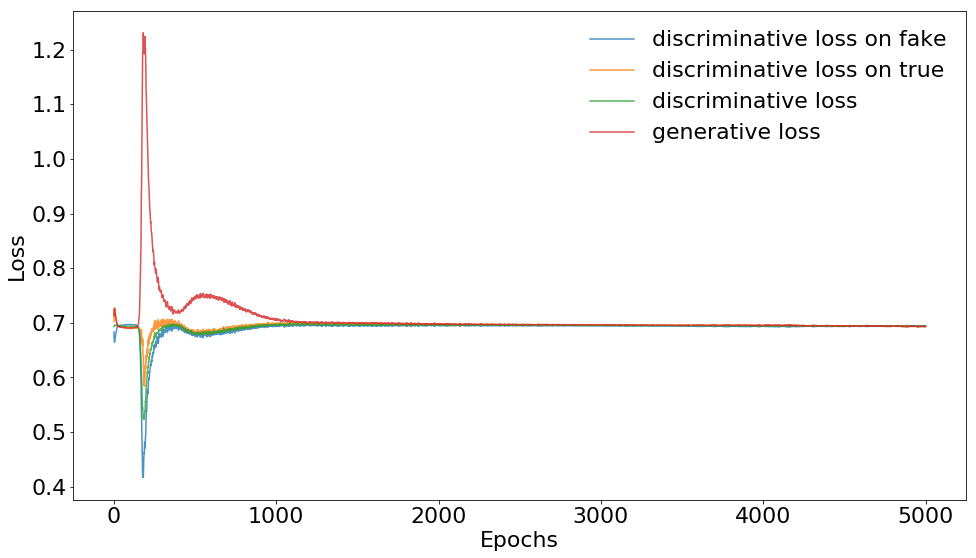

In [14]:
pretrain_disc = True
if pretrain_disc ==True:
    #temp (pretrain dicriminator)
    true_disc_x = gaussian(batch_size,mu=0.,sigma=0.5)
    latent = noise_g(batch_size, mu=0., sigma=0.6)#noise(batch_size, m=-2.5, M=+2.5)
    true_disc_y = np.zeros(batch_size)
    fake_disc_x = G.predict(latent)
    fake_disc_y = np.ones(batch_size)
    

    #x_disc = np.concatenate((true_disc_x, fake_disc_x))
    #x_disc = x_disc.reshape((x_disc.shape[0], 1))
    #y_disc = np.concatenate((true_disc_y, fake_disc_y))

    G.trainable = False
    D.trainable = True
    #d_loss_true = D.train_on_batch(true_disc_x, true_disc_y)
    #d_loss_fake = D.train_on_batch(fake_disc_x, fake_disc_y)
    d_loss = D.train_on_batch(true_disc_x, true_disc_y)
    d_loss = D.train_on_batch(fake_disc_x, fake_disc_y)

    print d_loss

nb_epochs = 5001
#losses = {"d":[], "g":[]}

for i in range(0,nb_epochs):
    
    d_loss, g_loss = train(G,D,Model,i)
    #losses["d"].append(d_loss)
    #losses["g"].append(g_loss)  
    
    if i %100 == 0:
        print("Epoch {0}, Discriminator loss:{1}, GAN loss:{2}".format(i + 1, d_loss, g_loss))
        #overlay GAN output on the Gaussian we want
                
        true_disc = gaussian(batch_size,mu=0.,sigma=0.5)
        sd = np.std(true_disc)
        mean = np.mean(true_disc)
        print "For true: mean and s.d. = ", mean, sd
        latent = noise_g(batch_size,mu=0.,sigma=0.6)
    
        G.trainable = False
        D.trainable = False
        fake_disc = G.predict(latent)
        
        sd = np.std(fake_disc)
        mean = np.mean(fake_disc)
        print "For generator: mean and s.d. = ", mean, sd
        
        plt.figure(figsize=(16,9))
        plt.title("Original (mu=0, sigma=0.5) vs. Generator Output", fontsize=24)
        plt.hist(true_disc, color='r', histtype='step', linewidth=5, bins = 25, range = (-2.5,2.5), label = "Original", alpha=0.5)
        plt.hist(fake_disc, color='b', histtype='step', linewidth=5, bins = 25, range = (-2.5,2.5), label = 'Generator', alpha=0.5)
        plt.legend(loc='best', fontsize=22, fancybox=True, framealpha=0.)
        # plt.ylim(0,0.6)
        plt.rc('xtick', labelsize = 22)
        plt.rc('ytick', labelsize = 22)
        plt.show()     
        #print losses
        
        true_pred = D.predict(true_disc)
        fake_pred = D.predict(fake_disc)
            
        plt.figure(figsize=(16,9))
        plt.title("Discriminator prediction", fontsize=24)
        plt.hist(true_pred, color='r', histtype='step', linewidth=5, bins = 25, range = (-2.,2.), label = "w/ true input", alpha=0.5)
        plt.hist(fake_pred, color='b', histtype='step', linewidth=5, bins = 25, range = (-2.,2.), label = 'w/ fake input', alpha=0.5)
        plt.legend(loc='best', fontsize=22, fancybox=True, framealpha=0.)
        plt.xlim(0.,1.)
        plt.rc('xtick', labelsize = 22)
        plt.rc('ytick', labelsize = 22)
        plt.show()
        
        
        plot_loss(losses)
    savemodel(model=Model, name="GaussiGAN_2_m2p5M2p5_gauslat")

(array([  1.17000000e+02,   1.32000000e+03,   7.01600000e+03,
          2.00810000e+04,   3.14540000e+04,   2.59900000e+04,
          1.09560000e+04,   2.71100000e+03,   3.41000000e+02,
          1.40000000e+01]),
 array([-1.91831291, -1.50981122, -1.10130954, -0.69280785, -0.28430617,
         0.12419552,  0.5326972 ,  0.94119889,  1.34970057,  1.75820225,
         2.16670394]),
 <a list of 10 Patch objects>)

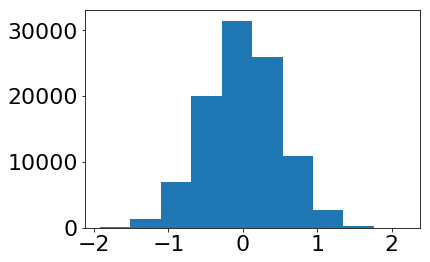

In [15]:
p = G.predict(noise_g(100000, 0., 0.6))
plt.hist(p)

In [16]:
sd = np.std(p, dtype=np.float64)
v = np.var(p, dtype=np.float64)
mean = np.mean(p, dtype=np.float64)

print mean, sd
savemodel(model=G, name="GaussiGAN_2_m2p5M2p5_gauslat_gen")
savemodel(model=D, name="GaussiGAN_2_m2p5M2p5_gauslat_disc")
savemodel(model=Model, name="GaussiGAN_2_m2p5M2p5_gauslat")

-0.00271276431424 0.500024951265


-2.02982283603 2.09453211645
For generator: mean and s.d =  -0.00223628 0.503433


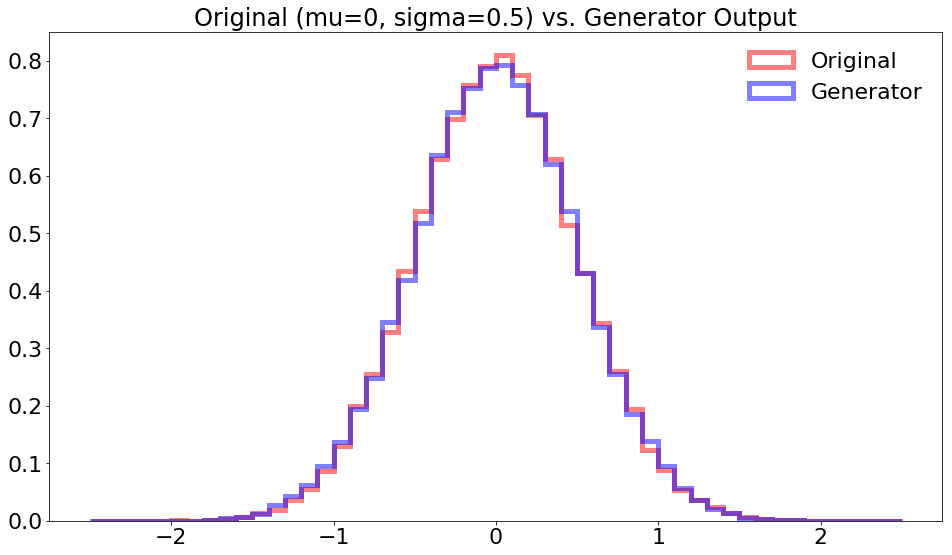

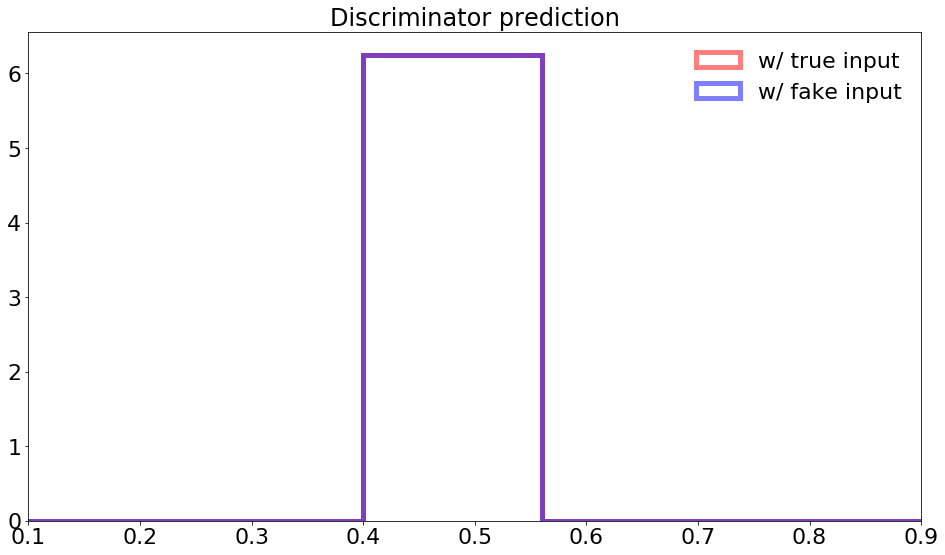

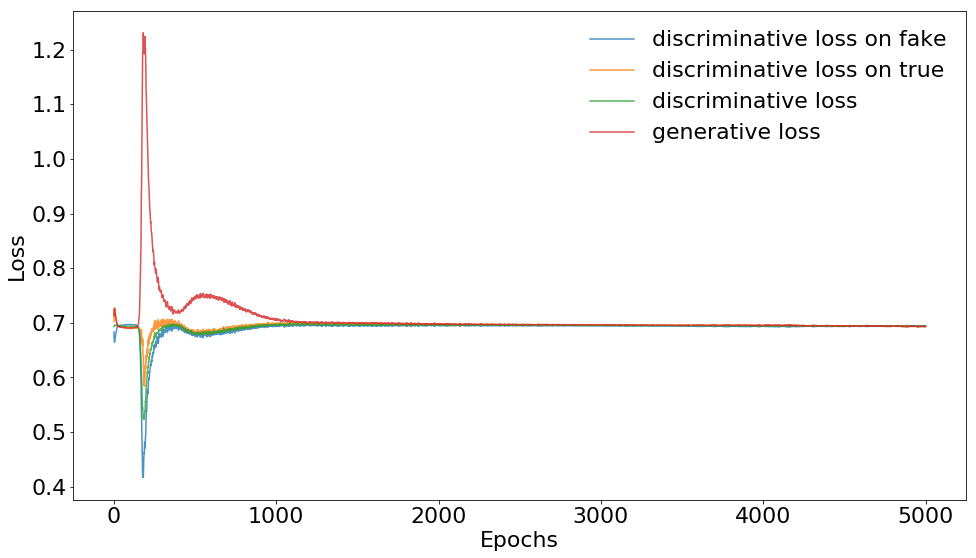

In [17]:
        ###################
        batch_size = 100000    
        true_disc = gaussian(batch_size,mu=0.,sigma=0.5)
        true_disc.sort()
        print true_disc.min(), true_disc.max()
        sd = np.std(true_disc)
        mean = np.mean(true_disc)
        latent = noise_g(batch_size,mu=0.,sigma=0.6)
        latent.sort()
        G.trainable = False
        D.trainable = False
        fake_disc = G.predict(latent)
        #print fake_disc
        sd = np.std(fake_disc)
        mean = np.mean(fake_disc)
        print "For generator: mean and s.d = ", mean, sd
        ###################
        
        plt.figure(figsize=(16,9))
        plt.title("Original (mu=0, sigma=0.5) vs. Generator Output", fontsize=24)
        plt.hist(true_disc, color='r', histtype='step', linewidth=5, bins = 50, range = (-2.5,2.5), label = "Original", alpha=0.5, normed=True)
        plt.hist(fake_disc, color='b', histtype='step', linewidth=5, bins = 50, range = (-2.5,2.5), label = 'Generator', alpha=0.5, normed=True)
        plt.legend(loc='best', fontsize=22, fancybox=True, framealpha=0.)
        # plt.ylim(0,0.6)
        plt.rc('xtick', labelsize = 22)
        plt.rc('ytick', labelsize = 22)
        plt.savefig("GaussiGAN_2_m2p5M2p5_gauslat_overlay_m2p5M2p5.png")
        plt.show()     
        #print losses
        
        true_pred = D.predict(true_disc)
        fake_pred = D.predict(fake_disc)
            
        plt.figure(figsize=(16,9))
        plt.title("Discriminator prediction", fontsize=24)
        plt.hist(true_pred, color='r', histtype='step', linewidth=5, bins = 25, range = (-2.,2.), label = "w/ true input", alpha=0.5, normed=True)
        plt.hist(fake_pred, color='b', histtype='step', linewidth=5, bins = 25, range = (-2.,2.), label = 'w/ fake input', alpha=0.5, normed=True)
        plt.legend(loc='best', fontsize=22, fancybox=True, framealpha=0.)
        plt.xlim(0.1,0.9)
        plt.rc('xtick', labelsize = 22)
        plt.rc('ytick', labelsize = 22)
        plt.savefig("GaussiGAN_2_m2p5M2p5_gauslat_Disc_prediction_overlay_m2p5M2p5.png")
        plt.show()
        
        
        plot_loss(losses, modelname="GaussiGAN_2_m2p5M2p5_gauslat")

[-2.       -1.999996 -1.999992 ...,  1.999992  1.999996  2.      ]


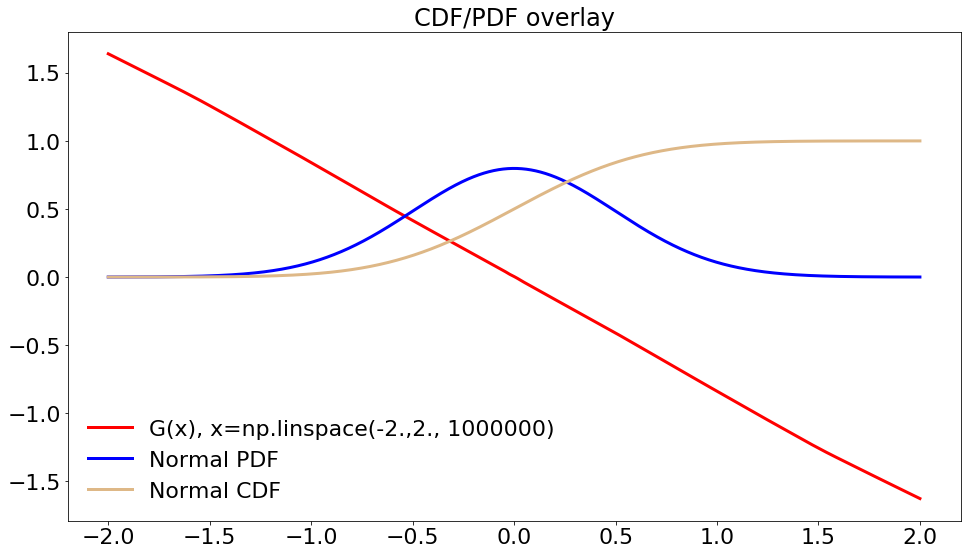

In [32]:
        from scipy.stats import norm
        #fake_disc.sort()
        #dx=0.01
        #X  = np.arange(-2,2,dx)
        #Y  = exp(-X**2)

        # Normalize the data to a proper PDF
        #Y /= (dx*Y).sum()

        # Compute the CDF
        #CY = np.cumsum(Y*dx)

        # Plot both
        #plot(X,Y)
        #plot(X,CY,'r--')
        
        dx = (4/1000000.)
        x = np.linspace(-2.,2., 1000000)
        print x
        G_x = G.predict(x)
        
        PDF_true = 1.0/(np.sqrt(2*np.pi*0.5**2))*np.exp((-(x-0.)**2)/(2*0.5**2))
        PDF_true /= (dx*PDF_true).sum()
        CDF_true = np.cumsum(PDF_true*dx)
        
        #normalizing
        #G_y /= (dx*G_y).sum()
        #GCDF_y = np.cumsum(G_y*dx)
        
        #TCDF_x = np.arange(-2.5,2.5, 0.01)
        #TCDF_y = np.arange(-2.5,2.5, 0.01)
        #for i in range(TCDF_y.shape[0]):
        #    TCDF_y[i] = norm.cdf(TCDF_x[i],0., 0.5)
            

        #print TCDF_y, TCDF_x
        #print GCDF_y, GCDF_x
        
        
        plt.figure(figsize=(16,9))
        plt.title("CDF/PDF overlay", fontsize=24)
        plt.plot(x, G_x, color='r', linewidth=3, label = "G(x), x=np.linspace(-2.,2., 1000000)")
        plt.plot(x, PDF_true, color='b', linewidth=3, label = "Normal PDF")
        plt.plot(x, CDF_true, color = 'burlywood', linewidth=3, label="Normal CDF")
        #plt.plot(x, norm.cdf(G_x), color = 'm', linewidth=3, label="CDF of g(x)")
        #plt.hist(G_x,normed=True)
        plt.legend(loc='best', fontsize=22, fancybox=True, framealpha=0.)
        #plt.ylim(-2,2)
        plt.rc('xtick', labelsize = 22)
        plt.rc('ytick', labelsize = 22)
        plt.savefig("GaussiGAN_2_m2p5M2p5_gauslat_CDF_overlay_m2p5M2p5.png")
        plt.show()
        

(array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([-0.48677311, -0.38677311, -0.28677311, -0.18677311, -0.08677311,
         0.01322689,  0.11322689,  0.21322689,  0.31322689,  0.41322689,
         0.51322689]),
 <a list of 10 Patch objects>)

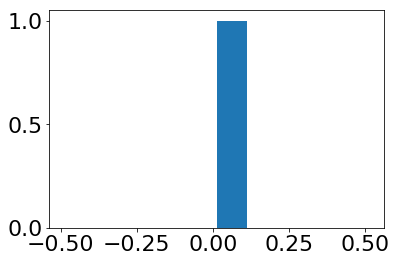

In [23]:
num = min(2.5, max(-2.5, random.gauss(0, 0.5)))
plt.hist(num)

[-2.5     -2.49995 -2.4999  ...,  2.4999   2.49995  2.5    ]
100000 100000


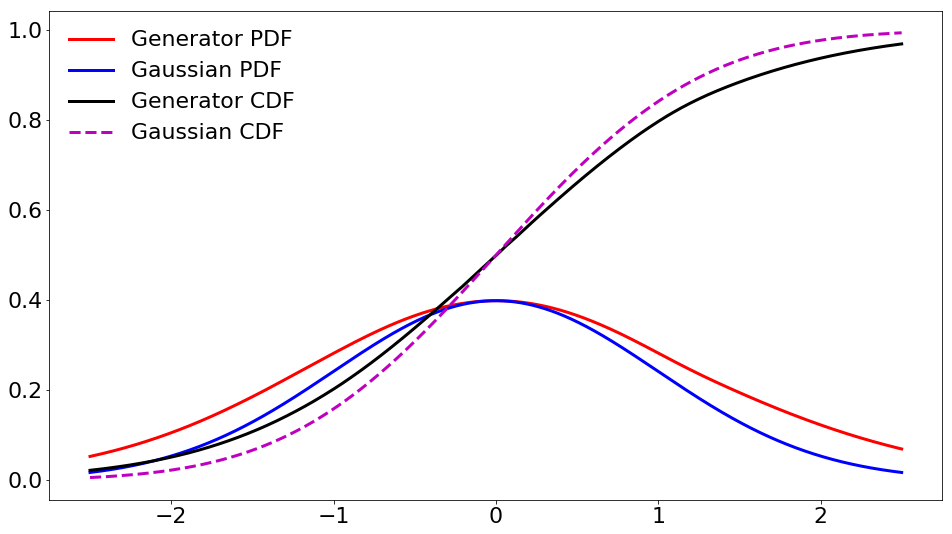

In [73]:
        from scipy.stats import norm
        #fake_disc.sort()
        #dx=0.01
        #X  = np.arange(-2,2,dx)
        #Y  = exp(-X**2)

        # Normalize the data to a proper PDF
        #Y /= (dx*Y).sum()

        # Compute the CDF
        #CY = np.cumsum(Y*dx)

        # Plot both
        #plot(X,Y)
        #plot(X,CY,'r--')
        
        
        x = np.linspace(-2.5,2.5, 100000)
        print x
        G_x = G.predict(x)
        G_x.sort()
        
        print x.shape[0], G_x.shape[0]
        true = 1.0/(np.sqrt(2*np.pi*0.5**2))*np.exp((-(x-0.)**2)/(2*0.5**2))
        
        
        #normalizing
        #G_y /= (dx*G_y).sum()
        #GCDF_y = np.cumsum(G_y*dx)
        
        #TCDF_x = np.arange(-2.5,2.5, 0.01)
        #TCDF_y = np.arange(-2.5,2.5, 0.01)
        #for i in range(TCDF_y.shape[0]):
        #    TCDF_y[i] = norm.cdf(TCDF_x[i],0., 0.5)
            

        #print TCDF_y, TCDF_x
        #print GCDF_y, GCDF_x
        
        
        plt.figure(figsize=(16,9))
        #plt.title("CDF overlay", fontsize=24)
        plt.plot(x, norm.pdf(G_x), color='r', linewidth=3, label = "Generator PDF")
        plt.plot(x, norm.pdf(x), color='b', linewidth=3, label = "Gaussian PDF")
        plt.plot(x, norm.cdf(G_x), color = 'k', linewidth=3, label="Generator CDF")
        plt.plot(x, norm.cdf(x), color = 'm', linestyle = '--', linewidth=3, label="Gaussian CDF")
        #plt.hist(G_x,normed=True)
        plt.legend(loc='best', fontsize=22, fancybox=True, framealpha=0.)
        #plt.ylim(-2,2)
        plt.rc('xtick', labelsize = 22)
        plt.rc('ytick', labelsize = 22)
        plt.savefig("GaussiGAN_2_m2p5M2p5_gauslat_CDF_overlay_m2p5M2p5.png")
        plt.show()
        

In [11]:
#working with minibatches

%matplotlib inline
import numpy as np
from matplotlib import pylab as plt
import seaborn as sns

In [12]:
def kldiv(P,Q):
    """KL divergence between two sets of discrete distributions P and Q
    
    Parameters
    ----------
    Q, P : numpy.array with ndims=2
        These arrays encode the distributions or arrays of to be compared.
        Q and P should have the same second dimension, which is the number
        of discrete values the random variable can take. The first dimension
        is either 1 for P or Q, or has to be the same for P and Q.
        
    Returns
    -------
    numpy.array with ndims=2
        array of KL divergence values between the corresponding P and Q
        distributions.
    """
    return (P*(np.log2(P) - np.log2(Q))).sum(axis=1)

def jsdiv(P, Q):
    mixture = (P+Q)/2
    return (kldiv(P, mixture) + kldiv(Q, mixture))/2

In [19]:
def iid2(P):
    """Takes a(n array of) discrete distribution P and returns the discrete
    joint distribution of 2 independent and identically distributed samples
    from P
    
    Parameters
    ----------
    P : numpy.array with ndims=2
        This array encodes discrete probability distributions. The second
        dimension indexes the different values the random variable can take
        
    Returns
    -------
    numpy.array with ndims=2
        array representing the join distributions of two i.i.d. samples drawn
        from the corresponding distribution in P
    """
    n,d = P.shape
    print P
    return (P.reshape((n,d,1)) * P.reshape((n,1,d))).reshape(n,d**2)

a = iid2(gaussian(100000, 0., 0.5))
print a.shape, a.shape[0]
print a
for i in range(10):
    print a[:,i]
    #plt.hist(a[:,i])

[[-2.18266436]
 [-2.05642175]
 [-1.97790133]
 ..., 
 [ 2.04945237]
 [ 2.10692307]
 [ 2.15356733]]
(100000, 1) 100000
[[ 4.7640237 ]
 [ 4.2288704 ]
 [ 3.91209369]
 ..., 
 [ 4.20025503]
 [ 4.43912482]
 [ 4.63785226]]
[ 4.7640237   4.2288704   3.91209369 ...,  4.20025503  4.43912482
  4.63785226]


IndexError: index 1 is out of bounds for axis 1 with size 1

In [32]:
#checking that the math works: the KL divergence between the joint distribution
#of two i.i.d. samples should be exactly twice the KL divergence between single
#samples.

klpq = kldiv(P,Q)
klpq2 = kldiv(iid2(P),iid2(Q))/2
assert np.allclose(klpq,klpq2)

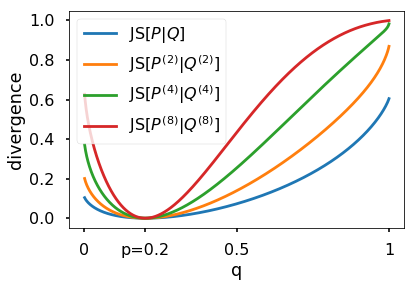

In [35]:
#looking at 'minibatch' JS divergence for increasing minibatch sizes:
jspq = jsdiv(P,Q)
jsp2q2 = jsdiv(iid2(P),iid2(Q))
jsp4q4 = jsdiv(iid2(iid2(P)),iid2(iid2(Q)))
jsp8q8 = jsdiv(iid2(iid2(iid2(P))),iid2(iid2(iid2(Q))))
jsp16q16 = jsdiv(iid2(iid2(iid2(iid2(P)))),iid2(iid2(iid2(iid2(Q)))))


sns.set_context('poster')
plt.plot(Q[:,0],jspq)
plt.plot(Q[:,0],jsp2q2)
plt.plot(Q[:,0],jsp4q4)
plt.plot(Q[:,0],jsp8q8)
plt.xlabel('q')
plt.ylabel('divergence')
plt.legend(['JS$[P\|Q]$', 
            'JS$[P^{(2)}\|Q^{(2)}]$',
            'JS$[P^{(4)}\|Q^{(4)}]$',
            'JS$[P^{(8)}\|Q^{(8)}]$'],loc=2);
plt.xticks([0,0.2,0.5,1], ['0','p=0.2','0.5','1']);

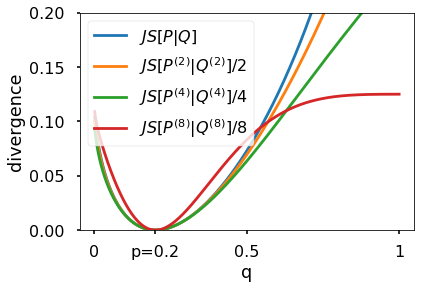

In [36]:
sns.set_context('poster')
plt.plot(Q[:,0],jspq)
plt.plot(Q[:,0],jsp2q2/2)
plt.plot(Q[:,0],jsp4q4/4)
plt.plot(Q[:,0],jsp16q16/8)
plt.xlabel('q')
plt.ylabel('divergence')
plt.legend(['$JS[P\|Q]$', 
            '$JS[P^{(2)}\|Q^{(2)}]/2$',
            '$JS[P^{(4)}\|Q^{(4)}]/4$',
            '$JS[P^{(8)}\|Q^{(8)}]/8$'],loc=2);
plt.ylim([0,0.2]);
plt.xticks([0,0.2,0.5,1], ['0','p=0.2','0.5','1']);

In [47]:
a[20000]

array([ 0.17620523])

In [18]:
    batch_size=100000
    true_disc_x = gaussian(batch_size,mu=0.,sigma=0.5)
    sd = np.std(true_disc_x)
    mean = np.mean(true_disc_x)
    #l = -2.5 #mean-2*sd
    #r = +2.5 #mean+2*sd
    latent = noise_g(batch_size, mu=0., sigma = 0.6) #noise(batch_size, m=l, M=r) # m=true_disc_x.min(), M=true_disc_x.max())
    true_disc_y = np.zeros(batch_size)
    fake_disc_x = G.predict(latent)
    fake_disc_y = np.ones(batch_size)
    
    #label-smoothing
    #true_disc_y[0:] = 0.4*np.random.random_sample(1)[0]+0.8
    #fake_disc_y[0:] = 0.2*np.random.random_sample(1)[0]
    #true_disc_y[0:] = 0.9
    
    
    x_disc = np.concatenate((true_disc_x, fake_disc_x))
    x_disc = x_disc.reshape((x_disc.shape[0], 1))
    #print x_disc.shape
    y_disc = np.concatenate((true_disc_y, fake_disc_y))
    y_disc = y_disc.reshape((y_disc.shape[0], 1))
    #y_disc.flatten()
    #print y_disc.shape
    
    G.trainable = False
    D.trainable = True
    #d_loss_true = D.train_on_batch(true_disc_x, true_disc_y)
    d_loss_true = D.fit(true_disc_x, true_disc_y, batch_size=2000, shuffle=True)
    #d_loss_fake = D.train_on_batch(fake_disc_x, fake_disc_y)
    d_loss_fake = D.fit(fake_disc_x, fake_disc_y, batch_size=2000, shuffle=True)
    #d_loss = D.train_on_batch(x_disc, y_disc)
    #d_loss = (d_loss_true + d_loss_fake) / 2.0
    #losses["d_f"].append(d_loss_fake)
    #losses["d_t"].append(d_loss_true)
    #losses["d"].append(d_loss)
    #plt.plot(d_loss_true.history)
    x_gen = latent
    y_gen = np.zeros(batch_size)    
       
    G.trainable = True 
    D.trainable = False    
    
    GAN_loss = Model.train_on_batch(x_gen, y_gen)
    #losses["g"].append(GAN_loss)
    

Epoch 1/1
100000/100000 [==============================] - 0s - loss: 1.4999e-07     
Epoch 1/1
100000/100000 [==============================] - 0s - loss: 16.1181     


In [15]:
d_loss_fake.history['loss']


[0.72697045803070071]